In [1]:

import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt 
from scipy import stats
from scipy.stats import norm, skew 
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRFRegressor,XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor



In [2]:


def freq_enc(df,cols):
    for col in cols:
        df[col] = df[col].map(df[col].value_counts().to_dict())/len(df)
    return df


def label_enc(df,cols):
    for col in cols:
        df[col] = df[col].factorize()[0]
    return df

In [3]:

train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')


In [4]:
train.head(5)

,Product_Identifier,Supermarket_Identifier,Product_Supermarket_Identifier,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Type,Product_Price,Supermarket_Opening_Year,Supermarket _Size,Supermarket_Location_Type,Supermarket_Type,Average_Price_per_ProductType,Product_Supermarket_Sales
0,NCA29,CHUKWUDI046,NCA29_CHUKWUDI046,10.500,Low Fat,0.027276,Household,428.28,2004,Small,Cluster 1,Supermarket Type1,399.999418,8983.31
1,FDG53,CHUKWUDI049,FDG53_CHUKWUDI049,10.000,Low Fat,0.045928,Frozen Foods,345.30,2006,Medium,Cluster 1,Supermarket Type1,388.071094,4893.63
2,NCN05,CHUKWUDI045,NCN05_CHUKWUDI045,8.235,Low Fat,0.014489,Health and Hygiene,459.49,2009,NaN,Cluster 2,Supermarket Type1,367.143029,7323.80
3,NCV17,CHUKWUDI046,NCV17_CHUKWUDI046,18.850,Low Fat,0.016108,Health and Hygiene,324.41,2004,Small,Cluster 1,Supermarket Type1,367.143029,7541.85
4,FDK03,CHUKWUDI045,FDK03_CHUKWUDI045,12.600,Normal Fat,0.074070,Dairy,635.59,2009,NaN,Cluster 2,Supermarket Type1,409.504343,11445.10


In [5]:
test.head(5)

,Product_Identifier,Supermarket_Identifier,Product_Supermarket_Identifier,Product_Weight,Product_Fat_Content,Product_Shelf_Visibility,Product_Type,Product_Price,Supermarket_Opening_Year,Supermarket _Size,Supermarket_Location_Type,Supermarket_Type,Average_Price_per_ProductType
0,FDY57,CHUKWUDI013,FDY57_CHUKWUDI013,20.20,Normal Fat,0.121153,Snack Foods,243.44,1994,High,Cluster 3,Supermarket Type1,395.352190
1,FDY10,CHUKWUDI018,FDY10_CHUKWUDI018,17.60,Low Fat,0.049268,Snack Foods,282.54,2016,Medium,Cluster 3,Supermarket Type2,395.352190
2,FDO40,CHUKWUDI018,FDO40_CHUKWUDI018,17.10,Low Fat,0.032761,Frozen Foods,372.10,2016,Medium,Cluster 3,Supermarket Type2,388.071094
3,NCQ43,CHUKWUDI018,NCQ43_CHUKWUDI018,17.75,Low Fat,0.000000,Others,271.73,2016,Medium,Cluster 3,Supermarket Type2,388.607700
4,NCC07,CHUKWUDI046,NCC07_CHUKWUDI046,19.60,Low Fat,0.023951,Household,264.24,2004,Small,Cluster 1,Supermarket Type1,399.999418


In [6]:
print('Train size is {}'.format(train.shape))
print('Test size is {}'.format(test.shape))

Train size is (2994, 14)
Test size is (1996, 13)


In [7]:

id_cols = ['Product_Supermarket_Identifier']

train.drop(id_cols, axis=1, inplace=True)
test.drop(id_cols, axis=1, inplace=True)

print('Train size after dropping three columns is {}'.format(train.shape))
print('Test size after dropping three columns  is {}'.format(test.shape))

Train size after dropping three columns is (2994, 13)
Test size after dropping three columns  is (1996, 12)


### Dealing with missing values

In [8]:
train['Product_Weight'].fillna(train['Product_Weight'].mean(),inplace=True)
train['Supermarket _Size'].fillna(train['Supermarket _Size'].mode()[0],inplace=True)

test['Product_Weight'].fillna(test['Product_Weight'].mean(),inplace=True)
test['Supermarket _Size'].fillna(test['Supermarket _Size'].mode()[0],inplace=True)

### Some feature engineering

In [9]:
#Create the log version of product price
train['Product_Price_log'] = np.log1p(train['Product_Price'])
train['Product_Shelf_Visibility_log'] = np.log1p(train['Product_Shelf_Visibility'])

#Create some cross features
train['Product_Price_per_Product_Fat_Content_mean'] = train['Product_Price']/train['Product_Fat_Content'].map(train.groupby('Product_Fat_Content').mean()['Product_Price'].to_dict())
train['Product_Price_per_Supermarket_Location_Type_mean'] = train['Product_Price']/train['Supermarket_Location_Type'].map(train.groupby('Supermarket_Location_Type').mean()['Product_Price'].to_dict())
train['Product_Price_per_Supermarket_Size_mean'] = train['Product_Price']/train['Supermarket _Size'].map(train.groupby('Supermarket _Size').mean()['Product_Price'].to_dict())
train['Product_Price_per_Product_Type_mean'] = train['Product_Price']/train['Product_Type'].map(train.groupby('Product_Type').mean()['Product_Price'].to_dict())
train['Product_Price_per_Supermarket_Type_mean'] = train['Product_Price']/train['Supermarket_Type'].map(train.groupby('Supermarket_Type').mean()['Product_Price'].to_dict())
train['Product_Price_per_Product_Identifier_mean'] = train['Product_Price']/train['Product_Identifier'].map(train.groupby('Product_Identifier').mean()['Product_Price'].to_dict())
train['Product_Price_per_Supermarket_Opening_year_mean'] = train['Product_Price']/train['Supermarket_Opening_Year'].map(train.groupby('Supermarket_Opening_Year').mean()['Product_Price'].to_dict())
train['Product_Price_per_Supermarket_Identifier_mean'] = train['Product_Price']/train['Supermarket_Identifier'].map(train.groupby('Supermarket_Identifier').mean()['Product_Price'].to_dict())

train['cross_Price_weight'] = train['Product_Price'] * train['Product_Weight']
train['cross_Price_visibility'] = train['Product_Price'] * train['Product_Shelf_Visibility']
train['cross_Price_visibility_weight'] = train['Product_Price'] * train['Product_Shelf_Visibility'] * train['Product_Weight']


#Create the log version of product price
test['Product_Price_log'] = np.log1p(test['Product_Price'])
test['Product_Shelf_Visibility_log'] = np.log1p(test['Product_Shelf_Visibility'])

#Create some cross features
test['Product_Price_per_Product_Fat_Content_mean'] = test['Product_Price']/test['Product_Fat_Content'].map(test.groupby('Product_Fat_Content').mean()['Product_Price'].to_dict())
test['Product_Price_per_Supermarket_Location_Type_mean'] = test['Product_Price']/test['Supermarket_Location_Type'].map(test.groupby('Supermarket_Location_Type').mean()['Product_Price'].to_dict())
test['Product_Price_per_Supermarket_Size_mean'] = test['Product_Price']/test['Supermarket _Size'].map(test.groupby('Supermarket _Size').mean()['Product_Price'].to_dict())
test['Product_Price_per_Product_Type_mean'] = test['Product_Price']/test['Product_Type'].map(test.groupby('Product_Type').mean()['Product_Price'].to_dict())
test['Product_Price_per_Supermarket_Type_mean'] = test['Product_Price']/test['Supermarket_Type'].map(test.groupby('Supermarket_Type').mean()['Product_Price'].to_dict())
test['Product_Price_per_Product_Identifier_mean'] = test['Product_Price']/test['Product_Identifier'].map(test.groupby('Product_Identifier').mean()['Product_Price'].to_dict())
test['Product_Price_per_Supermarket_Opening_year_mean'] = test['Product_Price']/test['Supermarket_Opening_Year'].map(test.groupby('Supermarket_Opening_Year').mean()['Product_Price'].to_dict())
test['Product_Price_per_Supermarket_Identifier_mean'] = test['Product_Price']/test['Supermarket_Identifier'].map(test.groupby('Supermarket_Identifier').mean()['Product_Price'].to_dict())

test['cross_Price_weight'] = test['Product_Price'] * test['Product_Weight']
test['cross_Price_visibility'] = test['Product_Price'] * test['Product_Shelf_Visibility']
test['cross_Price_visibility_weight'] = test['Product_Price'] * test['Product_Shelf_Visibility'] * test['Product_Weight']

In [10]:
#change opening year to categories to remove 
train['Supermarket_Opening_Year'].unique()

array([2004, 2006, 2009, 1992, 2014, 2005, 1994, 2016, 2011], dtype=int64)

In [11]:

dict_year = {2005:'A', 1994:'B', 2014:'C', 2016:'D', 2011:'E', 2009:'F', 1992:'G', 2006:'H', 2004:'I'}


train['Supermarket_Opening_Year'] = train['Supermarket_Opening_Year'].map(dict_year)
test['Supermarket_Opening_Year'] = test['Supermarket_Opening_Year'].map(dict_year)


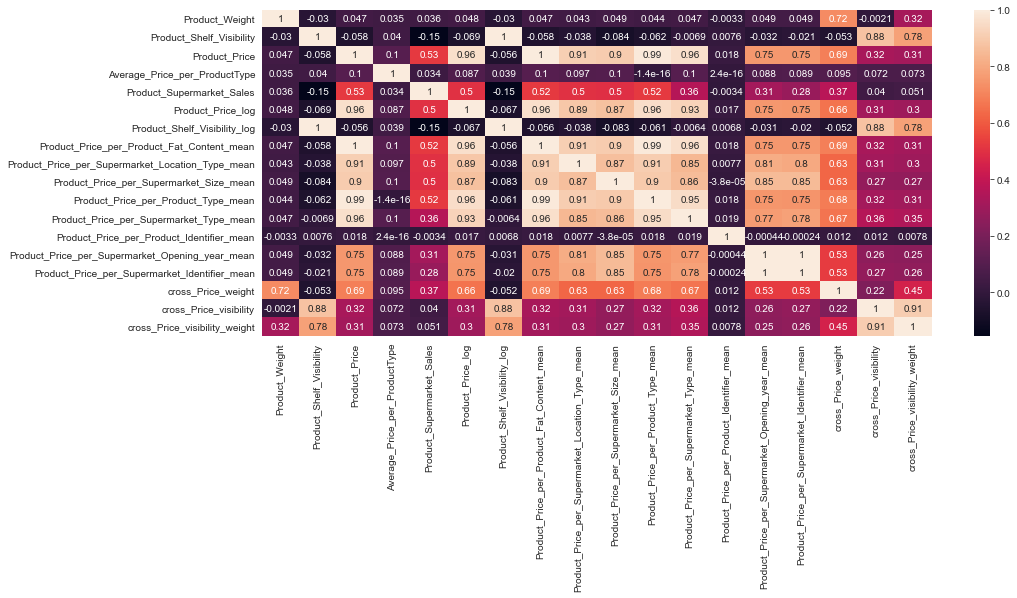

In [12]:
plt.figure(figsize=(15,6))
sns.heatmap(train.corr(),annot=True)

In [13]:
train_copy = train.copy()
test_copy = test.copy()

In [14]:
train = train.drop('Product_Identifier',axis=1)
test = test.drop('Product_Identifier',axis=1)

In [15]:
cols = ['Product_Fat_Content','Product_Type','Supermarket _Size',
        'Supermarket_Location_Type','Supermarket_Opening_Year','Supermarket_Type','Supermarket_Identifier']

train = label_enc(train,cols)
test = label_enc(test,cols)

for col in cols:
    train[col+"_freq"] = train[col].map(train[col].value_counts().to_dict())/len(train)
    test[col+"_freq"] = test[col].map(test[col].value_counts().to_dict())/len(test)
    

In [16]:
X = train.drop('Product_Supermarket_Sales',axis=1)
y = train['Product_Supermarket_Sales']

In [17]:
X.shape,test.shape

((2994, 31), (1996, 31))

In [18]:
to_drop =  ['Product_Fat_Content_freq','Supermarket _Size_freq',
            'Average_Price_per_ProductType','Product_Fat_Content',
           'Product_Type_freq','cross_Price_visibility']

In [19]:
X.drop(to_drop,axis=1,inplace=True)
test.drop(to_drop,axis=1,inplace=True)

> **Now let's MODEL**

In [20]:
cat = CatBoostRegressor(n_estimators=5000,max_depth=5,eval_metric='RMSE',reg_lambda=50,random_state=101)

In [21]:
kf = KFold(n_splits=20,random_state=2020,shuffle=True)

In [22]:
scores = []
test_scores = np.zeros(len(test))
for fold,(tr_in,te_in) in enumerate(kf.split(X)):
    print(f"================================Fold{fold}====================================")
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500,use_best_model=True)
    scores.append(np.sqrt(mean_squared_error(y_test,cat.predict(X_test))))
    test_scores += cat.predict(test)
    

================================Fold0====================================
0:	learn: 4445.1003339	test: 4445.1003339	test1: 4310.6607839	best: 4310.6607839 (0)	total: 244ms	remaining: 20m 22s
1:	learn: 4394.3623236	test: 4394.3623236	test1: 4267.9402722	best: 4267.9402722 (1)	total: 253ms	remaining: 10m 31s
2:	learn: 4346.4573826	test: 4346.4573826	test1: 4227.3574198	best: 4227.3574198 (2)	total: 261ms	remaining: 7m 15s
3:	learn: 4296.2810289	test: 4296.2810289	test1: 4183.6913881	best: 4183.6913881 (3)	total: 268ms	remaining: 5m 34s
4:	learn: 4249.1883744	test: 4249.1883744	test1: 4143.1542317	best: 4143.1542317 (4)	total: 273ms	remaining: 4m 32s
5:	learn: 4206.2423632	test: 4206.2423632	test1: 4106.4982512	best: 4106.4982512 (5)	total: 278ms	remaining: 3m 51s
6:	learn: 4162.0829678	test: 4162.0829678	test1: 4067.8781263	best: 4067.8781263 (6)	total: 283ms	remaining: 3m 21s
7:	learn: 4116.6169916	test: 4116.6169916	test1: 4029.3043531	best: 4029.3043531 (7)	total: 288ms	remaining: 2m 

88:	learn: 2981.6736220	test: 2981.6736220	test1: 3069.3843770	best: 3069.3843770 (88)	total: 576ms	remaining: 31.8s
89:	learn: 2979.0631815	test: 2979.0631815	test1: 3067.2791364	best: 3067.2791364 (89)	total: 580ms	remaining: 31.6s
90:	learn: 2976.8412300	test: 2976.8412300	test1: 3065.8301367	best: 3065.8301367 (90)	total: 584ms	remaining: 31.5s
91:	learn: 2974.7727374	test: 2974.7727374	test1: 3064.3098687	best: 3064.3098687 (91)	total: 589ms	remaining: 31.4s
92:	learn: 2973.0049632	test: 2973.0049632	test1: 3064.5825954	best: 3064.3098687 (91)	total: 593ms	remaining: 31.3s
93:	learn: 2971.0461070	test: 2971.0461070	test1: 3064.2502789	best: 3064.2502789 (93)	total: 597ms	remaining: 31.1s
94:	learn: 2968.7867126	test: 2968.7867126	test1: 3062.7997764	best: 3062.7997764 (94)	total: 601ms	remaining: 31s
95:	learn: 2966.9128121	test: 2966.9128121	test1: 3062.0522975	best: 3062.0522975 (95)	total: 605ms	remaining: 30.9s
96:	learn: 2965.4175155	test: 2965.4175155	test1: 3061.1007539	bes

184:	learn: 2893.2135795	test: 2893.2135795	test1: 3036.7740649	best: 3035.5493891 (150)	total: 1.06s	remaining: 27.7s
185:	learn: 2892.9630732	test: 2892.9630732	test1: 3036.4413035	best: 3035.5493891 (150)	total: 1.07s	remaining: 27.7s
186:	learn: 2892.1178233	test: 2892.1178233	test1: 3036.1365715	best: 3035.5493891 (150)	total: 1.07s	remaining: 27.6s
187:	learn: 2891.4447915	test: 2891.4447915	test1: 3035.9172866	best: 3035.5493891 (150)	total: 1.08s	remaining: 27.6s
188:	learn: 2890.7185873	test: 2890.7185873	test1: 3037.0447028	best: 3035.5493891 (150)	total: 1.08s	remaining: 27.6s
189:	learn: 2890.0083722	test: 2890.0083722	test1: 3037.0588538	best: 3035.5493891 (150)	total: 1.09s	remaining: 27.5s
190:	learn: 2889.1555120	test: 2889.1555120	test1: 3035.6141373	best: 3035.5493891 (150)	total: 1.09s	remaining: 27.5s
191:	learn: 2888.8087472	test: 2888.8087472	test1: 3035.6125922	best: 3035.5493891 (150)	total: 1.09s	remaining: 27.4s
192:	learn: 2887.8420266	test: 2887.8420266	test

297:	learn: 2852.6061498	test: 2852.6061498	test1: 3038.9716893	best: 3034.8321250 (227)	total: 1.57s	remaining: 24.8s
298:	learn: 2852.4363664	test: 2852.4363664	test1: 3038.8307947	best: 3034.8321250 (227)	total: 1.57s	remaining: 24.8s
299:	learn: 2852.2908611	test: 2852.2908611	test1: 3038.8192679	best: 3034.8321250 (227)	total: 1.58s	remaining: 24.7s
300:	learn: 2852.2158712	test: 2852.2158712	test1: 3038.9038464	best: 3034.8321250 (227)	total: 1.58s	remaining: 24.7s
301:	learn: 2852.1521647	test: 2852.1521647	test1: 3038.9629031	best: 3034.8321250 (227)	total: 1.58s	remaining: 24.7s
302:	learn: 2852.1122369	test: 2852.1122369	test1: 3039.0150155	best: 3034.8321250 (227)	total: 1.59s	remaining: 24.6s
303:	learn: 2851.8008516	test: 2851.8008516	test1: 3038.8547871	best: 3034.8321250 (227)	total: 1.59s	remaining: 24.6s
304:	learn: 2851.6338358	test: 2851.6338358	test1: 3038.7304852	best: 3034.8321250 (227)	total: 1.6s	remaining: 24.6s
305:	learn: 2851.5286150	test: 2851.5286150	test1

391:	learn: 2835.1221345	test: 2835.1221345	test1: 3046.4207446	best: 3034.8321250 (227)	total: 1.9s	remaining: 22.3s
392:	learn: 2834.8299818	test: 2834.8299818	test1: 3046.5009117	best: 3034.8321250 (227)	total: 1.9s	remaining: 22.3s
393:	learn: 2834.5429089	test: 2834.5429089	test1: 3046.8922454	best: 3034.8321250 (227)	total: 1.9s	remaining: 22.3s
394:	learn: 2834.1374278	test: 2834.1374278	test1: 3046.9528718	best: 3034.8321250 (227)	total: 1.91s	remaining: 22.3s
395:	learn: 2833.5643436	test: 2833.5643436	test1: 3047.5022746	best: 3034.8321250 (227)	total: 1.91s	remaining: 22.2s
396:	learn: 2833.4337344	test: 2833.4337344	test1: 3047.7386123	best: 3034.8321250 (227)	total: 1.92s	remaining: 22.2s
397:	learn: 2833.1432827	test: 2833.1432827	test1: 3048.0459849	best: 3034.8321250 (227)	total: 1.92s	remaining: 22.2s
398:	learn: 2833.0417505	test: 2833.0417505	test1: 3048.1492375	best: 3034.8321250 (227)	total: 1.93s	remaining: 22.2s
399:	learn: 2832.8831256	test: 2832.8831256	test1: 

484:	learn: 2814.3308587	test: 2814.3308587	test1: 3053.7938647	best: 3034.8321250 (227)	total: 2.22s	remaining: 20.6s
485:	learn: 2814.2038496	test: 2814.2038496	test1: 3054.0976688	best: 3034.8321250 (227)	total: 2.22s	remaining: 20.6s
486:	learn: 2814.1670750	test: 2814.1670750	test1: 3054.1219281	best: 3034.8321250 (227)	total: 2.22s	remaining: 20.6s
487:	learn: 2814.0710766	test: 2814.0710766	test1: 3054.0789289	best: 3034.8321250 (227)	total: 2.23s	remaining: 20.6s
488:	learn: 2813.7572925	test: 2813.7572925	test1: 3053.9244251	best: 3034.8321250 (227)	total: 2.23s	remaining: 20.6s
489:	learn: 2813.7033580	test: 2813.7033580	test1: 3053.8764227	best: 3034.8321250 (227)	total: 2.24s	remaining: 20.6s
490:	learn: 2813.1694533	test: 2813.1694533	test1: 3054.2708537	best: 3034.8321250 (227)	total: 2.24s	remaining: 20.6s
491:	learn: 2813.0669179	test: 2813.0669179	test1: 3054.1884144	best: 3034.8321250 (227)	total: 2.25s	remaining: 20.6s
492:	learn: 2812.9569444	test: 2812.9569444	test

583:	learn: 2786.3607508	test: 2786.3607508	test1: 3059.5983741	best: 3034.8321250 (227)	total: 2.55s	remaining: 19.3s
584:	learn: 2786.1673500	test: 2786.1673500	test1: 3059.8111492	best: 3034.8321250 (227)	total: 2.56s	remaining: 19.3s
585:	learn: 2785.6933710	test: 2785.6933710	test1: 3059.8462344	best: 3034.8321250 (227)	total: 2.56s	remaining: 19.3s
586:	learn: 2785.5711007	test: 2785.5711007	test1: 3059.8861028	best: 3034.8321250 (227)	total: 2.56s	remaining: 19.3s
587:	learn: 2785.2305099	test: 2785.2305099	test1: 3059.7126537	best: 3034.8321250 (227)	total: 2.57s	remaining: 19.3s
588:	learn: 2785.1380456	test: 2785.1380456	test1: 3059.6859013	best: 3034.8321250 (227)	total: 2.57s	remaining: 19.3s
589:	learn: 2784.8622296	test: 2784.8622296	test1: 3059.8082906	best: 3034.8321250 (227)	total: 2.58s	remaining: 19.3s
590:	learn: 2784.5482700	test: 2784.5482700	test1: 3060.0650209	best: 3034.8321250 (227)	total: 2.58s	remaining: 19.2s
591:	learn: 2784.4765044	test: 2784.4765044	test

678:	learn: 2760.4537756	test: 2760.4537756	test1: 3065.4972954	best: 3034.8321250 (227)	total: 2.88s	remaining: 18.3s
679:	learn: 2760.4011356	test: 2760.4011356	test1: 3065.4777647	best: 3034.8321250 (227)	total: 2.88s	remaining: 18.3s
680:	learn: 2760.2283912	test: 2760.2283912	test1: 3065.5812447	best: 3034.8321250 (227)	total: 2.88s	remaining: 18.3s
681:	learn: 2760.1604343	test: 2760.1604343	test1: 3065.5801806	best: 3034.8321250 (227)	total: 2.89s	remaining: 18.3s
682:	learn: 2759.5849809	test: 2759.5849809	test1: 3067.2670257	best: 3034.8321250 (227)	total: 2.89s	remaining: 18.3s
683:	learn: 2759.5246412	test: 2759.5246412	test1: 3067.2716096	best: 3034.8321250 (227)	total: 2.9s	remaining: 18.3s
684:	learn: 2759.3333361	test: 2759.3333361	test1: 3067.2583292	best: 3034.8321250 (227)	total: 2.9s	remaining: 18.3s
685:	learn: 2759.1471402	test: 2759.1471402	test1: 3067.4145680	best: 3034.8321250 (227)	total: 2.9s	remaining: 18.3s
686:	learn: 2758.8421749	test: 2758.8421749	test1: 

60:	learn: 3047.8315613	test: 3047.8315613	test1: 3779.8175089	best: 3779.8175089 (60)	total: 241ms	remaining: 19.5s
61:	learn: 3041.7226539	test: 3041.7226539	test1: 3777.8028756	best: 3777.8028756 (61)	total: 244ms	remaining: 19.4s
62:	learn: 3035.1241707	test: 3035.1241707	test1: 3776.6023413	best: 3776.6023413 (62)	total: 248ms	remaining: 19.4s
63:	learn: 3028.8800409	test: 3028.8800409	test1: 3776.6575941	best: 3776.6023413 (62)	total: 252ms	remaining: 19.4s
64:	learn: 3023.2561595	test: 3023.2561595	test1: 3776.0883888	best: 3776.0883888 (64)	total: 256ms	remaining: 19.5s
65:	learn: 3018.3395633	test: 3018.3395633	test1: 3775.9346539	best: 3775.9346539 (65)	total: 260ms	remaining: 19.5s
66:	learn: 3013.2209052	test: 3013.2209052	test1: 3775.2885461	best: 3775.2885461 (66)	total: 265ms	remaining: 19.5s
67:	learn: 3007.6739052	test: 3007.6739052	test1: 3773.4704691	best: 3773.4704691 (67)	total: 270ms	remaining: 19.6s
68:	learn: 3002.7000756	test: 3002.7000756	test1: 3773.6830832	b

148:	learn: 2863.4086695	test: 2863.4086695	test1: 3828.2623812	best: 3773.4704691 (67)	total: 572ms	remaining: 18.6s
149:	learn: 2862.8331232	test: 2862.8331232	test1: 3828.7674692	best: 3773.4704691 (67)	total: 575ms	remaining: 18.6s
150:	learn: 2862.3510710	test: 2862.3510710	test1: 3829.7186396	best: 3773.4704691 (67)	total: 579ms	remaining: 18.6s
151:	learn: 2861.8063945	test: 2861.8063945	test1: 3830.4141220	best: 3773.4704691 (67)	total: 583ms	remaining: 18.6s
152:	learn: 2861.1413788	test: 2861.1413788	test1: 3832.7243136	best: 3773.4704691 (67)	total: 588ms	remaining: 18.6s
153:	learn: 2860.7875516	test: 2860.7875516	test1: 3833.3079461	best: 3773.4704691 (67)	total: 592ms	remaining: 18.6s
154:	learn: 2860.3799740	test: 2860.3799740	test1: 3833.1647479	best: 3773.4704691 (67)	total: 596ms	remaining: 18.6s
155:	learn: 2859.6344983	test: 2859.6344983	test1: 3833.6547359	best: 3773.4704691 (67)	total: 600ms	remaining: 18.6s
156:	learn: 2859.0397197	test: 2859.0397197	test1: 3835.

259:	learn: 2818.6532570	test: 2818.6532570	test1: 3872.1916694	best: 3773.4704691 (67)	total: 1.01s	remaining: 18.4s
260:	learn: 2818.2998784	test: 2818.2998784	test1: 3872.6446007	best: 3773.4704691 (67)	total: 1.01s	remaining: 18.4s
261:	learn: 2817.4928060	test: 2817.4928060	test1: 3873.2413582	best: 3773.4704691 (67)	total: 1.02s	remaining: 18.4s
262:	learn: 2816.9718416	test: 2816.9718416	test1: 3873.3121482	best: 3773.4704691 (67)	total: 1.02s	remaining: 18.4s
263:	learn: 2816.1666165	test: 2816.1666165	test1: 3873.8335514	best: 3773.4704691 (67)	total: 1.03s	remaining: 18.4s
264:	learn: 2816.0597674	test: 2816.0597674	test1: 3873.8379441	best: 3773.4704691 (67)	total: 1.03s	remaining: 18.4s
265:	learn: 2815.8040316	test: 2815.8040316	test1: 3873.5931309	best: 3773.4704691 (67)	total: 1.03s	remaining: 18.4s
266:	learn: 2815.4126880	test: 2815.4126880	test1: 3874.8897316	best: 3773.4704691 (67)	total: 1.04s	remaining: 18.4s
267:	learn: 2815.1921762	test: 2815.1921762	test1: 3874.

358:	learn: 2790.5798272	test: 2790.5798272	test1: 3884.6153909	best: 3773.4704691 (67)	total: 1.35s	remaining: 17.4s
359:	learn: 2790.1897781	test: 2790.1897781	test1: 3884.9042158	best: 3773.4704691 (67)	total: 1.35s	remaining: 17.4s
360:	learn: 2790.1189017	test: 2790.1189017	test1: 3884.9642012	best: 3773.4704691 (67)	total: 1.36s	remaining: 17.4s
361:	learn: 2789.3175669	test: 2789.3175669	test1: 3885.8539734	best: 3773.4704691 (67)	total: 1.36s	remaining: 17.5s
362:	learn: 2789.2119205	test: 2789.2119205	test1: 3886.0303161	best: 3773.4704691 (67)	total: 1.37s	remaining: 17.5s
363:	learn: 2789.1078558	test: 2789.1078558	test1: 3886.0291841	best: 3773.4704691 (67)	total: 1.37s	remaining: 17.5s
364:	learn: 2788.9599114	test: 2788.9599114	test1: 3885.9628399	best: 3773.4704691 (67)	total: 1.38s	remaining: 17.5s
365:	learn: 2788.8960594	test: 2788.8960594	test1: 3886.1353639	best: 3773.4704691 (67)	total: 1.38s	remaining: 17.5s
366:	learn: 2788.7889637	test: 2788.7889637	test1: 3886.

450:	learn: 2766.8457906	test: 2766.8457906	test1: 3902.5346112	best: 3773.4704691 (67)	total: 1.67s	remaining: 16.8s
451:	learn: 2766.1953760	test: 2766.1953760	test1: 3902.7693637	best: 3773.4704691 (67)	total: 1.67s	remaining: 16.8s
452:	learn: 2765.7164674	test: 2765.7164674	test1: 3902.8414153	best: 3773.4704691 (67)	total: 1.68s	remaining: 16.8s
453:	learn: 2765.0974341	test: 2765.0974341	test1: 3903.2956133	best: 3773.4704691 (67)	total: 1.68s	remaining: 16.8s
454:	learn: 2764.5626171	test: 2764.5626171	test1: 3903.7434552	best: 3773.4704691 (67)	total: 1.69s	remaining: 16.8s
455:	learn: 2764.4735679	test: 2764.4735679	test1: 3903.9150307	best: 3773.4704691 (67)	total: 1.69s	remaining: 16.8s
456:	learn: 2764.0632909	test: 2764.0632909	test1: 3904.0746036	best: 3773.4704691 (67)	total: 1.7s	remaining: 16.9s
457:	learn: 2764.0119843	test: 2764.0119843	test1: 3904.1305316	best: 3773.4704691 (67)	total: 1.7s	remaining: 16.8s
458:	learn: 2763.9628280	test: 2763.9628280	test1: 3904.18

548:	learn: 2738.8587035	test: 2738.8587035	test1: 3916.1175264	best: 3773.4704691 (67)	total: 2s	remaining: 16.2s
549:	learn: 2738.6519243	test: 2738.6519243	test1: 3916.5463918	best: 3773.4704691 (67)	total: 2s	remaining: 16.2s
550:	learn: 2738.1932216	test: 2738.1932216	test1: 3915.9704028	best: 3773.4704691 (67)	total: 2.01s	remaining: 16.2s
551:	learn: 2738.0401098	test: 2738.0401098	test1: 3915.9717863	best: 3773.4704691 (67)	total: 2.01s	remaining: 16.2s
552:	learn: 2737.9623516	test: 2737.9623516	test1: 3915.9567741	best: 3773.4704691 (67)	total: 2.02s	remaining: 16.2s
553:	learn: 2737.9188866	test: 2737.9188866	test1: 3916.1359922	best: 3773.4704691 (67)	total: 2.02s	remaining: 16.2s
554:	learn: 2737.6398235	test: 2737.6398235	test1: 3916.3875876	best: 3773.4704691 (67)	total: 2.02s	remaining: 16.2s
555:	learn: 2737.5965883	test: 2737.5965883	test1: 3916.4538693	best: 3773.4704691 (67)	total: 2.03s	remaining: 16.2s
556:	learn: 2737.3553474	test: 2737.3553474	test1: 3916.541959

51:	learn: 3172.2919191	test: 3172.2919191	test1: 3084.2098465	best: 3084.2098465 (51)	total: 223ms	remaining: 21.2s
52:	learn: 3164.2428166	test: 3164.2428166	test1: 3073.5709782	best: 3073.5709782 (52)	total: 227ms	remaining: 21.2s
53:	learn: 3155.9416953	test: 3155.9416953	test1: 3065.5644754	best: 3065.5644754 (53)	total: 231ms	remaining: 21.2s
54:	learn: 3147.3559222	test: 3147.3559222	test1: 3057.2099605	best: 3057.2099605 (54)	total: 235ms	remaining: 21.2s
55:	learn: 3140.4085066	test: 3140.4085066	test1: 3049.8820846	best: 3049.8820846 (55)	total: 239ms	remaining: 21.1s
56:	learn: 3133.4331649	test: 3133.4331649	test1: 3043.4527460	best: 3043.4527460 (56)	total: 243ms	remaining: 21.1s
57:	learn: 3126.6630462	test: 3126.6630462	test1: 3035.9155067	best: 3035.9155067 (57)	total: 248ms	remaining: 21.1s
58:	learn: 3120.4105625	test: 3120.4105625	test1: 3028.7226922	best: 3028.7226922 (58)	total: 252ms	remaining: 21.1s
59:	learn: 3113.9728564	test: 3113.9728564	test1: 3021.9292588	b

152:	learn: 2921.8965313	test: 2921.8965313	test1: 2789.2186959	best: 2789.1232049 (151)	total: 561ms	remaining: 17.8s
153:	learn: 2921.6675572	test: 2921.6675572	test1: 2789.0201591	best: 2789.0201591 (153)	total: 565ms	remaining: 17.8s
154:	learn: 2921.2723945	test: 2921.2723945	test1: 2787.8464382	best: 2787.8464382 (154)	total: 568ms	remaining: 17.8s
155:	learn: 2920.5695743	test: 2920.5695743	test1: 2787.7574777	best: 2787.7574777 (155)	total: 572ms	remaining: 17.8s
156:	learn: 2920.2193282	test: 2920.2193282	test1: 2787.1280912	best: 2787.1280912 (156)	total: 576ms	remaining: 17.8s
157:	learn: 2919.7342612	test: 2919.7342612	test1: 2785.9740117	best: 2785.9740117 (157)	total: 580ms	remaining: 17.8s
158:	learn: 2919.1708972	test: 2919.1708972	test1: 2785.7452823	best: 2785.7452823 (158)	total: 584ms	remaining: 17.8s
159:	learn: 2918.7761844	test: 2918.7761844	test1: 2785.2419682	best: 2785.2419682 (159)	total: 588ms	remaining: 17.8s
160:	learn: 2918.2230980	test: 2918.2230980	test

238:	learn: 2884.0052103	test: 2884.0052103	test1: 2783.4032390	best: 2781.8578586 (205)	total: 887ms	remaining: 17.7s
239:	learn: 2883.6315433	test: 2883.6315433	test1: 2783.0180204	best: 2781.8578586 (205)	total: 891ms	remaining: 17.7s
240:	learn: 2883.3514587	test: 2883.3514587	test1: 2783.4798602	best: 2781.8578586 (205)	total: 895ms	remaining: 17.7s
241:	learn: 2882.9378945	test: 2882.9378945	test1: 2783.3861809	best: 2781.8578586 (205)	total: 899ms	remaining: 17.7s
242:	learn: 2882.1569658	test: 2882.1569658	test1: 2784.0275920	best: 2781.8578586 (205)	total: 903ms	remaining: 17.7s
243:	learn: 2881.8289891	test: 2881.8289891	test1: 2784.7447000	best: 2781.8578586 (205)	total: 907ms	remaining: 17.7s
244:	learn: 2881.6340429	test: 2881.6340429	test1: 2785.2030762	best: 2781.8578586 (205)	total: 912ms	remaining: 17.7s
245:	learn: 2881.4047333	test: 2881.4047333	test1: 2785.2165412	best: 2781.8578586 (205)	total: 915ms	remaining: 17.7s
246:	learn: 2880.6794859	test: 2880.6794859	test

323:	learn: 2853.7946971	test: 2853.7946971	test1: 2791.8124143	best: 2781.8578586 (205)	total: 1.21s	remaining: 17.5s
324:	learn: 2853.4502616	test: 2853.4502616	test1: 2791.5469531	best: 2781.8578586 (205)	total: 1.22s	remaining: 17.5s
325:	learn: 2852.9824037	test: 2852.9824037	test1: 2791.1805413	best: 2781.8578586 (205)	total: 1.23s	remaining: 17.6s
326:	learn: 2852.8957043	test: 2852.8957043	test1: 2791.0459127	best: 2781.8578586 (205)	total: 1.23s	remaining: 17.6s
327:	learn: 2852.7244680	test: 2852.7244680	test1: 2790.9451864	best: 2781.8578586 (205)	total: 1.24s	remaining: 17.6s
328:	learn: 2852.5639466	test: 2852.5639466	test1: 2790.9537795	best: 2781.8578586 (205)	total: 1.24s	remaining: 17.6s
329:	learn: 2852.3928962	test: 2852.3928962	test1: 2791.1040650	best: 2781.8578586 (205)	total: 1.25s	remaining: 17.6s
330:	learn: 2852.2813812	test: 2852.2813812	test1: 2791.1898622	best: 2781.8578586 (205)	total: 1.25s	remaining: 17.6s
331:	learn: 2852.1329888	test: 2852.1329888	test

408:	learn: 2830.2375843	test: 2830.2375843	test1: 2791.3899084	best: 2781.8578586 (205)	total: 1.53s	remaining: 17.2s
409:	learn: 2830.1933424	test: 2830.1933424	test1: 2791.3357263	best: 2781.8578586 (205)	total: 1.53s	remaining: 17.2s
410:	learn: 2829.3523578	test: 2829.3523578	test1: 2791.6173546	best: 2781.8578586 (205)	total: 1.54s	remaining: 17.2s
411:	learn: 2829.1942960	test: 2829.1942960	test1: 2791.9459009	best: 2781.8578586 (205)	total: 1.54s	remaining: 17.2s
412:	learn: 2828.9885229	test: 2828.9885229	test1: 2791.8999933	best: 2781.8578586 (205)	total: 1.55s	remaining: 17.2s
413:	learn: 2828.7578119	test: 2828.7578119	test1: 2791.8629546	best: 2781.8578586 (205)	total: 1.55s	remaining: 17.2s
414:	learn: 2828.3961902	test: 2828.3961902	test1: 2792.0794418	best: 2781.8578586 (205)	total: 1.56s	remaining: 17.2s
415:	learn: 2827.5772306	test: 2827.5772306	test1: 2792.4063840	best: 2781.8578586 (205)	total: 1.56s	remaining: 17.2s
416:	learn: 2827.3018289	test: 2827.3018289	test

500:	learn: 2799.2160799	test: 2799.2160799	test1: 2797.2561715	best: 2781.8578586 (205)	total: 1.85s	remaining: 16.7s
501:	learn: 2799.0725099	test: 2799.0725099	test1: 2797.3351878	best: 2781.8578586 (205)	total: 1.86s	remaining: 16.7s
502:	learn: 2798.9168206	test: 2798.9168206	test1: 2797.6167565	best: 2781.8578586 (205)	total: 1.86s	remaining: 16.7s
503:	learn: 2798.6369718	test: 2798.6369718	test1: 2797.7738238	best: 2781.8578586 (205)	total: 1.87s	remaining: 16.7s
504:	learn: 2798.5724011	test: 2798.5724011	test1: 2797.8385471	best: 2781.8578586 (205)	total: 1.87s	remaining: 16.7s
505:	learn: 2798.5042162	test: 2798.5042162	test1: 2797.8867978	best: 2781.8578586 (205)	total: 1.88s	remaining: 16.7s
506:	learn: 2798.4261024	test: 2798.4261024	test1: 2797.8641141	best: 2781.8578586 (205)	total: 1.88s	remaining: 16.6s
507:	learn: 2798.3147756	test: 2798.3147756	test1: 2797.9872836	best: 2781.8578586 (205)	total: 1.88s	remaining: 16.6s
508:	learn: 2798.1792941	test: 2798.1792941	test

601:	learn: 2775.2714517	test: 2775.2714517	test1: 2803.9397375	best: 2781.8578586 (205)	total: 2.19s	remaining: 16s
602:	learn: 2774.8003636	test: 2774.8003636	test1: 2804.1579766	best: 2781.8578586 (205)	total: 2.19s	remaining: 16s
603:	learn: 2774.3903607	test: 2774.3903607	test1: 2804.6501522	best: 2781.8578586 (205)	total: 2.2s	remaining: 16s
604:	learn: 2773.6638366	test: 2773.6638366	test1: 2805.7831192	best: 2781.8578586 (205)	total: 2.2s	remaining: 16s
605:	learn: 2773.5573073	test: 2773.5573073	test1: 2805.6432747	best: 2781.8578586 (205)	total: 2.21s	remaining: 16s
606:	learn: 2773.2853587	test: 2773.2853587	test1: 2805.9727703	best: 2781.8578586 (205)	total: 2.21s	remaining: 16s
607:	learn: 2773.2465605	test: 2773.2465605	test1: 2805.9727808	best: 2781.8578586 (205)	total: 2.21s	remaining: 16s
608:	learn: 2773.1389769	test: 2773.1389769	test1: 2806.2648755	best: 2781.8578586 (205)	total: 2.22s	remaining: 16s
609:	learn: 2773.0421048	test: 2773.0421048	test1: 2806.3897538	be

693:	learn: 2746.4839798	test: 2746.4839798	test1: 2814.3036743	best: 2781.8578586 (205)	total: 2.51s	remaining: 15.6s
694:	learn: 2745.8599660	test: 2745.8599660	test1: 2814.1590705	best: 2781.8578586 (205)	total: 2.51s	remaining: 15.6s
695:	learn: 2745.2380719	test: 2745.2380719	test1: 2815.0002847	best: 2781.8578586 (205)	total: 2.52s	remaining: 15.6s
696:	learn: 2745.1300481	test: 2745.1300481	test1: 2815.0353672	best: 2781.8578586 (205)	total: 2.52s	remaining: 15.6s
697:	learn: 2744.7839980	test: 2744.7839980	test1: 2815.2463016	best: 2781.8578586 (205)	total: 2.53s	remaining: 15.6s
698:	learn: 2744.7327275	test: 2744.7327275	test1: 2815.2267683	best: 2781.8578586 (205)	total: 2.53s	remaining: 15.6s
699:	learn: 2744.6367402	test: 2744.6367402	test1: 2815.5013253	best: 2781.8578586 (205)	total: 2.53s	remaining: 15.6s
700:	learn: 2744.1615903	test: 2744.1615903	test1: 2815.3115517	best: 2781.8578586 (205)	total: 2.54s	remaining: 15.6s
701:	learn: 2743.4742791	test: 2743.4742791	test

61:	learn: 3095.7708509	test: 3095.7708509	test1: 2987.8130790	best: 2987.8130790 (61)	total: 246ms	remaining: 19.6s
62:	learn: 3089.4698454	test: 3089.4698454	test1: 2983.3480966	best: 2983.3480966 (62)	total: 250ms	remaining: 19.6s
63:	learn: 3083.3072115	test: 3083.3072115	test1: 2977.8365453	best: 2977.8365453 (63)	total: 254ms	remaining: 19.6s
64:	learn: 3077.5354662	test: 3077.5354662	test1: 2974.5644230	best: 2974.5644230 (64)	total: 258ms	remaining: 19.6s
65:	learn: 3072.1860927	test: 3072.1860927	test1: 2971.3608578	best: 2971.3608578 (65)	total: 262ms	remaining: 19.6s
66:	learn: 3067.2401782	test: 3067.2401782	test1: 2968.1092856	best: 2968.1092856 (66)	total: 266ms	remaining: 19.6s
67:	learn: 3061.8868146	test: 3061.8868146	test1: 2964.5980780	best: 2964.5980780 (67)	total: 270ms	remaining: 19.6s
68:	learn: 3056.8779201	test: 3056.8779201	test1: 2962.1224803	best: 2962.1224803 (68)	total: 273ms	remaining: 19.5s
69:	learn: 3052.3516454	test: 3052.3516454	test1: 2959.1888234	b

152:	learn: 2917.4347725	test: 2917.4347725	test1: 2887.2448788	best: 2886.3359491 (141)	total: 566ms	remaining: 17.9s
153:	learn: 2917.0737696	test: 2917.0737696	test1: 2886.8106008	best: 2886.3359491 (141)	total: 570ms	remaining: 17.9s
154:	learn: 2916.6643258	test: 2916.6643258	test1: 2887.1541346	best: 2886.3359491 (141)	total: 574ms	remaining: 17.9s
155:	learn: 2916.2971380	test: 2916.2971380	test1: 2887.0864733	best: 2886.3359491 (141)	total: 578ms	remaining: 17.9s
156:	learn: 2915.8397071	test: 2915.8397071	test1: 2887.0793730	best: 2886.3359491 (141)	total: 582ms	remaining: 18s
157:	learn: 2915.3315424	test: 2915.3315424	test1: 2887.0685210	best: 2886.3359491 (141)	total: 586ms	remaining: 18s
158:	learn: 2915.0738250	test: 2915.0738250	test1: 2887.3656113	best: 2886.3359491 (141)	total: 590ms	remaining: 18s
159:	learn: 2914.5097195	test: 2914.5097195	test1: 2886.3565947	best: 2886.3359491 (141)	total: 594ms	remaining: 18s
160:	learn: 2914.1595047	test: 2914.1595047	test1: 2886.

224:	learn: 2886.9891147	test: 2886.9891147	test1: 2881.6113943	best: 2881.0198464 (189)	total: 895ms	remaining: 19s
225:	learn: 2886.7533742	test: 2886.7533742	test1: 2881.5080416	best: 2881.0198464 (189)	total: 903ms	remaining: 19.1s
226:	learn: 2886.4143954	test: 2886.4143954	test1: 2881.7829586	best: 2881.0198464 (189)	total: 907ms	remaining: 19.1s
227:	learn: 2885.4956327	test: 2885.4956327	test1: 2881.6267600	best: 2881.0198464 (189)	total: 911ms	remaining: 19.1s
228:	learn: 2885.1310204	test: 2885.1310204	test1: 2881.7221958	best: 2881.0198464 (189)	total: 914ms	remaining: 19s
229:	learn: 2884.7473682	test: 2884.7473682	test1: 2881.7054929	best: 2881.0198464 (189)	total: 917ms	remaining: 19s
230:	learn: 2884.3001299	test: 2884.3001299	test1: 2881.5145339	best: 2881.0198464 (189)	total: 921ms	remaining: 19s
231:	learn: 2883.6808927	test: 2883.6808927	test1: 2881.7376698	best: 2881.0198464 (189)	total: 924ms	remaining: 19s
232:	learn: 2882.9989692	test: 2882.9989692	test1: 2880.99

313:	learn: 2855.4653571	test: 2855.4653571	test1: 2880.9996230	best: 2877.9232978 (278)	total: 1.21s	remaining: 18.1s
314:	learn: 2855.0566691	test: 2855.0566691	test1: 2880.8704465	best: 2877.9232978 (278)	total: 1.22s	remaining: 18.1s
315:	learn: 2855.0004115	test: 2855.0004115	test1: 2880.7728105	best: 2877.9232978 (278)	total: 1.22s	remaining: 18.1s
316:	learn: 2854.9295582	test: 2854.9295582	test1: 2880.8079266	best: 2877.9232978 (278)	total: 1.23s	remaining: 18.1s
317:	learn: 2854.8256070	test: 2854.8256070	test1: 2880.6603330	best: 2877.9232978 (278)	total: 1.23s	remaining: 18.1s
318:	learn: 2854.5623415	test: 2854.5623415	test1: 2880.7583146	best: 2877.9232978 (278)	total: 1.23s	remaining: 18.1s
319:	learn: 2854.3405991	test: 2854.3405991	test1: 2880.8122783	best: 2877.9232978 (278)	total: 1.24s	remaining: 18.1s
320:	learn: 2854.0183183	test: 2854.0183183	test1: 2880.8641801	best: 2877.9232978 (278)	total: 1.24s	remaining: 18.1s
321:	learn: 2853.7602655	test: 2853.7602655	test

415:	learn: 2836.0674967	test: 2836.0674967	test1: 2879.5209563	best: 2877.9232978 (278)	total: 1.55s	remaining: 17.1s
416:	learn: 2835.8294713	test: 2835.8294713	test1: 2879.5398220	best: 2877.9232978 (278)	total: 1.55s	remaining: 17.1s
417:	learn: 2835.7374569	test: 2835.7374569	test1: 2879.4797562	best: 2877.9232978 (278)	total: 1.56s	remaining: 17.1s
418:	learn: 2835.6387260	test: 2835.6387260	test1: 2879.3623112	best: 2877.9232978 (278)	total: 1.56s	remaining: 17.1s
419:	learn: 2835.4566812	test: 2835.4566812	test1: 2878.6819605	best: 2877.9232978 (278)	total: 1.57s	remaining: 17.1s
420:	learn: 2835.3584558	test: 2835.3584558	test1: 2878.5653388	best: 2877.9232978 (278)	total: 1.57s	remaining: 17.1s
421:	learn: 2835.2798426	test: 2835.2798426	test1: 2878.5048932	best: 2877.9232978 (278)	total: 1.57s	remaining: 17.1s
422:	learn: 2835.1792536	test: 2835.1792536	test1: 2878.4471347	best: 2877.9232978 (278)	total: 1.58s	remaining: 17.1s
423:	learn: 2835.0821383	test: 2835.0821383	test

514:	learn: 2824.8155715	test: 2824.8155715	test1: 2875.1407087	best: 2875.1407087 (514)	total: 1.88s	remaining: 16.4s
515:	learn: 2824.7525579	test: 2824.7525579	test1: 2875.0917257	best: 2875.0917257 (515)	total: 1.88s	remaining: 16.4s
516:	learn: 2824.6251622	test: 2824.6251622	test1: 2875.1240188	best: 2875.0917257 (515)	total: 1.89s	remaining: 16.4s
517:	learn: 2824.5646203	test: 2824.5646203	test1: 2875.0661790	best: 2875.0661790 (517)	total: 1.89s	remaining: 16.4s
518:	learn: 2824.5042614	test: 2824.5042614	test1: 2875.0090295	best: 2875.0090295 (518)	total: 1.89s	remaining: 16.4s
519:	learn: 2824.4313063	test: 2824.4313063	test1: 2874.9593119	best: 2874.9593119 (519)	total: 1.9s	remaining: 16.4s
520:	learn: 2824.3680998	test: 2824.3680998	test1: 2874.9121184	best: 2874.9121184 (520)	total: 1.9s	remaining: 16.4s
521:	learn: 2824.2679947	test: 2824.2679947	test1: 2874.9133785	best: 2874.9121184 (520)	total: 1.91s	remaining: 16.4s
522:	learn: 2824.1916361	test: 2824.1916361	test1:

609:	learn: 2809.2129016	test: 2809.2129016	test1: 2872.9131338	best: 2872.3177088 (599)	total: 2.21s	remaining: 15.9s
610:	learn: 2809.1709530	test: 2809.1709530	test1: 2872.9320588	best: 2872.3177088 (599)	total: 2.21s	remaining: 15.9s
611:	learn: 2809.0557586	test: 2809.0557586	test1: 2872.9317362	best: 2872.3177088 (599)	total: 2.21s	remaining: 15.9s
612:	learn: 2808.9115024	test: 2808.9115024	test1: 2872.9059967	best: 2872.3177088 (599)	total: 2.22s	remaining: 15.9s
613:	learn: 2808.8538086	test: 2808.8538086	test1: 2872.8636269	best: 2872.3177088 (599)	total: 2.22s	remaining: 15.9s
614:	learn: 2808.7422017	test: 2808.7422017	test1: 2872.8671055	best: 2872.3177088 (599)	total: 2.22s	remaining: 15.9s
615:	learn: 2808.6406158	test: 2808.6406158	test1: 2872.9011543	best: 2872.3177088 (599)	total: 2.23s	remaining: 15.9s
616:	learn: 2808.4912427	test: 2808.4912427	test1: 2872.9005028	best: 2872.3177088 (599)	total: 2.23s	remaining: 15.9s
617:	learn: 2808.4394366	test: 2808.4394366	test

707:	learn: 2787.6578837	test: 2787.6578837	test1: 2872.3622023	best: 2872.2612085 (700)	total: 2.54s	remaining: 15.4s
708:	learn: 2787.2616694	test: 2787.2616694	test1: 2872.9077604	best: 2872.2612085 (700)	total: 2.55s	remaining: 15.4s
709:	learn: 2787.1827187	test: 2787.1827187	test1: 2872.9313354	best: 2872.2612085 (700)	total: 2.55s	remaining: 15.4s
710:	learn: 2787.1040343	test: 2787.1040343	test1: 2872.9130764	best: 2872.2612085 (700)	total: 2.56s	remaining: 15.4s
711:	learn: 2787.0586566	test: 2787.0586566	test1: 2872.9137301	best: 2872.2612085 (700)	total: 2.56s	remaining: 15.4s
712:	learn: 2786.9805594	test: 2786.9805594	test1: 2872.8958149	best: 2872.2612085 (700)	total: 2.56s	remaining: 15.4s
713:	learn: 2786.9235832	test: 2786.9235832	test1: 2872.8995705	best: 2872.2612085 (700)	total: 2.57s	remaining: 15.4s
714:	learn: 2786.8533732	test: 2786.8533732	test1: 2872.9047736	best: 2872.2612085 (700)	total: 2.57s	remaining: 15.4s
715:	learn: 2786.7157816	test: 2786.7157816	test

800:	learn: 2766.8986308	test: 2766.8986308	test1: 2873.7898171	best: 2872.1866323 (723)	total: 2.86s	remaining: 15s
801:	learn: 2766.4983957	test: 2766.4983957	test1: 2873.9363932	best: 2872.1866323 (723)	total: 2.87s	remaining: 15s
802:	learn: 2766.3972740	test: 2766.3972740	test1: 2874.0489055	best: 2872.1866323 (723)	total: 2.87s	remaining: 15s
803:	learn: 2765.7019321	test: 2765.7019321	test1: 2873.2910158	best: 2872.1866323 (723)	total: 2.88s	remaining: 15s
804:	learn: 2765.1004585	test: 2765.1004585	test1: 2872.1533056	best: 2872.1533056 (804)	total: 2.88s	remaining: 15s
805:	learn: 2764.9953015	test: 2764.9953015	test1: 2872.1436521	best: 2872.1436521 (805)	total: 2.88s	remaining: 15s
806:	learn: 2764.9554520	test: 2764.9554520	test1: 2872.1445871	best: 2872.1436521 (805)	total: 2.89s	remaining: 15s
807:	learn: 2764.8759969	test: 2764.8759969	test1: 2872.1480785	best: 2872.1436521 (805)	total: 2.89s	remaining: 15s
808:	learn: 2764.4895106	test: 2764.4895106	test1: 2872.5362154	

893:	learn: 2745.8225494	test: 2745.8225494	test1: 2870.8999844	best: 2869.1042435 (851)	total: 3.19s	remaining: 14.7s
894:	learn: 2745.0535520	test: 2745.0535520	test1: 2870.7283927	best: 2869.1042435 (851)	total: 3.2s	remaining: 14.7s
895:	learn: 2744.9738327	test: 2744.9738327	test1: 2870.7176864	best: 2869.1042435 (851)	total: 3.2s	remaining: 14.7s
896:	learn: 2744.6961607	test: 2744.6961607	test1: 2870.9665471	best: 2869.1042435 (851)	total: 3.2s	remaining: 14.7s
897:	learn: 2744.6016173	test: 2744.6016173	test1: 2870.9471969	best: 2869.1042435 (851)	total: 3.21s	remaining: 14.7s
898:	learn: 2744.5566030	test: 2744.5566030	test1: 2870.9300143	best: 2869.1042435 (851)	total: 3.21s	remaining: 14.7s
899:	learn: 2744.5246288	test: 2744.5246288	test1: 2870.9347326	best: 2869.1042435 (851)	total: 3.22s	remaining: 14.7s
900:	learn: 2743.9678263	test: 2743.9678263	test1: 2870.8953426	best: 2869.1042435 (851)	total: 3.22s	remaining: 14.7s
901:	learn: 2743.9183514	test: 2743.9183514	test1: 

991:	learn: 2722.2720737	test: 2722.2720737	test1: 2869.1885694	best: 2868.4920760 (974)	total: 3.52s	remaining: 14.2s
992:	learn: 2721.8135452	test: 2721.8135452	test1: 2869.2484996	best: 2868.4920760 (974)	total: 3.53s	remaining: 14.2s
993:	learn: 2721.7443760	test: 2721.7443760	test1: 2869.1125518	best: 2868.4920760 (974)	total: 3.53s	remaining: 14.2s
994:	learn: 2721.2314814	test: 2721.2314814	test1: 2869.1243089	best: 2868.4920760 (974)	total: 3.54s	remaining: 14.2s
995:	learn: 2721.1295884	test: 2721.1295884	test1: 2869.1588394	best: 2868.4920760 (974)	total: 3.54s	remaining: 14.2s
996:	learn: 2720.5433975	test: 2720.5433975	test1: 2868.4079595	best: 2868.4079595 (996)	total: 3.54s	remaining: 14.2s
997:	learn: 2720.4871242	test: 2720.4871242	test1: 2868.3492109	best: 2868.3492109 (997)	total: 3.55s	remaining: 14.2s
998:	learn: 2720.2130820	test: 2720.2130820	test1: 2868.4301067	best: 2868.3492109 (997)	total: 3.55s	remaining: 14.2s
999:	learn: 2719.8908429	test: 2719.8908429	test

1081:	learn: 2693.3155386	test: 2693.3155386	test1: 2865.7784618	best: 2865.3479436 (1074)	total: 3.83s	remaining: 13.9s
1082:	learn: 2693.1635878	test: 2693.1635878	test1: 2865.6311908	best: 2865.3479436 (1074)	total: 3.83s	remaining: 13.9s
1083:	learn: 2692.9594558	test: 2692.9594558	test1: 2865.8964627	best: 2865.3479436 (1074)	total: 3.84s	remaining: 13.9s
1084:	learn: 2692.8049559	test: 2692.8049559	test1: 2865.8519227	best: 2865.3479436 (1074)	total: 3.84s	remaining: 13.9s
1085:	learn: 2692.6392130	test: 2692.6392130	test1: 2865.8371655	best: 2865.3479436 (1074)	total: 3.85s	remaining: 13.9s
1086:	learn: 2692.2348643	test: 2692.2348643	test1: 2865.4683570	best: 2865.3479436 (1074)	total: 3.85s	remaining: 13.9s
1087:	learn: 2692.1806167	test: 2692.1806167	test1: 2865.4394775	best: 2865.3479436 (1074)	total: 3.85s	remaining: 13.9s
1088:	learn: 2691.6772878	test: 2691.6772878	test1: 2865.2563328	best: 2865.2563328 (1088)	total: 3.86s	remaining: 13.9s
1089:	learn: 2691.4793815	test: 

1179:	learn: 2667.7465353	test: 2667.7465353	test1: 2861.6075996	best: 2860.7107303 (1168)	total: 4.17s	remaining: 13.5s
1180:	learn: 2667.1455592	test: 2667.1455592	test1: 2862.0681296	best: 2860.7107303 (1168)	total: 4.17s	remaining: 13.5s
1181:	learn: 2666.9721368	test: 2666.9721368	test1: 2862.1367405	best: 2860.7107303 (1168)	total: 4.18s	remaining: 13.5s
1182:	learn: 2666.9474542	test: 2666.9474542	test1: 2862.1819341	best: 2860.7107303 (1168)	total: 4.18s	remaining: 13.5s
1183:	learn: 2666.6946669	test: 2666.6946669	test1: 2861.8648540	best: 2860.7107303 (1168)	total: 4.18s	remaining: 13.5s
1184:	learn: 2666.6449821	test: 2666.6449821	test1: 2861.8714559	best: 2860.7107303 (1168)	total: 4.19s	remaining: 13.5s
1185:	learn: 2666.0188046	test: 2666.0188046	test1: 2861.8569384	best: 2860.7107303 (1168)	total: 4.19s	remaining: 13.5s
1186:	learn: 2665.9353032	test: 2665.9353032	test1: 2861.8088794	best: 2860.7107303 (1168)	total: 4.2s	remaining: 13.5s
1187:	learn: 2665.4882821	test: 2

1272:	learn: 2642.2728447	test: 2642.2728447	test1: 2860.0345009	best: 2859.6771546 (1271)	total: 4.5s	remaining: 13.2s
1273:	learn: 2642.0315533	test: 2642.0315533	test1: 2860.3504159	best: 2859.6771546 (1271)	total: 4.5s	remaining: 13.2s
1274:	learn: 2641.7322304	test: 2641.7322304	test1: 2860.4228387	best: 2859.6771546 (1271)	total: 4.5s	remaining: 13.2s
1275:	learn: 2641.3389660	test: 2641.3389660	test1: 2860.1997394	best: 2859.6771546 (1271)	total: 4.51s	remaining: 13.2s
1276:	learn: 2641.2667787	test: 2641.2667787	test1: 2860.2772960	best: 2859.6771546 (1271)	total: 4.51s	remaining: 13.2s
1277:	learn: 2641.2457327	test: 2641.2457327	test1: 2860.2887727	best: 2859.6771546 (1271)	total: 4.52s	remaining: 13.2s
1278:	learn: 2640.7054005	test: 2640.7054005	test1: 2860.4915361	best: 2859.6771546 (1271)	total: 4.52s	remaining: 13.2s
1279:	learn: 2640.2544697	test: 2640.2544697	test1: 2860.5368789	best: 2859.6771546 (1271)	total: 4.52s	remaining: 13.1s
1280:	learn: 2640.2083247	test: 264

1363:	learn: 2620.1631293	test: 2620.1631293	test1: 2862.5876816	best: 2859.0489106 (1293)	total: 4.8s	remaining: 12.8s
1364:	learn: 2620.0662786	test: 2620.0662786	test1: 2862.6521682	best: 2859.0489106 (1293)	total: 4.81s	remaining: 12.8s
1365:	learn: 2619.8507523	test: 2619.8507523	test1: 2862.8571333	best: 2859.0489106 (1293)	total: 4.81s	remaining: 12.8s
1366:	learn: 2619.3503091	test: 2619.3503091	test1: 2862.5029296	best: 2859.0489106 (1293)	total: 4.82s	remaining: 12.8s
1367:	learn: 2619.3006310	test: 2619.3006310	test1: 2862.4650433	best: 2859.0489106 (1293)	total: 4.82s	remaining: 12.8s
1368:	learn: 2618.9550336	test: 2618.9550336	test1: 2862.2484594	best: 2859.0489106 (1293)	total: 4.83s	remaining: 12.8s
1369:	learn: 2618.4737306	test: 2618.4737306	test1: 2862.0511929	best: 2859.0489106 (1293)	total: 4.83s	remaining: 12.8s
1370:	learn: 2618.4469530	test: 2618.4469530	test1: 2862.0400086	best: 2859.0489106 (1293)	total: 4.83s	remaining: 12.8s
1371:	learn: 2618.0107071	test: 2

1462:	learn: 2594.7143347	test: 2594.7143347	test1: 2861.0676267	best: 2859.0489106 (1293)	total: 5.14s	remaining: 12.4s
1463:	learn: 2594.5267128	test: 2594.5267128	test1: 2861.0199015	best: 2859.0489106 (1293)	total: 5.14s	remaining: 12.4s
1464:	learn: 2594.1212791	test: 2594.1212791	test1: 2860.7527973	best: 2859.0489106 (1293)	total: 5.15s	remaining: 12.4s
1465:	learn: 2594.0156188	test: 2594.0156188	test1: 2860.7670528	best: 2859.0489106 (1293)	total: 5.15s	remaining: 12.4s
1466:	learn: 2593.9914063	test: 2593.9914063	test1: 2860.8415416	best: 2859.0489106 (1293)	total: 5.16s	remaining: 12.4s
1467:	learn: 2593.6732346	test: 2593.6732346	test1: 2860.6648256	best: 2859.0489106 (1293)	total: 5.16s	remaining: 12.4s
1468:	learn: 2593.6489771	test: 2593.6489771	test1: 2860.7067343	best: 2859.0489106 (1293)	total: 5.16s	remaining: 12.4s
1469:	learn: 2593.5640969	test: 2593.5640969	test1: 2860.6840187	best: 2859.0489106 (1293)	total: 5.17s	remaining: 12.4s
1470:	learn: 2593.5347698	test: 

1558:	learn: 2573.2651984	test: 2573.2651984	test1: 2859.9419966	best: 2859.0489106 (1293)	total: 5.47s	remaining: 12.1s
1559:	learn: 2573.2220649	test: 2573.2220649	test1: 2859.9761633	best: 2859.0489106 (1293)	total: 5.47s	remaining: 12.1s
1560:	learn: 2572.9748119	test: 2572.9748119	test1: 2860.1744310	best: 2859.0489106 (1293)	total: 5.48s	remaining: 12.1s
1561:	learn: 2572.8751933	test: 2572.8751933	test1: 2860.1876144	best: 2859.0489106 (1293)	total: 5.48s	remaining: 12.1s
1562:	learn: 2572.4259673	test: 2572.4259673	test1: 2859.3909432	best: 2859.0489106 (1293)	total: 5.48s	remaining: 12.1s
1563:	learn: 2572.0643647	test: 2572.0643647	test1: 2859.7121197	best: 2859.0489106 (1293)	total: 5.49s	remaining: 12.1s
1564:	learn: 2571.9146465	test: 2571.9146465	test1: 2859.5030722	best: 2859.0489106 (1293)	total: 5.49s	remaining: 12.1s
1565:	learn: 2571.6844199	test: 2571.6844199	test1: 2859.3090239	best: 2859.0489106 (1293)	total: 5.5s	remaining: 12.1s
1566:	learn: 2571.3630113	test: 2

1652:	learn: 2550.7587721	test: 2550.7587721	test1: 2858.4726476	best: 2857.2017140 (1626)	total: 5.79s	remaining: 11.7s
1653:	learn: 2550.4418196	test: 2550.4418196	test1: 2858.0621971	best: 2857.2017140 (1626)	total: 5.8s	remaining: 11.7s
1654:	learn: 2549.8468583	test: 2549.8468583	test1: 2857.7674484	best: 2857.2017140 (1626)	total: 5.8s	remaining: 11.7s
1655:	learn: 2549.5525505	test: 2549.5525505	test1: 2857.8663656	best: 2857.2017140 (1626)	total: 5.8s	remaining: 11.7s
1656:	learn: 2549.4563904	test: 2549.4563904	test1: 2857.8630484	best: 2857.2017140 (1626)	total: 5.81s	remaining: 11.7s
1657:	learn: 2549.3395216	test: 2549.3395216	test1: 2857.8822182	best: 2857.2017140 (1626)	total: 5.81s	remaining: 11.7s
1658:	learn: 2549.2998090	test: 2549.2998090	test1: 2857.9207081	best: 2857.2017140 (1626)	total: 5.82s	remaining: 11.7s
1659:	learn: 2549.1930179	test: 2549.1930179	test1: 2857.8796339	best: 2857.2017140 (1626)	total: 5.82s	remaining: 11.7s
1660:	learn: 2548.9390013	test: 254

1747:	learn: 2528.5049077	test: 2528.5049077	test1: 2861.8151485	best: 2857.2017140 (1626)	total: 6.12s	remaining: 11.4s
1748:	learn: 2528.2721199	test: 2528.2721199	test1: 2861.4796596	best: 2857.2017140 (1626)	total: 6.13s	remaining: 11.4s
1749:	learn: 2528.1612711	test: 2528.1612711	test1: 2861.6489355	best: 2857.2017140 (1626)	total: 6.13s	remaining: 11.4s
1750:	learn: 2527.6228232	test: 2527.6228232	test1: 2861.3260918	best: 2857.2017140 (1626)	total: 6.13s	remaining: 11.4s
1751:	learn: 2527.3464218	test: 2527.3464218	test1: 2861.2215257	best: 2857.2017140 (1626)	total: 6.14s	remaining: 11.4s
1752:	learn: 2526.8473148	test: 2526.8473148	test1: 2861.5997496	best: 2857.2017140 (1626)	total: 6.14s	remaining: 11.4s
1753:	learn: 2526.6581790	test: 2526.6581790	test1: 2861.7225326	best: 2857.2017140 (1626)	total: 6.15s	remaining: 11.4s
1754:	learn: 2526.5976288	test: 2526.5976288	test1: 2861.7798342	best: 2857.2017140 (1626)	total: 6.15s	remaining: 11.4s
1755:	learn: 2526.2806938	test: 

1842:	learn: 2506.5734226	test: 2506.5734226	test1: 2859.2589678	best: 2857.2017140 (1626)	total: 6.46s	remaining: 11.1s
1843:	learn: 2506.3045804	test: 2506.3045804	test1: 2859.1994255	best: 2857.2017140 (1626)	total: 6.46s	remaining: 11.1s
1844:	learn: 2505.8979710	test: 2505.8979710	test1: 2859.6696985	best: 2857.2017140 (1626)	total: 6.47s	remaining: 11.1s
1845:	learn: 2505.6149202	test: 2505.6149202	test1: 2859.7356915	best: 2857.2017140 (1626)	total: 6.47s	remaining: 11.1s
1846:	learn: 2505.2327650	test: 2505.2327650	test1: 2860.3097076	best: 2857.2017140 (1626)	total: 6.47s	remaining: 11.1s
1847:	learn: 2504.7544772	test: 2504.7544772	test1: 2860.6970433	best: 2857.2017140 (1626)	total: 6.48s	remaining: 11.1s
1848:	learn: 2504.3586724	test: 2504.3586724	test1: 2861.4221581	best: 2857.2017140 (1626)	total: 6.48s	remaining: 11.1s
1849:	learn: 2503.9204894	test: 2503.9204894	test1: 2861.0574183	best: 2857.2017140 (1626)	total: 6.49s	remaining: 11s
1850:	learn: 2503.8686542	test: 25

1939:	learn: 2484.6587508	test: 2484.6587508	test1: 2859.2738465	best: 2857.2017140 (1626)	total: 6.78s	remaining: 10.7s
1940:	learn: 2484.3491521	test: 2484.3491521	test1: 2859.3118786	best: 2857.2017140 (1626)	total: 6.79s	remaining: 10.7s
1941:	learn: 2484.2515007	test: 2484.2515007	test1: 2859.2446839	best: 2857.2017140 (1626)	total: 6.79s	remaining: 10.7s
1942:	learn: 2484.1413849	test: 2484.1413849	test1: 2859.2598336	best: 2857.2017140 (1626)	total: 6.79s	remaining: 10.7s
1943:	learn: 2483.8720512	test: 2483.8720512	test1: 2859.6064317	best: 2857.2017140 (1626)	total: 6.8s	remaining: 10.7s
1944:	learn: 2483.6791942	test: 2483.6791942	test1: 2859.6800891	best: 2857.2017140 (1626)	total: 6.8s	remaining: 10.7s
1945:	learn: 2483.3383551	test: 2483.3383551	test1: 2859.1740681	best: 2857.2017140 (1626)	total: 6.8s	remaining: 10.7s
1946:	learn: 2483.3119183	test: 2483.3119183	test1: 2859.1566186	best: 2857.2017140 (1626)	total: 6.81s	remaining: 10.7s
1947:	learn: 2483.0587069	test: 248

2040:	learn: 2463.2611950	test: 2463.2611950	test1: 2861.2345218	best: 2857.2017140 (1626)	total: 7.12s	remaining: 10.3s
2041:	learn: 2463.1400340	test: 2463.1400340	test1: 2861.1753532	best: 2857.2017140 (1626)	total: 7.12s	remaining: 10.3s
2042:	learn: 2462.8494802	test: 2462.8494802	test1: 2861.2857288	best: 2857.2017140 (1626)	total: 7.13s	remaining: 10.3s
2043:	learn: 2462.5357880	test: 2462.5357880	test1: 2861.9950473	best: 2857.2017140 (1626)	total: 7.13s	remaining: 10.3s
2044:	learn: 2462.2013390	test: 2462.2013390	test1: 2861.9544435	best: 2857.2017140 (1626)	total: 7.14s	remaining: 10.3s
2045:	learn: 2461.9319027	test: 2461.9319027	test1: 2862.0864378	best: 2857.2017140 (1626)	total: 7.14s	remaining: 10.3s
2046:	learn: 2461.7240378	test: 2461.7240378	test1: 2862.0627337	best: 2857.2017140 (1626)	total: 7.14s	remaining: 10.3s
2047:	learn: 2461.6956787	test: 2461.6956787	test1: 2862.0773583	best: 2857.2017140 (1626)	total: 7.15s	remaining: 10.3s
2048:	learn: 2461.5973641	test: 

================================Fold4====================================
0:	learn: 4409.4713003	test: 4409.4713003	test1: 4969.3895047	best: 4969.3895047 (0)	total: 9.51ms	remaining: 47.5s
1:	learn: 4357.8267220	test: 4357.8267220	test1: 4914.0063869	best: 4914.0063869 (1)	total: 18.7ms	remaining: 46.7s
2:	learn: 4311.0244002	test: 4311.0244002	test1: 4862.9819599	best: 4862.9819599 (2)	total: 24.9ms	remaining: 41.4s
3:	learn: 4260.4296804	test: 4260.4296804	test1: 4808.2542279	best: 4808.2542279 (3)	total: 31.5ms	remaining: 39.3s
4:	learn: 4212.7344849	test: 4212.7344849	test1: 4752.4902457	best: 4752.4902457 (4)	total: 36.2ms	remaining: 36.2s
5:	learn: 4167.6478950	test: 4167.6478950	test1: 4701.1571548	best: 4701.1571548 (5)	total: 42.9ms	remaining: 35.7s
6:	learn: 4126.9701438	test: 4126.9701438	test1: 4656.6982325	best: 4656.6982325 (6)	total: 48.7ms	remaining: 34.7s
7:	learn: 4083.2792601	test: 4083.2792601	test1: 4607.1839759	best: 4607.1839759 (7)	total: 53.1ms	remaining: 33.1

107:	learn: 2944.1583723	test: 2944.1583723	test1: 3197.6454454	best: 3197.6454454 (107)	total: 410ms	remaining: 18.6s
108:	learn: 2942.8209151	test: 2942.8209151	test1: 3194.9116259	best: 3194.9116259 (108)	total: 414ms	remaining: 18.6s
109:	learn: 2941.4044746	test: 2941.4044746	test1: 3193.7516461	best: 3193.7516461 (109)	total: 418ms	remaining: 18.6s
110:	learn: 2940.2905194	test: 2940.2905194	test1: 3192.0922234	best: 3192.0922234 (110)	total: 422ms	remaining: 18.6s
111:	learn: 2938.9165148	test: 2938.9165148	test1: 3189.7844915	best: 3189.7844915 (111)	total: 427ms	remaining: 18.6s
112:	learn: 2937.6972632	test: 2937.6972632	test1: 3187.0266855	best: 3187.0266855 (112)	total: 431ms	remaining: 18.6s
113:	learn: 2936.7046085	test: 2936.7046085	test1: 3185.0925490	best: 3185.0925490 (113)	total: 434ms	remaining: 18.6s
114:	learn: 2935.7677013	test: 2935.7677013	test1: 3183.7895296	best: 3183.7895296 (114)	total: 438ms	remaining: 18.6s
115:	learn: 2934.8077627	test: 2934.8077627	test

189:	learn: 2889.1691442	test: 2889.1691442	test1: 3126.7848579	best: 3126.7848579 (189)	total: 729ms	remaining: 18.5s
190:	learn: 2888.7381400	test: 2888.7381400	test1: 3126.0622175	best: 3126.0622175 (190)	total: 733ms	remaining: 18.4s
191:	learn: 2888.1062264	test: 2888.1062264	test1: 3125.2860424	best: 3125.2860424 (191)	total: 736ms	remaining: 18.4s
192:	learn: 2887.5181474	test: 2887.5181474	test1: 3125.7508400	best: 3125.2860424 (191)	total: 740ms	remaining: 18.4s
193:	learn: 2886.9173056	test: 2886.9173056	test1: 3126.8919231	best: 3125.2860424 (191)	total: 743ms	remaining: 18.4s
194:	learn: 2886.5451016	test: 2886.5451016	test1: 3125.7080595	best: 3125.2860424 (191)	total: 748ms	remaining: 18.4s
195:	learn: 2886.1612830	test: 2886.1612830	test1: 3125.5847902	best: 3125.2860424 (191)	total: 752ms	remaining: 18.4s
196:	learn: 2885.7054438	test: 2885.7054438	test1: 3126.0459175	best: 3125.2860424 (191)	total: 758ms	remaining: 18.5s
197:	learn: 2885.3291532	test: 2885.3291532	test

281:	learn: 2854.0095553	test: 2854.0095553	test1: 3125.1635175	best: 3119.5539607 (239)	total: 1.06s	remaining: 17.7s
282:	learn: 2853.6526802	test: 2853.6526802	test1: 3124.5455150	best: 3119.5539607 (239)	total: 1.06s	remaining: 17.7s
283:	learn: 2853.4596404	test: 2853.4596404	test1: 3124.4599897	best: 3119.5539607 (239)	total: 1.07s	remaining: 17.7s
284:	learn: 2853.3193151	test: 2853.3193151	test1: 3124.3023959	best: 3119.5539607 (239)	total: 1.07s	remaining: 17.8s
285:	learn: 2852.5379687	test: 2852.5379687	test1: 3125.4574331	best: 3119.5539607 (239)	total: 1.08s	remaining: 17.9s
286:	learn: 2852.3892815	test: 2852.3892815	test1: 3125.2261787	best: 3119.5539607 (239)	total: 1.09s	remaining: 17.9s
287:	learn: 2852.1030884	test: 2852.1030884	test1: 3125.0401741	best: 3119.5539607 (239)	total: 1.1s	remaining: 17.9s
288:	learn: 2852.0024278	test: 2852.0024278	test1: 3124.9958442	best: 3119.5539607 (239)	total: 1.1s	remaining: 17.9s
289:	learn: 2851.8776906	test: 2851.8776906	test1:

350:	learn: 2835.6137010	test: 2835.6137010	test1: 3127.0389165	best: 3119.5539607 (239)	total: 1.39s	remaining: 18.4s
351:	learn: 2835.2656673	test: 2835.2656673	test1: 3127.2588981	best: 3119.5539607 (239)	total: 1.39s	remaining: 18.4s
352:	learn: 2835.1607199	test: 2835.1607199	test1: 3127.1132764	best: 3119.5539607 (239)	total: 1.4s	remaining: 18.4s
353:	learn: 2834.6631968	test: 2834.6631968	test1: 3127.6835767	best: 3119.5539607 (239)	total: 1.4s	remaining: 18.4s
354:	learn: 2834.3921641	test: 2834.3921641	test1: 3127.7508082	best: 3119.5539607 (239)	total: 1.41s	remaining: 18.4s
355:	learn: 2833.7702576	test: 2833.7702576	test1: 3128.0770817	best: 3119.5539607 (239)	total: 1.41s	remaining: 18.4s
356:	learn: 2833.6267043	test: 2833.6267043	test1: 3127.8077419	best: 3119.5539607 (239)	total: 1.41s	remaining: 18.4s
357:	learn: 2833.1386646	test: 2833.1386646	test1: 3128.1760274	best: 3119.5539607 (239)	total: 1.42s	remaining: 18.5s
358:	learn: 2832.7561445	test: 2832.7561445	test1:

439:	learn: 2808.6017418	test: 2808.6017418	test1: 3133.8465836	best: 3119.5539607 (239)	total: 1.71s	remaining: 17.8s
440:	learn: 2807.9622431	test: 2807.9622431	test1: 3132.9674443	best: 3119.5539607 (239)	total: 1.72s	remaining: 17.7s
441:	learn: 2807.6897718	test: 2807.6897718	test1: 3132.9486976	best: 3119.5539607 (239)	total: 1.72s	remaining: 17.7s
442:	learn: 2807.4197750	test: 2807.4197750	test1: 3132.9287475	best: 3119.5539607 (239)	total: 1.73s	remaining: 17.8s
443:	learn: 2806.7981511	test: 2806.7981511	test1: 3133.0927066	best: 3119.5539607 (239)	total: 1.73s	remaining: 17.8s
444:	learn: 2806.1764369	test: 2806.1764369	test1: 3133.7548334	best: 3119.5539607 (239)	total: 1.73s	remaining: 17.7s
445:	learn: 2806.0671230	test: 2806.0671230	test1: 3133.7787910	best: 3119.5539607 (239)	total: 1.74s	remaining: 17.7s
446:	learn: 2805.4621397	test: 2805.4621397	test1: 3134.2692374	best: 3119.5539607 (239)	total: 1.74s	remaining: 17.7s
447:	learn: 2805.1541448	test: 2805.1541448	test

533:	learn: 2779.2281857	test: 2779.2281857	test1: 3144.0431546	best: 3119.5539607 (239)	total: 2.05s	remaining: 17.1s
534:	learn: 2779.0405506	test: 2779.0405506	test1: 3143.8463416	best: 3119.5539607 (239)	total: 2.05s	remaining: 17.1s
535:	learn: 2778.2956052	test: 2778.2956052	test1: 3145.5285634	best: 3119.5539607 (239)	total: 2.06s	remaining: 17.1s
536:	learn: 2777.9566688	test: 2777.9566688	test1: 3145.6907406	best: 3119.5539607 (239)	total: 2.06s	remaining: 17.1s
537:	learn: 2777.7860192	test: 2777.7860192	test1: 3145.7529243	best: 3119.5539607 (239)	total: 2.06s	remaining: 17.1s
538:	learn: 2777.5505183	test: 2777.5505183	test1: 3145.7288857	best: 3119.5539607 (239)	total: 2.07s	remaining: 17.1s
539:	learn: 2777.4031190	test: 2777.4031190	test1: 3145.6021528	best: 3119.5539607 (239)	total: 2.07s	remaining: 17.1s
540:	learn: 2777.0845484	test: 2777.0845484	test1: 3145.5182678	best: 3119.5539607 (239)	total: 2.07s	remaining: 17.1s
541:	learn: 2776.5352009	test: 2776.5352009	test

616:	learn: 2756.8993541	test: 2756.8993541	test1: 3152.0034607	best: 3119.5539607 (239)	total: 2.37s	remaining: 16.8s
617:	learn: 2756.6799887	test: 2756.6799887	test1: 3151.9748576	best: 3119.5539607 (239)	total: 2.37s	remaining: 16.8s
618:	learn: 2755.9873341	test: 2755.9873341	test1: 3153.6088485	best: 3119.5539607 (239)	total: 2.37s	remaining: 16.8s
619:	learn: 2755.7440737	test: 2755.7440737	test1: 3153.5494239	best: 3119.5539607 (239)	total: 2.38s	remaining: 16.8s
620:	learn: 2755.6443100	test: 2755.6443100	test1: 3153.5812046	best: 3119.5539607 (239)	total: 2.38s	remaining: 16.8s
621:	learn: 2755.1637064	test: 2755.1637064	test1: 3153.6250084	best: 3119.5539607 (239)	total: 2.38s	remaining: 16.8s
622:	learn: 2754.6488932	test: 2754.6488932	test1: 3153.5030822	best: 3119.5539607 (239)	total: 2.39s	remaining: 16.8s
623:	learn: 2754.5399571	test: 2754.5399571	test1: 3153.5110170	best: 3119.5539607 (239)	total: 2.39s	remaining: 16.8s
624:	learn: 2754.1517734	test: 2754.1517734	test

714:	learn: 2737.5153480	test: 2737.5153480	test1: 3153.6439889	best: 3119.5539607 (239)	total: 2.7s	remaining: 16.2s
715:	learn: 2737.3202835	test: 2737.3202835	test1: 3153.5532609	best: 3119.5539607 (239)	total: 2.7s	remaining: 16.2s
716:	learn: 2737.2336194	test: 2737.2336194	test1: 3153.5751471	best: 3119.5539607 (239)	total: 2.71s	remaining: 16.2s
717:	learn: 2737.1432658	test: 2737.1432658	test1: 3153.5454465	best: 3119.5539607 (239)	total: 2.71s	remaining: 16.2s
718:	learn: 2736.6845368	test: 2736.6845368	test1: 3153.9685705	best: 3119.5539607 (239)	total: 2.71s	remaining: 16.2s
719:	learn: 2736.6120654	test: 2736.6120654	test1: 3153.9880550	best: 3119.5539607 (239)	total: 2.72s	remaining: 16.2s
720:	learn: 2736.5236603	test: 2736.5236603	test1: 3154.0312609	best: 3119.5539607 (239)	total: 2.72s	remaining: 16.2s
721:	learn: 2736.4408831	test: 2736.4408831	test1: 3153.9888848	best: 3119.5539607 (239)	total: 2.73s	remaining: 16.2s
722:	learn: 2736.3391654	test: 2736.3391654	test1:

61:	learn: 3114.0512470	test: 3114.0512470	test1: 2534.4286684	best: 2534.4286684 (61)	total: 254ms	remaining: 20.2s
62:	learn: 3107.5481372	test: 3107.5481372	test1: 2529.2861056	best: 2529.2861056 (62)	total: 258ms	remaining: 20.2s
63:	learn: 3101.1245149	test: 3101.1245149	test1: 2525.1315750	best: 2525.1315750 (63)	total: 262ms	remaining: 20.2s
64:	learn: 3095.6032454	test: 3095.6032454	test1: 2521.5871466	best: 2521.5871466 (64)	total: 266ms	remaining: 20.2s
65:	learn: 3090.1096154	test: 3090.1096154	test1: 2518.1601854	best: 2518.1601854 (65)	total: 270ms	remaining: 20.2s
66:	learn: 3086.1537449	test: 3086.1537449	test1: 2515.0656612	best: 2515.0656612 (66)	total: 274ms	remaining: 20.2s
67:	learn: 3080.8231916	test: 3080.8231916	test1: 2512.0907358	best: 2512.0907358 (67)	total: 278ms	remaining: 20.2s
68:	learn: 3075.7888291	test: 3075.7888291	test1: 2510.6015986	best: 2510.6015986 (68)	total: 283ms	remaining: 20.2s
69:	learn: 3070.4745692	test: 3070.4745692	test1: 2507.3789965	b

154:	learn: 2931.3775448	test: 2931.3775448	test1: 2511.2167996	best: 2481.2790895 (94)	total: 582ms	remaining: 18.2s
155:	learn: 2930.9969807	test: 2930.9969807	test1: 2511.6313287	best: 2481.2790895 (94)	total: 586ms	remaining: 18.2s
156:	learn: 2930.4473358	test: 2930.4473358	test1: 2512.1421395	best: 2481.2790895 (94)	total: 590ms	remaining: 18.2s
157:	learn: 2929.7789718	test: 2929.7789718	test1: 2512.1662482	best: 2481.2790895 (94)	total: 594ms	remaining: 18.2s
158:	learn: 2929.3699997	test: 2929.3699997	test1: 2512.3021212	best: 2481.2790895 (94)	total: 598ms	remaining: 18.2s
159:	learn: 2929.0120476	test: 2929.0120476	test1: 2513.1033245	best: 2481.2790895 (94)	total: 602ms	remaining: 18.2s
160:	learn: 2928.2147709	test: 2928.2147709	test1: 2513.7406064	best: 2481.2790895 (94)	total: 606ms	remaining: 18.2s
161:	learn: 2927.7546494	test: 2927.7546494	test1: 2513.9987861	best: 2481.2790895 (94)	total: 614ms	remaining: 18.3s
162:	learn: 2927.4853090	test: 2927.4853090	test1: 2514.

227:	learn: 2898.8937494	test: 2898.8937494	test1: 2543.7583798	best: 2481.2790895 (94)	total: 905ms	remaining: 18.9s
228:	learn: 2898.4912189	test: 2898.4912189	test1: 2544.8354260	best: 2481.2790895 (94)	total: 908ms	remaining: 18.9s
229:	learn: 2898.2223366	test: 2898.2223366	test1: 2544.8891773	best: 2481.2790895 (94)	total: 912ms	remaining: 18.9s
230:	learn: 2897.7067282	test: 2897.7067282	test1: 2544.7703686	best: 2481.2790895 (94)	total: 916ms	remaining: 18.9s
231:	learn: 2897.4170252	test: 2897.4170252	test1: 2544.0640841	best: 2481.2790895 (94)	total: 921ms	remaining: 18.9s
232:	learn: 2897.3278190	test: 2897.3278190	test1: 2544.1073599	best: 2481.2790895 (94)	total: 927ms	remaining: 19s
233:	learn: 2897.0101657	test: 2897.0101657	test1: 2544.5099433	best: 2481.2790895 (94)	total: 931ms	remaining: 19s
234:	learn: 2896.8996256	test: 2896.8996256	test1: 2544.7856800	best: 2481.2790895 (94)	total: 934ms	remaining: 18.9s
235:	learn: 2896.5610749	test: 2896.5610749	test1: 2545.3655

323:	learn: 2863.7204452	test: 2863.7204452	test1: 2578.1411036	best: 2481.2790895 (94)	total: 1.24s	remaining: 17.8s
324:	learn: 2863.5806504	test: 2863.5806504	test1: 2578.3116551	best: 2481.2790895 (94)	total: 1.24s	remaining: 17.8s
325:	learn: 2862.6979916	test: 2862.6979916	test1: 2578.6540823	best: 2481.2790895 (94)	total: 1.24s	remaining: 17.8s
326:	learn: 2862.6070682	test: 2862.6070682	test1: 2578.7755420	best: 2481.2790895 (94)	total: 1.25s	remaining: 17.8s
327:	learn: 2862.4541290	test: 2862.4541290	test1: 2579.0416587	best: 2481.2790895 (94)	total: 1.25s	remaining: 17.8s
328:	learn: 2862.3235542	test: 2862.3235542	test1: 2579.0926264	best: 2481.2790895 (94)	total: 1.25s	remaining: 17.8s
329:	learn: 2861.9829238	test: 2861.9829238	test1: 2578.8397600	best: 2481.2790895 (94)	total: 1.26s	remaining: 17.8s
330:	learn: 2861.8819652	test: 2861.8819652	test1: 2578.8150340	best: 2481.2790895 (94)	total: 1.26s	remaining: 17.8s
331:	learn: 2861.7716493	test: 2861.7716493	test1: 2578.

416:	learn: 2839.8735443	test: 2839.8735443	test1: 2596.6569189	best: 2481.2790895 (94)	total: 1.55s	remaining: 17.1s
417:	learn: 2839.8212042	test: 2839.8212042	test1: 2596.5807366	best: 2481.2790895 (94)	total: 1.56s	remaining: 17.1s
418:	learn: 2839.2969252	test: 2839.2969252	test1: 2596.6942884	best: 2481.2790895 (94)	total: 1.56s	remaining: 17.1s
419:	learn: 2839.2325815	test: 2839.2325815	test1: 2596.6613310	best: 2481.2790895 (94)	total: 1.57s	remaining: 17.1s
420:	learn: 2838.9499471	test: 2838.9499471	test1: 2597.0410525	best: 2481.2790895 (94)	total: 1.57s	remaining: 17.1s
421:	learn: 2838.9065994	test: 2838.9065994	test1: 2597.0342120	best: 2481.2790895 (94)	total: 1.57s	remaining: 17.1s
422:	learn: 2838.5704118	test: 2838.5704118	test1: 2597.3879373	best: 2481.2790895 (94)	total: 1.58s	remaining: 17.1s
423:	learn: 2838.4155736	test: 2838.4155736	test1: 2597.3112569	best: 2481.2790895 (94)	total: 1.58s	remaining: 17.1s
424:	learn: 2838.3719306	test: 2838.3719306	test1: 2597.

511:	learn: 2816.7947735	test: 2816.7947735	test1: 2610.0671032	best: 2481.2790895 (94)	total: 1.88s	remaining: 16.5s
512:	learn: 2816.7514757	test: 2816.7514757	test1: 2610.0949792	best: 2481.2790895 (94)	total: 1.89s	remaining: 16.5s
513:	learn: 2816.6974455	test: 2816.6974455	test1: 2610.0691202	best: 2481.2790895 (94)	total: 1.89s	remaining: 16.5s
514:	learn: 2816.2289848	test: 2816.2289848	test1: 2610.1752318	best: 2481.2790895 (94)	total: 1.9s	remaining: 16.5s
515:	learn: 2816.0571068	test: 2816.0571068	test1: 2610.2900002	best: 2481.2790895 (94)	total: 1.9s	remaining: 16.5s
516:	learn: 2815.8436927	test: 2815.8436927	test1: 2610.2984964	best: 2481.2790895 (94)	total: 1.9s	remaining: 16.5s
517:	learn: 2815.5927407	test: 2815.5927407	test1: 2610.5706640	best: 2481.2790895 (94)	total: 1.91s	remaining: 16.5s
518:	learn: 2814.9389553	test: 2814.9389553	test1: 2611.0058786	best: 2481.2790895 (94)	total: 1.91s	remaining: 16.5s
519:	learn: 2814.3247430	test: 2814.3247430	test1: 2611.117

================================Fold6====================================
0:	learn: 4450.5394920	test: 4450.5394920	test1: 4197.1218895	best: 4197.1218895 (0)	total: 5.8ms	remaining: 29s
1:	learn: 4395.5261992	test: 4395.5261992	test1: 4148.0580043	best: 4148.0580043 (1)	total: 11ms	remaining: 27.4s
2:	learn: 4347.7598605	test: 4347.7598605	test1: 4104.2239956	best: 4104.2239956 (2)	total: 15.7ms	remaining: 26.1s
3:	learn: 4297.0506071	test: 4297.0506071	test1: 4060.0113565	best: 4060.0113565 (3)	total: 19.5ms	remaining: 24.3s
4:	learn: 4248.2106102	test: 4248.2106102	test1: 4016.3035587	best: 4016.3035587 (4)	total: 22.4ms	remaining: 22.4s
5:	learn: 4201.5100472	test: 4201.5100472	test1: 3976.2098948	best: 3976.2098948 (5)	total: 26.4ms	remaining: 22s
6:	learn: 4159.7587038	test: 4159.7587038	test1: 3939.2187787	best: 3939.2187787 (6)	total: 30.2ms	remaining: 21.5s
7:	learn: 4116.4343950	test: 4116.4343950	test1: 3900.5384007	best: 3900.5384007 (7)	total: 34ms	remaining: 21.2s
8:	lear

114:	learn: 2934.0147954	test: 2934.0147954	test1: 3108.4043579	best: 3104.8959469 (100)	total: 413ms	remaining: 17.5s
115:	learn: 2933.1852950	test: 2933.1852950	test1: 3108.4257829	best: 3104.8959469 (100)	total: 417ms	remaining: 17.5s
116:	learn: 2932.0773762	test: 2932.0773762	test1: 3107.8637358	best: 3104.8959469 (100)	total: 421ms	remaining: 17.6s
117:	learn: 2931.0387368	test: 2931.0387368	test1: 3108.2612264	best: 3104.8959469 (100)	total: 425ms	remaining: 17.6s
118:	learn: 2929.8178031	test: 2929.8178031	test1: 3107.5472127	best: 3104.8959469 (100)	total: 429ms	remaining: 17.6s
119:	learn: 2928.9441964	test: 2928.9441964	test1: 3107.4975865	best: 3104.8959469 (100)	total: 433ms	remaining: 17.6s
120:	learn: 2928.0145304	test: 2928.0145304	test1: 3107.8612713	best: 3104.8959469 (100)	total: 437ms	remaining: 17.6s
121:	learn: 2927.0402694	test: 2927.0402694	test1: 3108.6978821	best: 3104.8959469 (100)	total: 441ms	remaining: 17.6s
122:	learn: 2926.1716602	test: 2926.1716602	test

206:	learn: 2881.4820491	test: 2881.4820491	test1: 3127.6979469	best: 3104.8959469 (100)	total: 734ms	remaining: 17s
207:	learn: 2880.9808848	test: 2880.9808848	test1: 3127.7310374	best: 3104.8959469 (100)	total: 738ms	remaining: 17s
208:	learn: 2880.8005670	test: 2880.8005670	test1: 3127.7210061	best: 3104.8959469 (100)	total: 741ms	remaining: 17s
209:	learn: 2880.2298422	test: 2880.2298422	test1: 3128.2894336	best: 3104.8959469 (100)	total: 745ms	remaining: 17s
210:	learn: 2879.8119674	test: 2879.8119674	test1: 3129.7367724	best: 3104.8959469 (100)	total: 749ms	remaining: 17s
211:	learn: 2879.3798574	test: 2879.3798574	test1: 3130.2091546	best: 3104.8959469 (100)	total: 755ms	remaining: 17.1s
212:	learn: 2879.2459480	test: 2879.2459480	test1: 3129.9682080	best: 3104.8959469 (100)	total: 759ms	remaining: 17.1s
213:	learn: 2878.7575358	test: 2878.7575358	test1: 3130.3351258	best: 3104.8959469 (100)	total: 763ms	remaining: 17.1s
214:	learn: 2878.2140075	test: 2878.2140075	test1: 3129.64

280:	learn: 2853.2671624	test: 2853.2671624	test1: 3129.2355741	best: 3104.8959469 (100)	total: 1.05s	remaining: 17.7s
281:	learn: 2852.8829432	test: 2852.8829432	test1: 3129.4516302	best: 3104.8959469 (100)	total: 1.06s	remaining: 17.7s
282:	learn: 2852.7591921	test: 2852.7591921	test1: 3129.3756907	best: 3104.8959469 (100)	total: 1.06s	remaining: 17.7s
283:	learn: 2852.4190422	test: 2852.4190422	test1: 3129.3514918	best: 3104.8959469 (100)	total: 1.06s	remaining: 17.7s
284:	learn: 2852.3155991	test: 2852.3155991	test1: 3129.4165766	best: 3104.8959469 (100)	total: 1.07s	remaining: 17.7s
285:	learn: 2852.1647273	test: 2852.1647273	test1: 3129.4767396	best: 3104.8959469 (100)	total: 1.07s	remaining: 17.7s
286:	learn: 2851.6009462	test: 2851.6009462	test1: 3129.5550905	best: 3104.8959469 (100)	total: 1.08s	remaining: 17.7s
287:	learn: 2850.9203097	test: 2850.9203097	test1: 3129.2328051	best: 3104.8959469 (100)	total: 1.08s	remaining: 17.7s
288:	learn: 2850.8417269	test: 2850.8417269	test

367:	learn: 2832.8090158	test: 2832.8090158	test1: 3127.7916023	best: 3104.8959469 (100)	total: 1.37s	remaining: 17.2s
368:	learn: 2832.6153932	test: 2832.6153932	test1: 3127.8416884	best: 3104.8959469 (100)	total: 1.37s	remaining: 17.2s
369:	learn: 2832.1617241	test: 2832.1617241	test1: 3127.2024011	best: 3104.8959469 (100)	total: 1.38s	remaining: 17.2s
370:	learn: 2831.9497980	test: 2831.9497980	test1: 3127.7812112	best: 3104.8959469 (100)	total: 1.38s	remaining: 17.2s
371:	learn: 2831.5932299	test: 2831.5932299	test1: 3127.5855908	best: 3104.8959469 (100)	total: 1.38s	remaining: 17.2s
372:	learn: 2831.4762547	test: 2831.4762547	test1: 3127.5441800	best: 3104.8959469 (100)	total: 1.39s	remaining: 17.2s
373:	learn: 2831.2373675	test: 2831.2373675	test1: 3127.9886035	best: 3104.8959469 (100)	total: 1.39s	remaining: 17.2s
374:	learn: 2830.8802187	test: 2830.8802187	test1: 3127.5940830	best: 3104.8959469 (100)	total: 1.39s	remaining: 17.2s
375:	learn: 2830.7767640	test: 2830.7767640	test

462:	learn: 2807.8934611	test: 2807.8934611	test1: 3129.2461287	best: 3104.8959469 (100)	total: 1.7s	remaining: 16.6s
463:	learn: 2807.0508496	test: 2807.0508496	test1: 3129.1883575	best: 3104.8959469 (100)	total: 1.7s	remaining: 16.6s
464:	learn: 2807.0143394	test: 2807.0143394	test1: 3129.2464037	best: 3104.8959469 (100)	total: 1.7s	remaining: 16.6s
465:	learn: 2806.9381030	test: 2806.9381030	test1: 3129.2708275	best: 3104.8959469 (100)	total: 1.71s	remaining: 16.6s
466:	learn: 2806.8469387	test: 2806.8469387	test1: 3129.2561997	best: 3104.8959469 (100)	total: 1.71s	remaining: 16.6s
467:	learn: 2806.5565431	test: 2806.5565431	test1: 3129.4395275	best: 3104.8959469 (100)	total: 1.72s	remaining: 16.6s
468:	learn: 2806.1683964	test: 2806.1683964	test1: 3129.8994027	best: 3104.8959469 (100)	total: 1.72s	remaining: 16.6s
469:	learn: 2806.0639543	test: 2806.0639543	test1: 3130.1022995	best: 3104.8959469 (100)	total: 1.72s	remaining: 16.6s
470:	learn: 2805.9249751	test: 2805.9249751	test1: 

553:	learn: 2785.5027668	test: 2785.5027668	test1: 3134.1988851	best: 3104.8959469 (100)	total: 2.02s	remaining: 16.2s
554:	learn: 2785.4126382	test: 2785.4126382	test1: 3134.1837242	best: 3104.8959469 (100)	total: 2.02s	remaining: 16.2s
555:	learn: 2785.0129768	test: 2785.0129768	test1: 3134.6549269	best: 3104.8959469 (100)	total: 2.02s	remaining: 16.2s
556:	learn: 2784.9326409	test: 2784.9326409	test1: 3134.6554990	best: 3104.8959469 (100)	total: 2.03s	remaining: 16.2s
557:	learn: 2784.6121737	test: 2784.6121737	test1: 3134.2939293	best: 3104.8959469 (100)	total: 2.03s	remaining: 16.2s
558:	learn: 2784.2014845	test: 2784.2014845	test1: 3134.2126580	best: 3104.8959469 (100)	total: 2.04s	remaining: 16.2s
559:	learn: 2784.1215133	test: 2784.1215133	test1: 3134.2102615	best: 3104.8959469 (100)	total: 2.04s	remaining: 16.2s
560:	learn: 2784.0948629	test: 2784.0948629	test1: 3134.2299505	best: 3104.8959469 (100)	total: 2.04s	remaining: 16.2s
561:	learn: 2784.0344749	test: 2784.0344749	test

71:	learn: 3054.8777140	test: 3054.8777140	test1: 2849.3726718	best: 2849.3726718 (71)	total: 263ms	remaining: 18s
72:	learn: 3050.5418298	test: 3050.5418298	test1: 2843.8115532	best: 2843.8115532 (72)	total: 267ms	remaining: 18s
73:	learn: 3046.1887727	test: 3046.1887727	test1: 2838.3108179	best: 2838.3108179 (73)	total: 271ms	remaining: 18.1s
74:	learn: 3043.0036499	test: 3043.0036499	test1: 2835.0771236	best: 2835.0771236 (74)	total: 275ms	remaining: 18.1s
75:	learn: 3039.0921156	test: 3039.0921156	test1: 2829.4316214	best: 2829.4316214 (75)	total: 279ms	remaining: 18.1s
76:	learn: 3035.0379514	test: 3035.0379514	test1: 2824.3473436	best: 2824.3473436 (76)	total: 283ms	remaining: 18.1s
77:	learn: 3031.4429809	test: 3031.4429809	test1: 2818.8691241	best: 2818.8691241 (77)	total: 287ms	remaining: 18.1s
78:	learn: 3027.8667768	test: 3027.8667768	test1: 2814.1186519	best: 2814.1186519 (78)	total: 291ms	remaining: 18.1s
79:	learn: 3024.8390919	test: 3024.8390919	test1: 2809.4836447	best:

162:	learn: 2922.2045448	test: 2922.2045448	test1: 2703.2949230	best: 2702.9463231 (161)	total: 587ms	remaining: 17.4s
163:	learn: 2921.8917933	test: 2921.8917933	test1: 2702.7704127	best: 2702.7704127 (163)	total: 591ms	remaining: 17.4s
164:	learn: 2921.5365916	test: 2921.5365916	test1: 2702.5083539	best: 2702.5083539 (164)	total: 594ms	remaining: 17.4s
165:	learn: 2921.0490319	test: 2921.0490319	test1: 2702.3247348	best: 2702.3247348 (165)	total: 598ms	remaining: 17.4s
166:	learn: 2920.4959150	test: 2920.4959150	test1: 2702.6693579	best: 2702.3247348 (165)	total: 602ms	remaining: 17.4s
167:	learn: 2919.9160506	test: 2919.9160506	test1: 2702.0084600	best: 2702.0084600 (167)	total: 606ms	remaining: 17.4s
168:	learn: 2919.2039847	test: 2919.2039847	test1: 2701.1675950	best: 2701.1675950 (168)	total: 611ms	remaining: 17.5s
169:	learn: 2918.6139189	test: 2918.6139189	test1: 2700.3177388	best: 2700.3177388 (169)	total: 615ms	remaining: 17.5s
170:	learn: 2917.9388671	test: 2917.9388671	test

255:	learn: 2884.4053049	test: 2884.4053049	test1: 2706.6302815	best: 2698.2358008 (197)	total: 913ms	remaining: 16.9s
256:	learn: 2883.7631808	test: 2883.7631808	test1: 2706.8518794	best: 2698.2358008 (197)	total: 919ms	remaining: 17s
257:	learn: 2883.5537422	test: 2883.5537422	test1: 2706.7984021	best: 2698.2358008 (197)	total: 924ms	remaining: 17s
258:	learn: 2883.1494874	test: 2883.1494874	test1: 2707.2092440	best: 2698.2358008 (197)	total: 928ms	remaining: 17s
259:	learn: 2882.7714205	test: 2882.7714205	test1: 2706.9425542	best: 2698.2358008 (197)	total: 932ms	remaining: 17s
260:	learn: 2882.2264297	test: 2882.2264297	test1: 2708.0032968	best: 2698.2358008 (197)	total: 936ms	remaining: 17s
261:	learn: 2882.0504556	test: 2882.0504556	test1: 2707.9130491	best: 2698.2358008 (197)	total: 939ms	remaining: 17s
262:	learn: 2881.9390185	test: 2881.9390185	test1: 2707.8141748	best: 2698.2358008 (197)	total: 942ms	remaining: 17s
263:	learn: 2881.8754439	test: 2881.8754439	test1: 2707.819591

328:	learn: 2861.0896061	test: 2861.0896061	test1: 2711.7162816	best: 2698.2358008 (197)	total: 1.24s	remaining: 17.6s
329:	learn: 2860.6886706	test: 2860.6886706	test1: 2711.4841385	best: 2698.2358008 (197)	total: 1.24s	remaining: 17.6s
330:	learn: 2860.5078452	test: 2860.5078452	test1: 2711.7784665	best: 2698.2358008 (197)	total: 1.25s	remaining: 17.6s
331:	learn: 2859.8127300	test: 2859.8127300	test1: 2711.4702288	best: 2698.2358008 (197)	total: 1.25s	remaining: 17.6s
332:	learn: 2859.6488420	test: 2859.6488420	test1: 2711.6786756	best: 2698.2358008 (197)	total: 1.26s	remaining: 17.6s
333:	learn: 2859.4163558	test: 2859.4163558	test1: 2711.7575303	best: 2698.2358008 (197)	total: 1.26s	remaining: 17.6s
334:	learn: 2858.9961032	test: 2858.9961032	test1: 2712.5388604	best: 2698.2358008 (197)	total: 1.27s	remaining: 17.6s
335:	learn: 2858.8570874	test: 2858.8570874	test1: 2712.4894338	best: 2698.2358008 (197)	total: 1.27s	remaining: 17.6s
336:	learn: 2858.7805729	test: 2858.7805729	test

426:	learn: 2836.6706078	test: 2836.6706078	test1: 2716.2851696	best: 2698.2358008 (197)	total: 1.57s	remaining: 16.8s
427:	learn: 2836.6159723	test: 2836.6159723	test1: 2716.2654048	best: 2698.2358008 (197)	total: 1.58s	remaining: 16.8s
428:	learn: 2836.5496981	test: 2836.5496981	test1: 2716.2613194	best: 2698.2358008 (197)	total: 1.58s	remaining: 16.8s
429:	learn: 2836.4415727	test: 2836.4415727	test1: 2716.3239840	best: 2698.2358008 (197)	total: 1.58s	remaining: 16.8s
430:	learn: 2835.7648148	test: 2835.7648148	test1: 2716.1556002	best: 2698.2358008 (197)	total: 1.59s	remaining: 16.8s
431:	learn: 2835.4581628	test: 2835.4581628	test1: 2716.0593180	best: 2698.2358008 (197)	total: 1.59s	remaining: 16.8s
432:	learn: 2835.0488699	test: 2835.0488699	test1: 2716.1893785	best: 2698.2358008 (197)	total: 1.6s	remaining: 16.8s
433:	learn: 2834.9357704	test: 2834.9357704	test1: 2716.1646933	best: 2698.2358008 (197)	total: 1.6s	remaining: 16.9s
434:	learn: 2834.7626769	test: 2834.7626769	test1:

516:	learn: 2813.3162797	test: 2813.3162797	test1: 2716.7417000	best: 2698.2358008 (197)	total: 1.9s	remaining: 16.5s
517:	learn: 2812.7836209	test: 2812.7836209	test1: 2715.7642909	best: 2698.2358008 (197)	total: 1.9s	remaining: 16.5s
518:	learn: 2812.6883640	test: 2812.6883640	test1: 2715.7512423	best: 2698.2358008 (197)	total: 1.91s	remaining: 16.5s
519:	learn: 2812.6267817	test: 2812.6267817	test1: 2715.6996098	best: 2698.2358008 (197)	total: 1.91s	remaining: 16.5s
520:	learn: 2812.4710021	test: 2812.4710021	test1: 2715.7161105	best: 2698.2358008 (197)	total: 1.92s	remaining: 16.5s
521:	learn: 2812.2840120	test: 2812.2840120	test1: 2715.8090165	best: 2698.2358008 (197)	total: 1.92s	remaining: 16.5s
522:	learn: 2812.2006308	test: 2812.2006308	test1: 2715.8150202	best: 2698.2358008 (197)	total: 1.92s	remaining: 16.5s
523:	learn: 2812.1467455	test: 2812.1467455	test1: 2715.8317100	best: 2698.2358008 (197)	total: 1.93s	remaining: 16.5s
524:	learn: 2811.6500414	test: 2811.6500414	test1:

597:	learn: 2790.8680157	test: 2790.8680157	test1: 2715.1527793	best: 2698.2358008 (197)	total: 2.23s	remaining: 16.4s
598:	learn: 2790.1564920	test: 2790.1564920	test1: 2715.8962286	best: 2698.2358008 (197)	total: 2.23s	remaining: 16.4s
599:	learn: 2789.4974553	test: 2789.4974553	test1: 2715.9373045	best: 2698.2358008 (197)	total: 2.23s	remaining: 16.4s
600:	learn: 2788.5663345	test: 2788.5663345	test1: 2715.6181024	best: 2698.2358008 (197)	total: 2.24s	remaining: 16.4s
601:	learn: 2788.4966047	test: 2788.4966047	test1: 2715.5901869	best: 2698.2358008 (197)	total: 2.24s	remaining: 16.4s
602:	learn: 2788.0085428	test: 2788.0085428	test1: 2715.9252222	best: 2698.2358008 (197)	total: 2.25s	remaining: 16.4s
603:	learn: 2788.0059267	test: 2788.0059267	test1: 2715.9132367	best: 2698.2358008 (197)	total: 2.26s	remaining: 16.4s
604:	learn: 2787.6192691	test: 2787.6192691	test1: 2716.0284862	best: 2698.2358008 (197)	total: 2.26s	remaining: 16.4s
605:	learn: 2787.3914118	test: 2787.3914118	test

669:	learn: 2772.1236480	test: 2772.1236480	test1: 2715.1079090	best: 2698.2358008 (197)	total: 2.54s	remaining: 16.4s
670:	learn: 2771.4094753	test: 2771.4094753	test1: 2715.0880584	best: 2698.2358008 (197)	total: 2.55s	remaining: 16.4s
671:	learn: 2770.7117790	test: 2770.7117790	test1: 2715.3495237	best: 2698.2358008 (197)	total: 2.55s	remaining: 16.4s
672:	learn: 2770.5867168	test: 2770.5867168	test1: 2715.2818066	best: 2698.2358008 (197)	total: 2.56s	remaining: 16.4s
673:	learn: 2770.5227875	test: 2770.5227875	test1: 2715.2943284	best: 2698.2358008 (197)	total: 2.56s	remaining: 16.4s
674:	learn: 2770.2381960	test: 2770.2381960	test1: 2715.1456415	best: 2698.2358008 (197)	total: 2.57s	remaining: 16.4s
675:	learn: 2770.1571651	test: 2770.1571651	test1: 2715.1669612	best: 2698.2358008 (197)	total: 2.57s	remaining: 16.4s
676:	learn: 2769.6261488	test: 2769.6261488	test1: 2714.7825469	best: 2698.2358008 (197)	total: 2.57s	remaining: 16.4s
677:	learn: 2769.4572796	test: 2769.4572796	test

44:	learn: 3228.7617125	test: 3228.7617125	test1: 3391.6505853	best: 3391.6505853 (44)	total: 262ms	remaining: 28.8s
45:	learn: 3217.2923065	test: 3217.2923065	test1: 3382.4588623	best: 3382.4588623 (45)	total: 268ms	remaining: 28.9s
46:	learn: 3206.2088364	test: 3206.2088364	test1: 3372.2373186	best: 3372.2373186 (46)	total: 276ms	remaining: 29.1s
47:	learn: 3195.7881384	test: 3195.7881384	test1: 3362.7968509	best: 3362.7968509 (47)	total: 286ms	remaining: 29.5s
48:	learn: 3185.3072849	test: 3185.3072849	test1: 3355.1336151	best: 3355.1336151 (48)	total: 292ms	remaining: 29.5s
49:	learn: 3175.5421263	test: 3175.5421263	test1: 3347.8242789	best: 3347.8242789 (49)	total: 296ms	remaining: 29.3s
50:	learn: 3166.0081683	test: 3166.0081683	test1: 3339.3960705	best: 3339.3960705 (50)	total: 300ms	remaining: 29.1s
51:	learn: 3157.3829071	test: 3157.3829071	test1: 3331.3995603	best: 3331.3995603 (51)	total: 303ms	remaining: 28.8s
52:	learn: 3148.8702992	test: 3148.8702992	test1: 3325.3158006	b

119:	learn: 2928.5191924	test: 2928.5191924	test1: 3159.5877907	best: 3159.5877907 (119)	total: 582ms	remaining: 23.7s
120:	learn: 2927.6221388	test: 2927.6221388	test1: 3159.3878871	best: 3159.3878871 (120)	total: 587ms	remaining: 23.7s
121:	learn: 2926.7508122	test: 2926.7508122	test1: 3158.5127529	best: 3158.5127529 (121)	total: 592ms	remaining: 23.7s
122:	learn: 2925.8621728	test: 2925.8621728	test1: 3158.2787207	best: 3158.2787207 (122)	total: 596ms	remaining: 23.6s
123:	learn: 2924.9480810	test: 2924.9480810	test1: 3157.3207737	best: 3157.3207737 (123)	total: 601ms	remaining: 23.6s
124:	learn: 2924.1830999	test: 2924.1830999	test1: 3157.0689590	best: 3157.0689590 (124)	total: 608ms	remaining: 23.7s
125:	learn: 2923.3515692	test: 2923.3515692	test1: 3156.9279732	best: 3156.9279732 (125)	total: 612ms	remaining: 23.7s
126:	learn: 2922.4427293	test: 2922.4427293	test1: 3156.3242541	best: 3156.3242541 (126)	total: 615ms	remaining: 23.6s
127:	learn: 2921.6854265	test: 2921.6854265	test

212:	learn: 2879.3301863	test: 2879.3301863	test1: 3142.3470397	best: 3141.6181045 (206)	total: 1.06s	remaining: 23.9s
213:	learn: 2878.8254288	test: 2878.8254288	test1: 3142.0652819	best: 3141.6181045 (206)	total: 1.07s	remaining: 23.9s
214:	learn: 2878.3671482	test: 2878.3671482	test1: 3141.2743800	best: 3141.2743800 (214)	total: 1.07s	remaining: 23.9s
215:	learn: 2878.0178947	test: 2878.0178947	test1: 3141.4335345	best: 3141.2743800 (214)	total: 1.08s	remaining: 23.9s
216:	learn: 2877.5398770	test: 2877.5398770	test1: 3141.3461335	best: 3141.2743800 (214)	total: 1.08s	remaining: 23.8s
217:	learn: 2876.9819949	test: 2876.9819949	test1: 3141.4403355	best: 3141.2743800 (214)	total: 1.09s	remaining: 23.8s
218:	learn: 2876.5971963	test: 2876.5971963	test1: 3141.3296056	best: 3141.2743800 (214)	total: 1.09s	remaining: 23.8s
219:	learn: 2876.3879015	test: 2876.3879015	test1: 3141.5503244	best: 3141.2743800 (214)	total: 1.09s	remaining: 23.8s
220:	learn: 2875.8535924	test: 2875.8535924	test

307:	learn: 2848.4599373	test: 2848.4599373	test1: 3136.2777291	best: 3134.6980866 (292)	total: 1.4s	remaining: 21.3s
308:	learn: 2848.1823172	test: 2848.1823172	test1: 3135.9097729	best: 3134.6980866 (292)	total: 1.41s	remaining: 21.3s
309:	learn: 2848.1358682	test: 2848.1358682	test1: 3135.9606177	best: 3134.6980866 (292)	total: 1.41s	remaining: 21.3s
310:	learn: 2848.0809488	test: 2848.0809488	test1: 3136.0404321	best: 3134.6980866 (292)	total: 1.41s	remaining: 21.3s
311:	learn: 2847.7239691	test: 2847.7239691	test1: 3136.3003754	best: 3134.6980866 (292)	total: 1.42s	remaining: 21.3s
312:	learn: 2847.4017689	test: 2847.4017689	test1: 3135.8846104	best: 3134.6980866 (292)	total: 1.42s	remaining: 21.3s
313:	learn: 2847.0790613	test: 2847.0790613	test1: 3135.7334273	best: 3134.6980866 (292)	total: 1.42s	remaining: 21.3s
314:	learn: 2846.5102825	test: 2846.5102825	test1: 3135.5960952	best: 3134.6980866 (292)	total: 1.43s	remaining: 21.2s
315:	learn: 2846.4552461	test: 2846.4552461	test1

402:	learn: 2828.3665959	test: 2828.3665959	test1: 3137.4164339	best: 3134.6980866 (292)	total: 1.72s	remaining: 19.6s
403:	learn: 2828.2172510	test: 2828.2172510	test1: 3137.4790948	best: 3134.6980866 (292)	total: 1.72s	remaining: 19.6s
404:	learn: 2828.1639116	test: 2828.1639116	test1: 3137.4968176	best: 3134.6980866 (292)	total: 1.72s	remaining: 19.6s
405:	learn: 2827.9645736	test: 2827.9645736	test1: 3137.5444084	best: 3134.6980866 (292)	total: 1.73s	remaining: 19.6s
406:	learn: 2827.3964728	test: 2827.3964728	test1: 3137.5741938	best: 3134.6980866 (292)	total: 1.73s	remaining: 19.6s
407:	learn: 2827.0897684	test: 2827.0897684	test1: 3137.3874629	best: 3134.6980866 (292)	total: 1.74s	remaining: 19.5s
408:	learn: 2826.9828563	test: 2826.9828563	test1: 3137.4400106	best: 3134.6980866 (292)	total: 1.74s	remaining: 19.5s
409:	learn: 2826.9197403	test: 2826.9197403	test1: 3137.4046789	best: 3134.6980866 (292)	total: 1.74s	remaining: 19.5s
410:	learn: 2826.8136795	test: 2826.8136795	test

504:	learn: 2804.2626734	test: 2804.2626734	test1: 3143.6539937	best: 3134.6980866 (292)	total: 2.05s	remaining: 18.3s
505:	learn: 2804.1555673	test: 2804.1555673	test1: 3143.6338325	best: 3134.6980866 (292)	total: 2.06s	remaining: 18.3s
506:	learn: 2803.6784479	test: 2803.6784479	test1: 3143.5397051	best: 3134.6980866 (292)	total: 2.06s	remaining: 18.3s
507:	learn: 2803.5909226	test: 2803.5909226	test1: 3143.5402114	best: 3134.6980866 (292)	total: 2.06s	remaining: 18.3s
508:	learn: 2803.5000333	test: 2803.5000333	test1: 3143.5024396	best: 3134.6980866 (292)	total: 2.07s	remaining: 18.2s
509:	learn: 2803.1504620	test: 2803.1504620	test1: 3143.9057604	best: 3134.6980866 (292)	total: 2.07s	remaining: 18.2s
510:	learn: 2802.9762182	test: 2802.9762182	test1: 3143.8245682	best: 3134.6980866 (292)	total: 2.07s	remaining: 18.2s
511:	learn: 2802.6585523	test: 2802.6585523	test1: 3143.7050140	best: 3134.6980866 (292)	total: 2.08s	remaining: 18.2s
512:	learn: 2802.3558840	test: 2802.3558840	test

601:	learn: 2781.0641998	test: 2781.0641998	test1: 3146.7142611	best: 3134.6980866 (292)	total: 2.38s	remaining: 17.4s
602:	learn: 2780.9340314	test: 2780.9340314	test1: 3146.7475934	best: 3134.6980866 (292)	total: 2.38s	remaining: 17.4s
603:	learn: 2780.6427971	test: 2780.6427971	test1: 3146.4571423	best: 3134.6980866 (292)	total: 2.38s	remaining: 17.3s
604:	learn: 2780.5332265	test: 2780.5332265	test1: 3146.3617872	best: 3134.6980866 (292)	total: 2.39s	remaining: 17.3s
605:	learn: 2780.4944429	test: 2780.4944429	test1: 3146.3915563	best: 3134.6980866 (292)	total: 2.39s	remaining: 17.3s
606:	learn: 2780.2455501	test: 2780.2455501	test1: 3146.3585158	best: 3134.6980866 (292)	total: 2.4s	remaining: 17.3s
607:	learn: 2780.0074265	test: 2780.0074265	test1: 3146.3840923	best: 3134.6980866 (292)	total: 2.4s	remaining: 17.3s
608:	learn: 2779.9537165	test: 2779.9537165	test1: 3146.3725714	best: 3134.6980866 (292)	total: 2.4s	remaining: 17.3s
609:	learn: 2779.4919932	test: 2779.4919932	test1: 

698:	learn: 2758.5125110	test: 2758.5125110	test1: 3150.5274365	best: 3134.6980866 (292)	total: 2.7s	remaining: 16.6s
699:	learn: 2758.1144746	test: 2758.1144746	test1: 3150.5155942	best: 3134.6980866 (292)	total: 2.7s	remaining: 16.6s
700:	learn: 2757.8196171	test: 2757.8196171	test1: 3150.5819521	best: 3134.6980866 (292)	total: 2.71s	remaining: 16.6s
701:	learn: 2757.7396267	test: 2757.7396267	test1: 3150.6412583	best: 3134.6980866 (292)	total: 2.71s	remaining: 16.6s
702:	learn: 2757.4688707	test: 2757.4688707	test1: 3151.0437527	best: 3134.6980866 (292)	total: 2.72s	remaining: 16.6s
703:	learn: 2756.9325686	test: 2756.9325686	test1: 3150.9673144	best: 3134.6980866 (292)	total: 2.72s	remaining: 16.6s
704:	learn: 2756.6548635	test: 2756.6548635	test1: 3150.7960746	best: 3134.6980866 (292)	total: 2.73s	remaining: 16.6s
705:	learn: 2756.5919013	test: 2756.5919013	test1: 3150.8234010	best: 3134.6980866 (292)	total: 2.73s	remaining: 16.6s
706:	learn: 2756.4499802	test: 2756.4499802	test1:

bestIteration = 292

Shrink model to first 293 iterations.
================================Fold9====================================
0:	learn: 4438.2623420	test: 4438.2623420	test1: 4444.3768293	best: 4444.3768293 (0)	total: 15.5ms	remaining: 1m 17s
1:	learn: 4385.4562812	test: 4385.4562812	test1: 4393.8980963	best: 4393.8980963 (1)	total: 20.7ms	remaining: 51.8s
2:	learn: 4337.9603135	test: 4337.9603135	test1: 4347.5055956	best: 4347.5055956 (2)	total: 28.9ms	remaining: 48.1s
3:	learn: 4287.6429314	test: 4287.6429314	test1: 4300.2042128	best: 4300.2042128 (3)	total: 32.4ms	remaining: 40.4s
4:	learn: 4239.7787199	test: 4239.7787199	test1: 4251.0931402	best: 4251.0931402 (4)	total: 38.5ms	remaining: 38.4s
5:	learn: 4198.8849662	test: 4198.8849662	test1: 4209.9959107	best: 4209.9959107 (5)	total: 45.8ms	remaining: 38.1s
6:	learn: 4155.2496409	test: 4155.2496409	test1: 4166.6506485	best: 4166.6506485 (6)	total: 53.2ms	remaining: 38s
7:	learn: 4112.9025558	test: 4112.9025558	test1: 4123.50

77:	learn: 3024.1797518	test: 3024.1797518	test1: 3005.4743414	best: 3005.4743414 (77)	total: 395ms	remaining: 24.9s
78:	learn: 3020.5820733	test: 3020.5820733	test1: 3001.3477444	best: 3001.3477444 (78)	total: 398ms	remaining: 24.8s
79:	learn: 3017.6600671	test: 3017.6600671	test1: 2997.2744617	best: 2997.2744617 (79)	total: 402ms	remaining: 24.7s
80:	learn: 3014.5136392	test: 3014.5136392	test1: 2994.6548936	best: 2994.6548936 (80)	total: 406ms	remaining: 24.6s
81:	learn: 3011.4638021	test: 3011.4638021	test1: 2990.4747007	best: 2990.4747007 (81)	total: 409ms	remaining: 24.5s
82:	learn: 3008.5240586	test: 3008.5240586	test1: 2986.5214308	best: 2986.5214308 (82)	total: 413ms	remaining: 24.5s
83:	learn: 3005.8230368	test: 3005.8230368	test1: 2982.9618710	best: 2982.9618710 (83)	total: 417ms	remaining: 24.4s
84:	learn: 3003.1096861	test: 3003.1096861	test1: 2979.7257552	best: 2979.7257552 (84)	total: 421ms	remaining: 24.3s
85:	learn: 3000.3494061	test: 3000.3494061	test1: 2978.0832021	b

171:	learn: 2910.4455372	test: 2910.4455372	test1: 2882.7638036	best: 2882.3934845 (169)	total: 873ms	remaining: 24.5s
172:	learn: 2910.0275141	test: 2910.0275141	test1: 2882.2861291	best: 2882.2861291 (172)	total: 877ms	remaining: 24.5s
173:	learn: 2909.8106326	test: 2909.8106326	test1: 2881.5274156	best: 2881.5274156 (173)	total: 881ms	remaining: 24.4s
174:	learn: 2908.8589052	test: 2908.8589052	test1: 2881.1850558	best: 2881.1850558 (174)	total: 884ms	remaining: 24.4s
175:	learn: 2908.5274661	test: 2908.5274661	test1: 2880.4011956	best: 2880.4011956 (175)	total: 891ms	remaining: 24.4s
176:	learn: 2908.1815998	test: 2908.1815998	test1: 2880.3694515	best: 2880.3694515 (176)	total: 896ms	remaining: 24.4s
177:	learn: 2907.6060133	test: 2907.6060133	test1: 2879.2908666	best: 2879.2908666 (177)	total: 900ms	remaining: 24.4s
178:	learn: 2907.0475348	test: 2907.0475348	test1: 2879.0574273	best: 2879.0574273 (178)	total: 906ms	remaining: 24.4s
179:	learn: 2906.7485123	test: 2906.7485123	test

248:	learn: 2877.0603799	test: 2877.0603799	test1: 2880.6144320	best: 2872.7654785 (207)	total: 1.2s	remaining: 22.9s
249:	learn: 2876.8297085	test: 2876.8297085	test1: 2881.2838653	best: 2872.7654785 (207)	total: 1.21s	remaining: 22.9s
250:	learn: 2876.5265070	test: 2876.5265070	test1: 2881.0281551	best: 2872.7654785 (207)	total: 1.21s	remaining: 23s
251:	learn: 2876.1397476	test: 2876.1397476	test1: 2881.4755230	best: 2872.7654785 (207)	total: 1.22s	remaining: 23s
252:	learn: 2875.4862903	test: 2875.4862903	test1: 2882.6659411	best: 2872.7654785 (207)	total: 1.22s	remaining: 23s
253:	learn: 2875.2116805	test: 2875.2116805	test1: 2882.5312644	best: 2872.7654785 (207)	total: 1.23s	remaining: 23s
254:	learn: 2874.3137201	test: 2874.3137201	test1: 2882.4164699	best: 2872.7654785 (207)	total: 1.23s	remaining: 23s
255:	learn: 2874.0945163	test: 2874.0945163	test1: 2882.3808703	best: 2872.7654785 (207)	total: 1.24s	remaining: 22.9s
256:	learn: 2873.9495619	test: 2873.9495619	test1: 2882.244

318:	learn: 2854.2703961	test: 2854.2703961	test1: 2887.1724537	best: 2872.7654785 (207)	total: 1.52s	remaining: 22.4s
319:	learn: 2854.1334289	test: 2854.1334289	test1: 2887.0324509	best: 2872.7654785 (207)	total: 1.53s	remaining: 22.3s
320:	learn: 2854.0449461	test: 2854.0449461	test1: 2887.1294267	best: 2872.7654785 (207)	total: 1.53s	remaining: 22.3s
321:	learn: 2853.9568354	test: 2853.9568354	test1: 2887.0106044	best: 2872.7654785 (207)	total: 1.53s	remaining: 22.3s
322:	learn: 2853.8645403	test: 2853.8645403	test1: 2887.0151296	best: 2872.7654785 (207)	total: 1.54s	remaining: 22.3s
323:	learn: 2853.6018601	test: 2853.6018601	test1: 2886.8250058	best: 2872.7654785 (207)	total: 1.54s	remaining: 22.3s
324:	learn: 2853.2004536	test: 2853.2004536	test1: 2886.9920689	best: 2872.7654785 (207)	total: 1.55s	remaining: 22.2s
325:	learn: 2853.1008449	test: 2853.1008449	test1: 2886.9384453	best: 2872.7654785 (207)	total: 1.55s	remaining: 22.2s
326:	learn: 2852.9774198	test: 2852.9774198	test

417:	learn: 2834.2380944	test: 2834.2380944	test1: 2888.3940206	best: 2872.7654785 (207)	total: 1.86s	remaining: 20.4s
418:	learn: 2834.1448246	test: 2834.1448246	test1: 2888.2976422	best: 2872.7654785 (207)	total: 1.87s	remaining: 20.4s
419:	learn: 2834.0089714	test: 2834.0089714	test1: 2888.2317230	best: 2872.7654785 (207)	total: 1.87s	remaining: 20.4s
420:	learn: 2833.9206140	test: 2833.9206140	test1: 2888.2407268	best: 2872.7654785 (207)	total: 1.88s	remaining: 20.4s
421:	learn: 2833.7633532	test: 2833.7633532	test1: 2888.1718871	best: 2872.7654785 (207)	total: 1.88s	remaining: 20.4s
422:	learn: 2833.5911085	test: 2833.5911085	test1: 2888.1324349	best: 2872.7654785 (207)	total: 1.88s	remaining: 20.4s
423:	learn: 2833.3182902	test: 2833.3182902	test1: 2888.2853622	best: 2872.7654785 (207)	total: 1.89s	remaining: 20.4s
424:	learn: 2833.1333293	test: 2833.1333293	test1: 2888.2634210	best: 2872.7654785 (207)	total: 1.89s	remaining: 20.4s
425:	learn: 2832.9481017	test: 2832.9481017	test

504:	learn: 2819.5962176	test: 2819.5962176	test1: 2888.4649958	best: 2872.7654785 (207)	total: 2.19s	remaining: 19.5s
505:	learn: 2819.4644409	test: 2819.4644409	test1: 2888.4140658	best: 2872.7654785 (207)	total: 2.19s	remaining: 19.5s
506:	learn: 2819.2291658	test: 2819.2291658	test1: 2888.6127308	best: 2872.7654785 (207)	total: 2.2s	remaining: 19.5s
507:	learn: 2819.1514715	test: 2819.1514715	test1: 2888.4954903	best: 2872.7654785 (207)	total: 2.2s	remaining: 19.5s
508:	learn: 2818.8093814	test: 2818.8093814	test1: 2888.6964489	best: 2872.7654785 (207)	total: 2.2s	remaining: 19.4s
509:	learn: 2818.7303028	test: 2818.7303028	test1: 2888.5905201	best: 2872.7654785 (207)	total: 2.21s	remaining: 19.4s
510:	learn: 2818.4719189	test: 2818.4719189	test1: 2888.5023856	best: 2872.7654785 (207)	total: 2.21s	remaining: 19.4s
511:	learn: 2818.4040227	test: 2818.4040227	test1: 2888.4252411	best: 2872.7654785 (207)	total: 2.21s	remaining: 19.4s
512:	learn: 2818.3137101	test: 2818.3137101	test1: 

592:	learn: 2803.2169454	test: 2803.2169454	test1: 2887.9304136	best: 2872.7654785 (207)	total: 2.51s	remaining: 18.7s
593:	learn: 2803.1509525	test: 2803.1509525	test1: 2887.8354317	best: 2872.7654785 (207)	total: 2.51s	remaining: 18.7s
594:	learn: 2802.8483079	test: 2802.8483079	test1: 2888.1644842	best: 2872.7654785 (207)	total: 2.52s	remaining: 18.7s
595:	learn: 2802.7908280	test: 2802.7908280	test1: 2888.0919370	best: 2872.7654785 (207)	total: 2.52s	remaining: 18.6s
596:	learn: 2802.5904222	test: 2802.5904222	test1: 2887.9321605	best: 2872.7654785 (207)	total: 2.53s	remaining: 18.6s
597:	learn: 2802.2105182	test: 2802.2105182	test1: 2887.9692185	best: 2872.7654785 (207)	total: 2.53s	remaining: 18.6s
598:	learn: 2801.9499807	test: 2801.9499807	test1: 2888.5500837	best: 2872.7654785 (207)	total: 2.54s	remaining: 18.6s
599:	learn: 2801.7145899	test: 2801.7145899	test1: 2888.6931232	best: 2872.7654785 (207)	total: 2.54s	remaining: 18.6s
600:	learn: 2801.6386149	test: 2801.6386149	test

668:	learn: 2786.4087716	test: 2786.4087716	test1: 2888.8379962	best: 2872.7654785 (207)	total: 2.85s	remaining: 18.4s
669:	learn: 2786.3472432	test: 2786.3472432	test1: 2888.7635247	best: 2872.7654785 (207)	total: 2.85s	remaining: 18.4s
670:	learn: 2786.2162043	test: 2786.2162043	test1: 2888.9418300	best: 2872.7654785 (207)	total: 2.85s	remaining: 18.4s
671:	learn: 2786.0718272	test: 2786.0718272	test1: 2889.1499321	best: 2872.7654785 (207)	total: 2.86s	remaining: 18.4s
672:	learn: 2785.9105683	test: 2785.9105683	test1: 2889.1929776	best: 2872.7654785 (207)	total: 2.87s	remaining: 18.4s
673:	learn: 2785.8487261	test: 2785.8487261	test1: 2889.1669925	best: 2872.7654785 (207)	total: 2.87s	remaining: 18.4s
674:	learn: 2785.5161730	test: 2785.5161730	test1: 2888.9779499	best: 2872.7654785 (207)	total: 2.87s	remaining: 18.4s
675:	learn: 2785.4218864	test: 2785.4218864	test1: 2889.1960220	best: 2872.7654785 (207)	total: 2.88s	remaining: 18.4s
676:	learn: 2785.2944684	test: 2785.2944684	test

61:	learn: 3097.6122514	test: 3097.6122514	test1: 2977.7019969	best: 2977.7019969 (61)	total: 231ms	remaining: 18.4s
62:	learn: 3091.5049514	test: 3091.5049514	test1: 2972.9502173	best: 2972.9502173 (62)	total: 234ms	remaining: 18.3s
63:	learn: 3086.0376666	test: 3086.0376666	test1: 2968.2279901	best: 2968.2279901 (63)	total: 237ms	remaining: 18.3s
64:	learn: 3079.7183845	test: 3079.7183845	test1: 2964.4573188	best: 2964.4573188 (64)	total: 241ms	remaining: 18.3s
65:	learn: 3074.1184598	test: 3074.1184598	test1: 2960.9099405	best: 2960.9099405 (65)	total: 245ms	remaining: 18.3s
66:	learn: 3068.8650439	test: 3068.8650439	test1: 2957.1544223	best: 2957.1544223 (66)	total: 249ms	remaining: 18.3s
67:	learn: 3063.5064567	test: 3063.5064567	test1: 2953.9888979	best: 2953.9888979 (67)	total: 253ms	remaining: 18.3s
68:	learn: 3058.1170614	test: 3058.1170614	test1: 2951.2576909	best: 2951.2576909 (68)	total: 257ms	remaining: 18.3s
69:	learn: 3053.2180773	test: 3053.2180773	test1: 2949.2115698	b

154:	learn: 2915.2406294	test: 2915.2406294	test1: 2903.4787801	best: 2901.4679506 (148)	total: 562ms	remaining: 17.6s
155:	learn: 2914.5648773	test: 2914.5648773	test1: 2902.8114109	best: 2901.4679506 (148)	total: 568ms	remaining: 17.6s
156:	learn: 2914.2929715	test: 2914.2929715	test1: 2902.5614528	best: 2901.4679506 (148)	total: 574ms	remaining: 17.7s
157:	learn: 2913.7331211	test: 2913.7331211	test1: 2902.4063143	best: 2901.4679506 (148)	total: 580ms	remaining: 17.8s
158:	learn: 2912.9212143	test: 2912.9212143	test1: 2902.3424471	best: 2901.4679506 (148)	total: 584ms	remaining: 17.8s
159:	learn: 2912.4995362	test: 2912.4995362	test1: 2902.8376667	best: 2901.4679506 (148)	total: 588ms	remaining: 17.8s
160:	learn: 2911.6292739	test: 2911.6292739	test1: 2902.8779307	best: 2901.4679506 (148)	total: 592ms	remaining: 17.8s
161:	learn: 2911.2365321	test: 2911.2365321	test1: 2902.7647495	best: 2901.4679506 (148)	total: 596ms	remaining: 17.8s
162:	learn: 2910.6516783	test: 2910.6516783	test

239:	learn: 2878.8063882	test: 2878.8063882	test1: 2903.4019866	best: 2901.2073704 (171)	total: 883ms	remaining: 17.5s
240:	learn: 2878.6043934	test: 2878.6043934	test1: 2903.0059561	best: 2901.2073704 (171)	total: 887ms	remaining: 17.5s
241:	learn: 2878.4707333	test: 2878.4707333	test1: 2903.3036696	best: 2901.2073704 (171)	total: 891ms	remaining: 17.5s
242:	learn: 2878.1626765	test: 2878.1626765	test1: 2902.5870441	best: 2901.2073704 (171)	total: 895ms	remaining: 17.5s
243:	learn: 2877.8726167	test: 2877.8726167	test1: 2902.6126796	best: 2901.2073704 (171)	total: 900ms	remaining: 17.5s
244:	learn: 2877.1836278	test: 2877.1836278	test1: 2903.0937659	best: 2901.2073704 (171)	total: 904ms	remaining: 17.5s
245:	learn: 2876.9828669	test: 2876.9828669	test1: 2903.2225941	best: 2901.2073704 (171)	total: 908ms	remaining: 17.5s
246:	learn: 2876.6553680	test: 2876.6553680	test1: 2903.4176126	best: 2901.2073704 (171)	total: 912ms	remaining: 17.6s
247:	learn: 2876.1125528	test: 2876.1125528	test

324:	learn: 2851.6802167	test: 2851.6802167	test1: 2902.1318963	best: 2901.2073704 (171)	total: 1.22s	remaining: 17.5s
325:	learn: 2851.4370877	test: 2851.4370877	test1: 2901.8351574	best: 2901.2073704 (171)	total: 1.22s	remaining: 17.5s
326:	learn: 2851.3152858	test: 2851.3152858	test1: 2901.7404755	best: 2901.2073704 (171)	total: 1.23s	remaining: 17.5s
327:	learn: 2850.9070940	test: 2850.9070940	test1: 2901.6122126	best: 2901.2073704 (171)	total: 1.23s	remaining: 17.5s
328:	learn: 2850.5544715	test: 2850.5544715	test1: 2901.4796867	best: 2901.2073704 (171)	total: 1.23s	remaining: 17.5s
329:	learn: 2850.1563063	test: 2850.1563063	test1: 2901.4407085	best: 2901.2073704 (171)	total: 1.24s	remaining: 17.5s
330:	learn: 2849.8696726	test: 2849.8696726	test1: 2901.7457576	best: 2901.2073704 (171)	total: 1.24s	remaining: 17.5s
331:	learn: 2849.8215462	test: 2849.8215462	test1: 2901.7170783	best: 2901.2073704 (171)	total: 1.25s	remaining: 17.5s
332:	learn: 2849.6223463	test: 2849.6223463	test

416:	learn: 2825.4532081	test: 2825.4532081	test1: 2899.9768221	best: 2898.7268615 (384)	total: 1.55s	remaining: 17s
417:	learn: 2825.0849743	test: 2825.0849743	test1: 2899.8852951	best: 2898.7268615 (384)	total: 1.55s	remaining: 17s
418:	learn: 2825.0131709	test: 2825.0131709	test1: 2899.9342914	best: 2898.7268615 (384)	total: 1.55s	remaining: 17s
419:	learn: 2824.9125335	test: 2824.9125335	test1: 2899.9291146	best: 2898.7268615 (384)	total: 1.56s	remaining: 17s
420:	learn: 2824.5085612	test: 2824.5085612	test1: 2899.7479734	best: 2898.7268615 (384)	total: 1.56s	remaining: 17s
421:	learn: 2824.1782695	test: 2824.1782695	test1: 2899.7244958	best: 2898.7268615 (384)	total: 1.57s	remaining: 17s
422:	learn: 2823.5493878	test: 2823.5493878	test1: 2899.5487955	best: 2898.7268615 (384)	total: 1.57s	remaining: 17s
423:	learn: 2823.3615187	test: 2823.3615187	test1: 2899.4892942	best: 2898.7268615 (384)	total: 1.57s	remaining: 17s
424:	learn: 2823.2570359	test: 2823.2570359	test1: 2899.5388492	

513:	learn: 2796.4545365	test: 2796.4545365	test1: 2895.9648826	best: 2894.7612564 (504)	total: 1.89s	remaining: 16.5s
514:	learn: 2796.3417609	test: 2796.3417609	test1: 2895.9118833	best: 2894.7612564 (504)	total: 1.89s	remaining: 16.4s
515:	learn: 2796.0780645	test: 2796.0780645	test1: 2896.2281499	best: 2894.7612564 (504)	total: 1.89s	remaining: 16.5s
516:	learn: 2795.9915009	test: 2795.9915009	test1: 2896.2148672	best: 2894.7612564 (504)	total: 1.9s	remaining: 16.4s
517:	learn: 2795.5659458	test: 2795.5659458	test1: 2896.1866170	best: 2894.7612564 (504)	total: 1.9s	remaining: 16.4s
518:	learn: 2795.3304781	test: 2795.3304781	test1: 2896.1998940	best: 2894.7612564 (504)	total: 1.9s	remaining: 16.4s
519:	learn: 2795.3028852	test: 2795.3028852	test1: 2896.2054946	best: 2894.7612564 (504)	total: 1.91s	remaining: 16.5s
520:	learn: 2795.1949829	test: 2795.1949829	test1: 2896.1367787	best: 2894.7612564 (504)	total: 1.91s	remaining: 16.5s
521:	learn: 2794.9498518	test: 2794.9498518	test1: 

599:	learn: 2769.7871743	test: 2769.7871743	test1: 2893.9139171	best: 2893.4598790 (578)	total: 2.2s	remaining: 16.2s
600:	learn: 2769.6905159	test: 2769.6905159	test1: 2893.9622331	best: 2893.4598790 (578)	total: 2.21s	remaining: 16.2s
601:	learn: 2769.3947386	test: 2769.3947386	test1: 2894.2430329	best: 2893.4598790 (578)	total: 2.21s	remaining: 16.2s
602:	learn: 2769.2670470	test: 2769.2670470	test1: 2894.1002416	best: 2893.4598790 (578)	total: 2.22s	remaining: 16.2s
603:	learn: 2769.1990467	test: 2769.1990467	test1: 2894.0078523	best: 2893.4598790 (578)	total: 2.22s	remaining: 16.2s
604:	learn: 2768.6430807	test: 2768.6430807	test1: 2894.0420719	best: 2893.4598790 (578)	total: 2.23s	remaining: 16.2s
605:	learn: 2768.1157247	test: 2768.1157247	test1: 2894.0640115	best: 2893.4598790 (578)	total: 2.23s	remaining: 16.2s
606:	learn: 2767.7845231	test: 2767.7845231	test1: 2893.7085486	best: 2893.4598790 (578)	total: 2.23s	remaining: 16.2s
607:	learn: 2767.4552711	test: 2767.4552711	test1

694:	learn: 2747.4915987	test: 2747.4915987	test1: 2893.0586613	best: 2893.0586613 (694)	total: 2.54s	remaining: 15.7s
695:	learn: 2747.4099092	test: 2747.4099092	test1: 2892.9639129	best: 2892.9639129 (695)	total: 2.54s	remaining: 15.7s
696:	learn: 2747.3568453	test: 2747.3568453	test1: 2892.9119367	best: 2892.9119367 (696)	total: 2.55s	remaining: 15.7s
697:	learn: 2747.0851776	test: 2747.0851776	test1: 2893.0380387	best: 2892.9119367 (696)	total: 2.55s	remaining: 15.7s
698:	learn: 2746.1378202	test: 2746.1378202	test1: 2892.1485980	best: 2892.1485980 (698)	total: 2.56s	remaining: 15.7s
699:	learn: 2745.8563133	test: 2745.8563133	test1: 2892.1366188	best: 2892.1366188 (699)	total: 2.56s	remaining: 15.7s
700:	learn: 2745.7272438	test: 2745.7272438	test1: 2892.3758526	best: 2892.1366188 (699)	total: 2.56s	remaining: 15.7s
701:	learn: 2745.4423019	test: 2745.4423019	test1: 2892.2169814	best: 2892.1366188 (699)	total: 2.57s	remaining: 15.7s
702:	learn: 2745.3939007	test: 2745.3939007	test

786:	learn: 2724.7711035	test: 2724.7711035	test1: 2893.2064185	best: 2891.6566355 (707)	total: 2.87s	remaining: 15.3s
787:	learn: 2724.5536547	test: 2724.5536547	test1: 2893.1617544	best: 2891.6566355 (707)	total: 2.87s	remaining: 15.3s
788:	learn: 2724.5423034	test: 2724.5423034	test1: 2893.2047169	best: 2891.6566355 (707)	total: 2.87s	remaining: 15.3s
789:	learn: 2724.4647034	test: 2724.4647034	test1: 2893.1977145	best: 2891.6566355 (707)	total: 2.88s	remaining: 15.3s
790:	learn: 2724.3492062	test: 2724.3492062	test1: 2893.1443730	best: 2891.6566355 (707)	total: 2.88s	remaining: 15.3s
791:	learn: 2724.1618204	test: 2724.1618204	test1: 2892.9257240	best: 2891.6566355 (707)	total: 2.88s	remaining: 15.3s
792:	learn: 2724.0010295	test: 2724.0010295	test1: 2892.8276694	best: 2891.6566355 (707)	total: 2.89s	remaining: 15.3s
793:	learn: 2723.6432541	test: 2723.6432541	test1: 2892.5967745	best: 2891.6566355 (707)	total: 2.89s	remaining: 15.3s
794:	learn: 2723.4787815	test: 2723.4787815	test

878:	learn: 2703.7128223	test: 2703.7128223	test1: 2888.5354544	best: 2888.5152758 (877)	total: 3.19s	remaining: 15s
879:	learn: 2703.6637375	test: 2703.6637375	test1: 2888.5154259	best: 2888.5152758 (877)	total: 3.2s	remaining: 15s
880:	learn: 2703.5756912	test: 2703.5756912	test1: 2888.4100708	best: 2888.4100708 (880)	total: 3.2s	remaining: 15s
881:	learn: 2703.4662515	test: 2703.4662515	test1: 2888.3810607	best: 2888.3810607 (881)	total: 3.21s	remaining: 15s
882:	learn: 2703.3418714	test: 2703.3418714	test1: 2888.3708572	best: 2888.3708572 (882)	total: 3.21s	remaining: 15s
883:	learn: 2703.2679924	test: 2703.2679924	test1: 2888.5726904	best: 2888.3708572 (882)	total: 3.22s	remaining: 15s
884:	learn: 2703.0873441	test: 2703.0873441	test1: 2888.4979702	best: 2888.3708572 (882)	total: 3.22s	remaining: 15s
885:	learn: 2702.8250903	test: 2702.8250903	test1: 2888.6242975	best: 2888.3708572 (882)	total: 3.22s	remaining: 15s
886:	learn: 2702.7807963	test: 2702.7807963	test1: 2888.6405720	be

967:	learn: 2685.5177392	test: 2685.5177392	test1: 2886.3164934	best: 2884.9564250 (932)	total: 3.52s	remaining: 14.7s
968:	learn: 2685.4203676	test: 2685.4203676	test1: 2886.5942029	best: 2884.9564250 (932)	total: 3.53s	remaining: 14.7s
969:	learn: 2685.1900517	test: 2685.1900517	test1: 2886.6366134	best: 2884.9564250 (932)	total: 3.53s	remaining: 14.7s
970:	learn: 2684.5659562	test: 2684.5659562	test1: 2886.7688036	best: 2884.9564250 (932)	total: 3.53s	remaining: 14.7s
971:	learn: 2683.9697555	test: 2683.9697555	test1: 2886.4696318	best: 2884.9564250 (932)	total: 3.54s	remaining: 14.7s
972:	learn: 2683.2912139	test: 2683.2912139	test1: 2886.2452365	best: 2884.9564250 (932)	total: 3.54s	remaining: 14.7s
973:	learn: 2682.8015913	test: 2682.8015913	test1: 2886.3663501	best: 2884.9564250 (932)	total: 3.54s	remaining: 14.6s
974:	learn: 2682.6895648	test: 2682.6895648	test1: 2886.3492086	best: 2884.9564250 (932)	total: 3.55s	remaining: 14.6s
975:	learn: 2682.4178612	test: 2682.4178612	test

1061:	learn: 2664.3748229	test: 2664.3748229	test1: 2882.1512388	best: 2882.1512388 (1061)	total: 3.85s	remaining: 14.3s
1062:	learn: 2664.1662907	test: 2664.1662907	test1: 2881.9153521	best: 2881.9153521 (1062)	total: 3.85s	remaining: 14.3s
1063:	learn: 2663.9621319	test: 2663.9621319	test1: 2882.0395108	best: 2881.9153521 (1062)	total: 3.86s	remaining: 14.3s
1064:	learn: 2663.8771373	test: 2663.8771373	test1: 2881.9838598	best: 2881.9153521 (1062)	total: 3.86s	remaining: 14.3s
1065:	learn: 2663.6848797	test: 2663.6848797	test1: 2881.7560228	best: 2881.7560228 (1065)	total: 3.86s	remaining: 14.3s
1066:	learn: 2663.4855193	test: 2663.4855193	test1: 2881.9423323	best: 2881.7560228 (1065)	total: 3.87s	remaining: 14.3s
1067:	learn: 2663.0009018	test: 2663.0009018	test1: 2882.7622819	best: 2881.7560228 (1065)	total: 3.87s	remaining: 14.3s
1068:	learn: 2662.9736226	test: 2662.9736226	test1: 2882.8040475	best: 2881.7560228 (1065)	total: 3.88s	remaining: 14.3s
1069:	learn: 2662.9201688	test: 

1159:	learn: 2639.5609464	test: 2639.5609464	test1: 2881.1493168	best: 2881.1493168 (1159)	total: 4.19s	remaining: 13.9s
1160:	learn: 2639.4637741	test: 2639.4637741	test1: 2881.2034089	best: 2881.1493168 (1159)	total: 4.19s	remaining: 13.9s
1161:	learn: 2639.2779700	test: 2639.2779700	test1: 2881.3184226	best: 2881.1493168 (1159)	total: 4.2s	remaining: 13.9s
1162:	learn: 2638.9321416	test: 2638.9321416	test1: 2881.3071038	best: 2881.1493168 (1159)	total: 4.2s	remaining: 13.9s
1163:	learn: 2638.9079317	test: 2638.9079317	test1: 2881.3332421	best: 2881.1493168 (1159)	total: 4.21s	remaining: 13.9s
1164:	learn: 2638.6872833	test: 2638.6872833	test1: 2881.5684663	best: 2881.1493168 (1159)	total: 4.21s	remaining: 13.9s
1165:	learn: 2638.5940395	test: 2638.5940395	test1: 2881.5736391	best: 2881.1493168 (1159)	total: 4.21s	remaining: 13.9s
1166:	learn: 2638.0859840	test: 2638.0859840	test1: 2881.9004402	best: 2881.1493168 (1159)	total: 4.22s	remaining: 13.9s
1167:	learn: 2638.0302654	test: 26

1252:	learn: 2621.8413916	test: 2621.8413916	test1: 2881.5800667	best: 2881.1075969 (1183)	total: 4.51s	remaining: 13.5s
1253:	learn: 2621.7703535	test: 2621.7703535	test1: 2881.5021060	best: 2881.1075969 (1183)	total: 4.52s	remaining: 13.5s
1254:	learn: 2621.0863774	test: 2621.0863774	test1: 2882.3106760	best: 2881.1075969 (1183)	total: 4.52s	remaining: 13.5s
1255:	learn: 2620.6037265	test: 2620.6037265	test1: 2881.9454004	best: 2881.1075969 (1183)	total: 4.53s	remaining: 13.5s
1256:	learn: 2620.4854021	test: 2620.4854021	test1: 2882.0305208	best: 2881.1075969 (1183)	total: 4.53s	remaining: 13.5s
1257:	learn: 2620.2204094	test: 2620.2204094	test1: 2882.1808535	best: 2881.1075969 (1183)	total: 4.54s	remaining: 13.5s
1258:	learn: 2620.0670570	test: 2620.0670570	test1: 2882.0972960	best: 2881.1075969 (1183)	total: 4.54s	remaining: 13.5s
1259:	learn: 2620.0276037	test: 2620.0276037	test1: 2882.0863383	best: 2881.1075969 (1183)	total: 4.54s	remaining: 13.5s
1260:	learn: 2619.9510180	test: 

1342:	learn: 2604.9330398	test: 2604.9330398	test1: 2879.5315876	best: 2879.5315876 (1342)	total: 4.84s	remaining: 13.2s
1343:	learn: 2604.6670352	test: 2604.6670352	test1: 2879.6094995	best: 2879.5315876 (1342)	total: 4.85s	remaining: 13.2s
1344:	learn: 2604.4631105	test: 2604.4631105	test1: 2879.3274556	best: 2879.3274556 (1344)	total: 4.85s	remaining: 13.2s
1345:	learn: 2604.4300250	test: 2604.4300250	test1: 2879.2924118	best: 2879.2924118 (1345)	total: 4.85s	remaining: 13.2s
1346:	learn: 2603.8597806	test: 2603.8597806	test1: 2879.1211115	best: 2879.1211115 (1346)	total: 4.86s	remaining: 13.2s
1347:	learn: 2603.7928594	test: 2603.7928594	test1: 2879.1409672	best: 2879.1211115 (1346)	total: 4.86s	remaining: 13.2s
1348:	learn: 2603.4430354	test: 2603.4430354	test1: 2879.0308687	best: 2879.0308687 (1348)	total: 4.87s	remaining: 13.2s
1349:	learn: 2603.2975266	test: 2603.2975266	test1: 2879.0172517	best: 2879.0172517 (1349)	total: 4.87s	remaining: 13.2s
1350:	learn: 2603.2464598	test: 

1428:	learn: 2588.7404239	test: 2588.7404239	test1: 2876.3612298	best: 2875.5808614 (1397)	total: 5.17s	remaining: 12.9s
1429:	learn: 2588.6937060	test: 2588.6937060	test1: 2876.4760351	best: 2875.5808614 (1397)	total: 5.18s	remaining: 12.9s
1430:	learn: 2588.4241129	test: 2588.4241129	test1: 2876.4293259	best: 2875.5808614 (1397)	total: 5.18s	remaining: 12.9s
1431:	learn: 2588.2731610	test: 2588.2731610	test1: 2876.2568369	best: 2875.5808614 (1397)	total: 5.18s	remaining: 12.9s
1432:	learn: 2587.7057729	test: 2587.7057729	test1: 2876.7820717	best: 2875.5808614 (1397)	total: 5.19s	remaining: 12.9s
1433:	learn: 2587.1478227	test: 2587.1478227	test1: 2876.1287542	best: 2875.5808614 (1397)	total: 5.19s	remaining: 12.9s
1434:	learn: 2586.7319933	test: 2586.7319933	test1: 2876.8865751	best: 2875.5808614 (1397)	total: 5.2s	remaining: 12.9s
1435:	learn: 2586.3467857	test: 2586.3467857	test1: 2877.0731742	best: 2875.5808614 (1397)	total: 5.2s	remaining: 12.9s
1436:	learn: 2586.2383615	test: 25

1520:	learn: 2566.4907520	test: 2566.4907520	test1: 2878.9254151	best: 2875.5808614 (1397)	total: 5.5s	remaining: 12.6s
1521:	learn: 2566.1532780	test: 2566.1532780	test1: 2879.0442013	best: 2875.5808614 (1397)	total: 5.51s	remaining: 12.6s
1522:	learn: 2565.5347891	test: 2565.5347891	test1: 2878.5876228	best: 2875.5808614 (1397)	total: 5.51s	remaining: 12.6s
1523:	learn: 2565.2719903	test: 2565.2719903	test1: 2878.8247136	best: 2875.5808614 (1397)	total: 5.52s	remaining: 12.6s
1524:	learn: 2565.1642827	test: 2565.1642827	test1: 2878.8797992	best: 2875.5808614 (1397)	total: 5.52s	remaining: 12.6s
1525:	learn: 2564.9253817	test: 2564.9253817	test1: 2879.0657746	best: 2875.5808614 (1397)	total: 5.52s	remaining: 12.6s
1526:	learn: 2564.4800904	test: 2564.4800904	test1: 2878.9821348	best: 2875.5808614 (1397)	total: 5.53s	remaining: 12.6s
1527:	learn: 2564.4304613	test: 2564.4304613	test1: 2878.9176272	best: 2875.5808614 (1397)	total: 5.53s	remaining: 12.6s
1528:	learn: 2564.3157725	test: 2

1614:	learn: 2545.5868383	test: 2545.5868383	test1: 2879.7094566	best: 2875.5808614 (1397)	total: 5.83s	remaining: 12.2s
1615:	learn: 2545.3853535	test: 2545.3853535	test1: 2879.5314624	best: 2875.5808614 (1397)	total: 5.83s	remaining: 12.2s
1616:	learn: 2545.2274554	test: 2545.2274554	test1: 2879.3335704	best: 2875.5808614 (1397)	total: 5.84s	remaining: 12.2s
1617:	learn: 2544.9652365	test: 2544.9652365	test1: 2879.3779877	best: 2875.5808614 (1397)	total: 5.84s	remaining: 12.2s
1618:	learn: 2544.8125452	test: 2544.8125452	test1: 2879.6008148	best: 2875.5808614 (1397)	total: 5.84s	remaining: 12.2s
1619:	learn: 2544.7822728	test: 2544.7822728	test1: 2879.6086461	best: 2875.5808614 (1397)	total: 5.85s	remaining: 12.2s
1620:	learn: 2544.3944547	test: 2544.3944547	test1: 2879.2333130	best: 2875.5808614 (1397)	total: 5.85s	remaining: 12.2s
1621:	learn: 2544.0033689	test: 2544.0033689	test1: 2879.0237547	best: 2875.5808614 (1397)	total: 5.86s	remaining: 12.2s
1622:	learn: 2543.9791869	test: 

1699:	learn: 2527.4433752	test: 2527.4433752	test1: 2881.2695461	best: 2875.5808614 (1397)	total: 6.16s	remaining: 12s
1700:	learn: 2527.2976094	test: 2527.2976094	test1: 2881.2020200	best: 2875.5808614 (1397)	total: 6.17s	remaining: 12s
1701:	learn: 2527.2208554	test: 2527.2208554	test1: 2881.1808023	best: 2875.5808614 (1397)	total: 6.17s	remaining: 12s
1702:	learn: 2527.0223170	test: 2527.0223170	test1: 2881.3216782	best: 2875.5808614 (1397)	total: 6.17s	remaining: 12s
1703:	learn: 2526.5308569	test: 2526.5308569	test1: 2881.9082058	best: 2875.5808614 (1397)	total: 6.18s	remaining: 12s
1704:	learn: 2526.3116832	test: 2526.3116832	test1: 2881.6870223	best: 2875.5808614 (1397)	total: 6.18s	remaining: 11.9s
1705:	learn: 2526.2235607	test: 2526.2235607	test1: 2881.7324193	best: 2875.5808614 (1397)	total: 6.19s	remaining: 11.9s
1706:	learn: 2526.2074710	test: 2526.2074710	test1: 2881.7512262	best: 2875.5808614 (1397)	total: 6.19s	remaining: 11.9s
1707:	learn: 2526.1229907	test: 2526.12299

1793:	learn: 2510.2032604	test: 2510.2032604	test1: 2880.6305408	best: 2875.5808614 (1397)	total: 6.49s	remaining: 11.6s
1794:	learn: 2510.1660435	test: 2510.1660435	test1: 2880.6314446	best: 2875.5808614 (1397)	total: 6.5s	remaining: 11.6s
1795:	learn: 2510.1398158	test: 2510.1398158	test1: 2880.6470203	best: 2875.5808614 (1397)	total: 6.5s	remaining: 11.6s
1796:	learn: 2509.6185009	test: 2509.6185009	test1: 2880.1557308	best: 2875.5808614 (1397)	total: 6.5s	remaining: 11.6s
1797:	learn: 2509.3647560	test: 2509.3647560	test1: 2880.3146538	best: 2875.5808614 (1397)	total: 6.51s	remaining: 11.6s
1798:	learn: 2509.2118634	test: 2509.2118634	test1: 2880.2599797	best: 2875.5808614 (1397)	total: 6.51s	remaining: 11.6s
1799:	learn: 2508.9639014	test: 2508.9639014	test1: 2880.0113274	best: 2875.5808614 (1397)	total: 6.52s	remaining: 11.6s
1800:	learn: 2508.8855092	test: 2508.8855092	test1: 2880.0202239	best: 2875.5808614 (1397)	total: 6.52s	remaining: 11.6s
1801:	learn: 2508.6697084	test: 250

1881:	learn: 2491.4024624	test: 2491.4024624	test1: 2881.9963713	best: 2875.5808614 (1397)	total: 6.8s	remaining: 11.3s
1882:	learn: 2490.9641115	test: 2490.9641115	test1: 2881.5124891	best: 2875.5808614 (1397)	total: 6.81s	remaining: 11.3s
1883:	learn: 2490.9416770	test: 2490.9416770	test1: 2881.5008153	best: 2875.5808614 (1397)	total: 6.81s	remaining: 11.3s
1884:	learn: 2490.6901545	test: 2490.6901545	test1: 2881.5929085	best: 2875.5808614 (1397)	total: 6.82s	remaining: 11.3s
1885:	learn: 2490.6148407	test: 2490.6148407	test1: 2881.4829932	best: 2875.5808614 (1397)	total: 6.82s	remaining: 11.3s
1886:	learn: 2490.4836328	test: 2490.4836328	test1: 2881.6247779	best: 2875.5808614 (1397)	total: 6.83s	remaining: 11.3s
1887:	learn: 2490.0750498	test: 2490.0750498	test1: 2881.6635433	best: 2875.5808614 (1397)	total: 6.83s	remaining: 11.3s
1888:	learn: 2489.8153703	test: 2489.8153703	test1: 2881.8944854	best: 2875.5808614 (1397)	total: 6.83s	remaining: 11.3s
1889:	learn: 2489.5555086	test: 2

61:	learn: 3091.2625714	test: 3091.2625714	test1: 3152.3764616	best: 3152.3764616 (61)	total: 241ms	remaining: 19.2s
62:	learn: 3084.9814223	test: 3084.9814223	test1: 3142.5410705	best: 3142.5410705 (62)	total: 244ms	remaining: 19.1s
63:	learn: 3078.8562208	test: 3078.8562208	test1: 3134.1604376	best: 3134.1604376 (63)	total: 247ms	remaining: 19.1s
64:	learn: 3073.7024598	test: 3073.7024598	test1: 3127.4451069	best: 3127.4451069 (64)	total: 251ms	remaining: 19s
65:	learn: 3069.0070078	test: 3069.0070078	test1: 3121.4121047	best: 3121.4121047 (65)	total: 254ms	remaining: 19s
66:	learn: 3064.5222094	test: 3064.5222094	test1: 3114.9603404	best: 3114.9603404 (66)	total: 258ms	remaining: 19s
67:	learn: 3059.1042984	test: 3059.1042984	test1: 3107.9980242	best: 3107.9980242 (67)	total: 264ms	remaining: 19.1s
68:	learn: 3054.2294107	test: 3054.2294107	test1: 3101.4576791	best: 3101.4576791 (68)	total: 268ms	remaining: 19.1s
69:	learn: 3049.7543000	test: 3049.7543000	test1: 3095.0839045	best: 3

154:	learn: 2915.9504948	test: 2915.9504948	test1: 2910.9594631	best: 2910.9594631 (154)	total: 581ms	remaining: 18.2s
155:	learn: 2915.2550449	test: 2915.2550449	test1: 2908.7750284	best: 2908.7750284 (155)	total: 586ms	remaining: 18.2s
156:	learn: 2914.7306249	test: 2914.7306249	test1: 2908.7831259	best: 2908.7750284 (155)	total: 591ms	remaining: 18.2s
157:	learn: 2914.1228899	test: 2914.1228899	test1: 2908.7291281	best: 2908.7291281 (157)	total: 596ms	remaining: 18.3s
158:	learn: 2913.6277116	test: 2913.6277116	test1: 2907.5318102	best: 2907.5318102 (158)	total: 600ms	remaining: 18.3s
159:	learn: 2913.1493945	test: 2913.1493945	test1: 2907.4080915	best: 2907.4080915 (159)	total: 604ms	remaining: 18.3s
160:	learn: 2912.6415530	test: 2912.6415530	test1: 2906.1762334	best: 2906.1762334 (160)	total: 608ms	remaining: 18.3s
161:	learn: 2912.1945803	test: 2912.1945803	test1: 2905.7069361	best: 2905.7069361 (161)	total: 611ms	remaining: 18.3s
162:	learn: 2911.4391478	test: 2911.4391478	test

235:	learn: 2880.3234487	test: 2880.3234487	test1: 2890.2098930	best: 2888.3121354 (207)	total: 897ms	remaining: 18.1s
236:	learn: 2879.6420789	test: 2879.6420789	test1: 2889.6873646	best: 2888.3121354 (207)	total: 901ms	remaining: 18.1s
237:	learn: 2879.5151564	test: 2879.5151564	test1: 2889.7267359	best: 2888.3121354 (207)	total: 904ms	remaining: 18.1s
238:	learn: 2879.1991442	test: 2879.1991442	test1: 2889.7927971	best: 2888.3121354 (207)	total: 907ms	remaining: 18.1s
239:	learn: 2878.9345391	test: 2878.9345391	test1: 2890.0479202	best: 2888.3121354 (207)	total: 911ms	remaining: 18.1s
240:	learn: 2878.4142971	test: 2878.4142971	test1: 2889.8693207	best: 2888.3121354 (207)	total: 915ms	remaining: 18.1s
241:	learn: 2877.7021644	test: 2877.7021644	test1: 2890.1824051	best: 2888.3121354 (207)	total: 918ms	remaining: 18.1s
242:	learn: 2877.2771014	test: 2877.2771014	test1: 2889.3459237	best: 2888.3121354 (207)	total: 923ms	remaining: 18.1s
243:	learn: 2876.6704709	test: 2876.6704709	test

349:	learn: 2844.3829785	test: 2844.3829785	test1: 2897.1978718	best: 2888.3121354 (207)	total: 1.39s	remaining: 18.4s
350:	learn: 2844.2602233	test: 2844.2602233	test1: 2897.2717839	best: 2888.3121354 (207)	total: 1.39s	remaining: 18.4s
351:	learn: 2844.1446563	test: 2844.1446563	test1: 2897.3303367	best: 2888.3121354 (207)	total: 1.4s	remaining: 18.4s
352:	learn: 2843.7086315	test: 2843.7086315	test1: 2897.4295911	best: 2888.3121354 (207)	total: 1.4s	remaining: 18.4s
353:	learn: 2843.5600154	test: 2843.5600154	test1: 2897.4798255	best: 2888.3121354 (207)	total: 1.4s	remaining: 18.4s
354:	learn: 2843.3787587	test: 2843.3787587	test1: 2897.4701238	best: 2888.3121354 (207)	total: 1.41s	remaining: 18.4s
355:	learn: 2842.5219583	test: 2842.5219583	test1: 2896.5824029	best: 2888.3121354 (207)	total: 1.41s	remaining: 18.4s
356:	learn: 2842.3326184	test: 2842.3326184	test1: 2896.6996893	best: 2888.3121354 (207)	total: 1.42s	remaining: 18.4s
357:	learn: 2842.2068808	test: 2842.2068808	test1: 

443:	learn: 2819.4892264	test: 2819.4892264	test1: 2900.6830209	best: 2888.3121354 (207)	total: 1.72s	remaining: 17.7s
444:	learn: 2818.7875321	test: 2818.7875321	test1: 2900.9525116	best: 2888.3121354 (207)	total: 1.73s	remaining: 17.7s
445:	learn: 2818.2401329	test: 2818.2401329	test1: 2900.8101137	best: 2888.3121354 (207)	total: 1.73s	remaining: 17.7s
446:	learn: 2817.6960039	test: 2817.6960039	test1: 2901.5227602	best: 2888.3121354 (207)	total: 1.74s	remaining: 17.7s
447:	learn: 2817.5973192	test: 2817.5973192	test1: 2901.5973433	best: 2888.3121354 (207)	total: 1.74s	remaining: 17.7s
448:	learn: 2817.4991269	test: 2817.4991269	test1: 2901.6713386	best: 2888.3121354 (207)	total: 1.74s	remaining: 17.7s
449:	learn: 2817.4061196	test: 2817.4061196	test1: 2901.7328629	best: 2888.3121354 (207)	total: 1.75s	remaining: 17.7s
450:	learn: 2817.3135219	test: 2817.3135219	test1: 2901.7942421	best: 2888.3121354 (207)	total: 1.75s	remaining: 17.6s
451:	learn: 2817.2125145	test: 2817.2125145	test

534:	learn: 2796.9118107	test: 2796.9118107	test1: 2908.3429704	best: 2888.3121354 (207)	total: 2.05s	remaining: 17.1s
535:	learn: 2796.7038313	test: 2796.7038313	test1: 2908.1758945	best: 2888.3121354 (207)	total: 2.05s	remaining: 17.1s
536:	learn: 2796.5678776	test: 2796.5678776	test1: 2908.0585420	best: 2888.3121354 (207)	total: 2.06s	remaining: 17.1s
537:	learn: 2796.4885677	test: 2796.4885677	test1: 2908.1399314	best: 2888.3121354 (207)	total: 2.06s	remaining: 17.1s
538:	learn: 2796.3169344	test: 2796.3169344	test1: 2908.0176374	best: 2888.3121354 (207)	total: 2.06s	remaining: 17.1s
539:	learn: 2796.2397097	test: 2796.2397097	test1: 2908.0723521	best: 2888.3121354 (207)	total: 2.07s	remaining: 17.1s
540:	learn: 2796.1377993	test: 2796.1377993	test1: 2907.9575173	best: 2888.3121354 (207)	total: 2.07s	remaining: 17.1s
541:	learn: 2795.8192306	test: 2795.8192306	test1: 2907.9498789	best: 2888.3121354 (207)	total: 2.08s	remaining: 17.1s
542:	learn: 2795.3056510	test: 2795.3056510	test

624:	learn: 2766.9563418	test: 2766.9563418	test1: 2912.9484587	best: 2888.3121354 (207)	total: 2.37s	remaining: 16.6s
625:	learn: 2766.6328387	test: 2766.6328387	test1: 2912.9008130	best: 2888.3121354 (207)	total: 2.38s	remaining: 16.6s
626:	learn: 2766.3006392	test: 2766.3006392	test1: 2912.5571414	best: 2888.3121354 (207)	total: 2.38s	remaining: 16.6s
627:	learn: 2766.0285323	test: 2766.0285323	test1: 2912.9877301	best: 2888.3121354 (207)	total: 2.38s	remaining: 16.6s
628:	learn: 2765.9498031	test: 2765.9498031	test1: 2912.8314891	best: 2888.3121354 (207)	total: 2.39s	remaining: 16.6s
629:	learn: 2765.7748917	test: 2765.7748917	test1: 2912.7290542	best: 2888.3121354 (207)	total: 2.39s	remaining: 16.6s
630:	learn: 2765.4837942	test: 2765.4837942	test1: 2913.0168699	best: 2888.3121354 (207)	total: 2.4s	remaining: 16.6s
631:	learn: 2765.2261553	test: 2765.2261553	test1: 2913.4372497	best: 2888.3121354 (207)	total: 2.4s	remaining: 16.6s
632:	learn: 2765.1503349	test: 2765.1503349	test1:

================================Fold12====================================
0:	learn: 4435.9043425	test: 4435.9043425	test1: 4487.6771037	best: 4487.6771037 (0)	total: 8.77ms	remaining: 43.9s
1:	learn: 4385.4964417	test: 4385.4964417	test1: 4440.3512186	best: 4440.3512186 (1)	total: 17ms	remaining: 42.4s
2:	learn: 4338.2076153	test: 4338.2076153	test1: 4391.3035827	best: 4391.3035827 (2)	total: 26.6ms	remaining: 44.3s
3:	learn: 4286.9410794	test: 4286.9410794	test1: 4338.7793925	best: 4338.7793925 (3)	total: 33.7ms	remaining: 42.1s
4:	learn: 4243.4641925	test: 4243.4641925	test1: 4292.1312299	best: 4292.1312299 (4)	total: 38.8ms	remaining: 38.8s
5:	learn: 4200.7473904	test: 4200.7473904	test1: 4244.3962346	best: 4244.3962346 (5)	total: 43.7ms	remaining: 36.4s
6:	learn: 4156.7999813	test: 4156.7999813	test1: 4199.8651359	best: 4199.8651359 (6)	total: 48.7ms	remaining: 34.7s
7:	learn: 4114.2413583	test: 4114.2413583	test1: 4154.3885213	best: 4154.3885213 (7)	total: 53.9ms	remaining: 33.7s

90:	learn: 2990.3544246	test: 2990.3544246	test1: 2878.9479871	best: 2878.9479871 (90)	total: 441ms	remaining: 23.8s
91:	learn: 2987.8023760	test: 2987.8023760	test1: 2876.1903664	best: 2876.1903664 (91)	total: 448ms	remaining: 23.9s
92:	learn: 2985.4347960	test: 2985.4347960	test1: 2875.3169700	best: 2875.3169700 (92)	total: 453ms	remaining: 23.9s
93:	learn: 2983.5515281	test: 2983.5515281	test1: 2871.0238413	best: 2871.0238413 (93)	total: 456ms	remaining: 23.8s
94:	learn: 2981.4604342	test: 2981.4604342	test1: 2867.6227013	best: 2867.6227013 (94)	total: 462ms	remaining: 23.8s
95:	learn: 2979.4467886	test: 2979.4467886	test1: 2865.1513765	best: 2865.1513765 (95)	total: 465ms	remaining: 23.8s
96:	learn: 2977.4982752	test: 2977.4982752	test1: 2861.8431960	best: 2861.8431960 (96)	total: 469ms	remaining: 23.7s
97:	learn: 2975.6585870	test: 2975.6585870	test1: 2859.1237420	best: 2859.1237420 (97)	total: 474ms	remaining: 23.7s
98:	learn: 2974.1296525	test: 2974.1296525	test1: 2858.2580709	b

168:	learn: 2911.0463905	test: 2911.0463905	test1: 2816.2106979	best: 2813.0121609 (148)	total: 770ms	remaining: 22s
169:	learn: 2910.6573210	test: 2910.6573210	test1: 2816.3167270	best: 2813.0121609 (148)	total: 776ms	remaining: 22s
170:	learn: 2910.3291823	test: 2910.3291823	test1: 2816.3131308	best: 2813.0121609 (148)	total: 781ms	remaining: 22.1s
171:	learn: 2909.8173036	test: 2909.8173036	test1: 2817.0615985	best: 2813.0121609 (148)	total: 790ms	remaining: 22.2s
172:	learn: 2909.0983327	test: 2909.0983327	test1: 2817.5967387	best: 2813.0121609 (148)	total: 800ms	remaining: 22.3s
173:	learn: 2908.9837458	test: 2908.9837458	test1: 2817.6640917	best: 2813.0121609 (148)	total: 819ms	remaining: 22.7s
174:	learn: 2908.5810654	test: 2908.5810654	test1: 2817.6899517	best: 2813.0121609 (148)	total: 834ms	remaining: 23s
175:	learn: 2908.1164133	test: 2908.1164133	test1: 2817.7455905	best: 2813.0121609 (148)	total: 839ms	remaining: 23s
176:	learn: 2907.7601584	test: 2907.7601584	test1: 2817.

278:	learn: 2868.3541612	test: 2868.3541612	test1: 2829.7957006	best: 2813.0121609 (148)	total: 1.25s	remaining: 21.2s
279:	learn: 2868.1396594	test: 2868.1396594	test1: 2829.8300632	best: 2813.0121609 (148)	total: 1.26s	remaining: 21.2s
280:	learn: 2867.6504727	test: 2867.6504727	test1: 2829.1074597	best: 2813.0121609 (148)	total: 1.26s	remaining: 21.2s
281:	learn: 2867.3507831	test: 2867.3507831	test1: 2829.6414312	best: 2813.0121609 (148)	total: 1.26s	remaining: 21.2s
282:	learn: 2867.0950497	test: 2867.0950497	test1: 2829.5588826	best: 2813.0121609 (148)	total: 1.27s	remaining: 21.1s
283:	learn: 2866.8801499	test: 2866.8801499	test1: 2829.7477773	best: 2813.0121609 (148)	total: 1.27s	remaining: 21.1s
284:	learn: 2866.7612676	test: 2866.7612676	test1: 2829.7198402	best: 2813.0121609 (148)	total: 1.28s	remaining: 21.1s
285:	learn: 2866.6737065	test: 2866.6737065	test1: 2829.8433259	best: 2813.0121609 (148)	total: 1.28s	remaining: 21.1s
286:	learn: 2866.5509195	test: 2866.5509195	test

371:	learn: 2846.8396794	test: 2846.8396794	test1: 2837.7326790	best: 2813.0121609 (148)	total: 1.58s	remaining: 19.6s
372:	learn: 2846.7662825	test: 2846.7662825	test1: 2837.8343166	best: 2813.0121609 (148)	total: 1.58s	remaining: 19.6s
373:	learn: 2846.6804694	test: 2846.6804694	test1: 2837.9347136	best: 2813.0121609 (148)	total: 1.58s	remaining: 19.6s
374:	learn: 2846.5983021	test: 2846.5983021	test1: 2837.9057989	best: 2813.0121609 (148)	total: 1.59s	remaining: 19.6s
375:	learn: 2846.5335228	test: 2846.5335228	test1: 2837.9104499	best: 2813.0121609 (148)	total: 1.59s	remaining: 19.6s
376:	learn: 2846.1667919	test: 2846.1667919	test1: 2837.4745435	best: 2813.0121609 (148)	total: 1.59s	remaining: 19.6s
377:	learn: 2846.1016053	test: 2846.1016053	test1: 2837.4877596	best: 2813.0121609 (148)	total: 1.6s	remaining: 19.6s
378:	learn: 2845.2821532	test: 2845.2821532	test1: 2837.5464825	best: 2813.0121609 (148)	total: 1.6s	remaining: 19.6s
379:	learn: 2845.1973032	test: 2845.1973032	test1:

468:	learn: 2822.2121758	test: 2822.2121758	test1: 2844.3825833	best: 2813.0121609 (148)	total: 1.91s	remaining: 18.4s
469:	learn: 2821.8996452	test: 2821.8996452	test1: 2844.2933791	best: 2813.0121609 (148)	total: 1.91s	remaining: 18.4s
470:	learn: 2821.3303658	test: 2821.3303658	test1: 2844.4591431	best: 2813.0121609 (148)	total: 1.92s	remaining: 18.4s
471:	learn: 2821.2228207	test: 2821.2228207	test1: 2844.3870648	best: 2813.0121609 (148)	total: 1.92s	remaining: 18.4s
472:	learn: 2820.8085984	test: 2820.8085984	test1: 2844.4936946	best: 2813.0121609 (148)	total: 1.93s	remaining: 18.4s
473:	learn: 2820.7625331	test: 2820.7625331	test1: 2844.5288784	best: 2813.0121609 (148)	total: 1.93s	remaining: 18.4s
474:	learn: 2820.4993464	test: 2820.4993464	test1: 2844.6973093	best: 2813.0121609 (148)	total: 1.93s	remaining: 18.4s
475:	learn: 2820.3446916	test: 2820.3446916	test1: 2844.6065198	best: 2813.0121609 (148)	total: 1.94s	remaining: 18.4s
476:	learn: 2820.2718635	test: 2820.2718635	test

562:	learn: 2795.8357512	test: 2795.8357512	test1: 2856.7386718	best: 2813.0121609 (148)	total: 2.23s	remaining: 17.6s
563:	learn: 2795.6968755	test: 2795.6968755	test1: 2856.6673781	best: 2813.0121609 (148)	total: 2.24s	remaining: 17.6s
564:	learn: 2795.2056998	test: 2795.2056998	test1: 2857.2408833	best: 2813.0121609 (148)	total: 2.24s	remaining: 17.6s
565:	learn: 2794.5989555	test: 2794.5989555	test1: 2857.5466868	best: 2813.0121609 (148)	total: 2.25s	remaining: 17.6s
566:	learn: 2794.2811339	test: 2794.2811339	test1: 2857.2182304	best: 2813.0121609 (148)	total: 2.25s	remaining: 17.6s
567:	learn: 2794.1752873	test: 2794.1752873	test1: 2857.3099344	best: 2813.0121609 (148)	total: 2.26s	remaining: 17.6s
568:	learn: 2793.8418724	test: 2793.8418724	test1: 2857.5015431	best: 2813.0121609 (148)	total: 2.26s	remaining: 17.6s
569:	learn: 2793.5494500	test: 2793.5494500	test1: 2857.1214045	best: 2813.0121609 (148)	total: 2.27s	remaining: 17.6s
570:	learn: 2792.9921905	test: 2792.9921905	test

================================Fold13====================================
0:	learn: 4427.1974205	test: 4427.1974205	test1: 4652.7520106	best: 4652.7520106 (0)	total: 10.4ms	remaining: 52.2s
1:	learn: 4374.6978083	test: 4374.6978083	test1: 4597.3303484	best: 4597.3303484 (1)	total: 20.1ms	remaining: 50.2s
2:	learn: 4327.8022112	test: 4327.8022112	test1: 4546.3362256	best: 4546.3362256 (2)	total: 26.1ms	remaining: 43.5s
3:	learn: 4276.7338882	test: 4276.7338882	test1: 4493.7674822	best: 4493.7674822 (3)	total: 32.3ms	remaining: 40.4s
4:	learn: 4231.9553082	test: 4231.9553082	test1: 4445.7416761	best: 4445.7416761 (4)	total: 38.5ms	remaining: 38.5s
5:	learn: 4189.9615966	test: 4189.9615966	test1: 4402.9656031	best: 4402.9656031 (5)	total: 44.6ms	remaining: 37.1s
6:	learn: 4146.2457241	test: 4146.2457241	test1: 4356.9810654	best: 4356.9810654 (6)	total: 50.3ms	remaining: 35.9s
7:	learn: 4102.1203775	test: 4102.1203775	test1: 4311.9905335	best: 4311.9905335 (7)	total: 53.7ms	remaining: 33.

115:	learn: 2946.0660705	test: 2946.0660705	test1: 2937.3064697	best: 2937.3064697 (115)	total: 452ms	remaining: 19s
116:	learn: 2945.0383990	test: 2945.0383990	test1: 2935.9848580	best: 2935.9848580 (116)	total: 456ms	remaining: 19s
117:	learn: 2943.9900736	test: 2943.9900736	test1: 2933.6425041	best: 2933.6425041 (117)	total: 461ms	remaining: 19.1s
118:	learn: 2942.7474234	test: 2942.7474234	test1: 2932.8104894	best: 2932.8104894 (118)	total: 465ms	remaining: 19.1s
119:	learn: 2941.8233126	test: 2941.8233126	test1: 2931.4486163	best: 2931.4486163 (119)	total: 469ms	remaining: 19.1s
120:	learn: 2941.0132135	test: 2941.0132135	test1: 2929.5115922	best: 2929.5115922 (120)	total: 473ms	remaining: 19.1s
121:	learn: 2940.0998938	test: 2940.0998938	test1: 2928.5007126	best: 2928.5007126 (121)	total: 477ms	remaining: 19.1s
122:	learn: 2939.1387070	test: 2939.1387070	test1: 2926.8575779	best: 2926.8575779 (122)	total: 481ms	remaining: 19.1s
123:	learn: 2938.4399306	test: 2938.4399306	test1: 2

225:	learn: 2888.2491399	test: 2888.2491399	test1: 2872.9826225	best: 2872.2635276 (224)	total: 938ms	remaining: 19.8s
226:	learn: 2887.8227409	test: 2887.8227409	test1: 2873.1893992	best: 2872.2635276 (224)	total: 942ms	remaining: 19.8s
227:	learn: 2887.3097580	test: 2887.3097580	test1: 2873.8922436	best: 2872.2635276 (224)	total: 947ms	remaining: 19.8s
228:	learn: 2887.1844991	test: 2887.1844991	test1: 2874.2177629	best: 2872.2635276 (224)	total: 950ms	remaining: 19.8s
229:	learn: 2886.8526987	test: 2886.8526987	test1: 2874.7813221	best: 2872.2635276 (224)	total: 954ms	remaining: 19.8s
230:	learn: 2886.5415490	test: 2886.5415490	test1: 2874.4775757	best: 2872.2635276 (224)	total: 958ms	remaining: 19.8s
231:	learn: 2886.1309060	test: 2886.1309060	test1: 2874.8362347	best: 2872.2635276 (224)	total: 963ms	remaining: 19.8s
232:	learn: 2885.9478269	test: 2885.9478269	test1: 2874.9987166	best: 2872.2635276 (224)	total: 967ms	remaining: 19.8s
233:	learn: 2885.4841568	test: 2885.4841568	test

318:	learn: 2859.8063399	test: 2859.8063399	test1: 2872.6144652	best: 2871.1136319 (289)	total: 1.27s	remaining: 18.6s
319:	learn: 2858.9881966	test: 2858.9881966	test1: 2872.1591931	best: 2871.1136319 (289)	total: 1.27s	remaining: 18.6s
320:	learn: 2858.9037196	test: 2858.9037196	test1: 2872.2032667	best: 2871.1136319 (289)	total: 1.27s	remaining: 18.6s
321:	learn: 2858.6711784	test: 2858.6711784	test1: 2872.4163433	best: 2871.1136319 (289)	total: 1.28s	remaining: 18.6s
322:	learn: 2858.5457881	test: 2858.5457881	test1: 2872.3723109	best: 2871.1136319 (289)	total: 1.28s	remaining: 18.6s
323:	learn: 2858.0605943	test: 2858.0605943	test1: 2872.8553336	best: 2871.1136319 (289)	total: 1.29s	remaining: 18.6s
324:	learn: 2857.9959736	test: 2857.9959736	test1: 2872.7569314	best: 2871.1136319 (289)	total: 1.29s	remaining: 18.6s
325:	learn: 2857.8690722	test: 2857.8690722	test1: 2872.6466129	best: 2871.1136319 (289)	total: 1.3s	remaining: 18.6s
326:	learn: 2857.7940321	test: 2857.7940321	test1

409:	learn: 2842.0959999	test: 2842.0959999	test1: 2868.8256025	best: 2868.5444729 (388)	total: 1.59s	remaining: 17.8s
410:	learn: 2841.7498534	test: 2841.7498534	test1: 2868.5194198	best: 2868.5194198 (410)	total: 1.59s	remaining: 17.8s
411:	learn: 2841.6454808	test: 2841.6454808	test1: 2868.3941756	best: 2868.3941756 (411)	total: 1.6s	remaining: 17.8s
412:	learn: 2841.2373893	test: 2841.2373893	test1: 2868.4311666	best: 2868.3941756 (411)	total: 1.6s	remaining: 17.8s
413:	learn: 2841.1500725	test: 2841.1500725	test1: 2868.3898515	best: 2868.3898515 (413)	total: 1.61s	remaining: 17.8s
414:	learn: 2841.0588188	test: 2841.0588188	test1: 2868.3456949	best: 2868.3456949 (414)	total: 1.61s	remaining: 17.8s
415:	learn: 2840.8260551	test: 2840.8260551	test1: 2868.4965725	best: 2868.3456949 (414)	total: 1.61s	remaining: 17.8s
416:	learn: 2840.7226263	test: 2840.7226263	test1: 2868.3713417	best: 2868.3456949 (414)	total: 1.62s	remaining: 17.8s
417:	learn: 2840.5955755	test: 2840.5955755	test1:

505:	learn: 2827.4969620	test: 2827.4969620	test1: 2864.6506783	best: 2864.6506783 (505)	total: 1.93s	remaining: 17.1s
506:	learn: 2827.4405628	test: 2827.4405628	test1: 2864.5511386	best: 2864.5511386 (506)	total: 1.93s	remaining: 17.1s
507:	learn: 2827.3705630	test: 2827.3705630	test1: 2864.5296603	best: 2864.5296603 (507)	total: 1.93s	remaining: 17.1s
508:	learn: 2827.3100877	test: 2827.3100877	test1: 2864.5411711	best: 2864.5296603 (507)	total: 1.94s	remaining: 17.1s
509:	learn: 2826.8176385	test: 2826.8176385	test1: 2864.7374216	best: 2864.5296603 (507)	total: 1.94s	remaining: 17.1s
510:	learn: 2826.4039607	test: 2826.4039607	test1: 2864.5132247	best: 2864.5132247 (510)	total: 1.95s	remaining: 17.1s
511:	learn: 2826.3501010	test: 2826.3501010	test1: 2864.4263759	best: 2864.4263759 (511)	total: 1.95s	remaining: 17.1s
512:	learn: 2826.2780955	test: 2826.2780955	test1: 2864.4219274	best: 2864.4219274 (512)	total: 1.95s	remaining: 17.1s
513:	learn: 2826.2180443	test: 2826.2180443	test

592:	learn: 2813.9548798	test: 2813.9548798	test1: 2863.3551354	best: 2862.5347680 (582)	total: 2.24s	remaining: 16.7s
593:	learn: 2813.8256539	test: 2813.8256539	test1: 2863.4251232	best: 2862.5347680 (582)	total: 2.25s	remaining: 16.7s
594:	learn: 2813.7598736	test: 2813.7598736	test1: 2863.3858840	best: 2862.5347680 (582)	total: 2.25s	remaining: 16.7s
595:	learn: 2813.6826299	test: 2813.6826299	test1: 2863.1839393	best: 2862.5347680 (582)	total: 2.25s	remaining: 16.7s
596:	learn: 2813.6158535	test: 2813.6158535	test1: 2863.1741795	best: 2862.5347680 (582)	total: 2.26s	remaining: 16.7s
597:	learn: 2813.4717261	test: 2813.4717261	test1: 2863.3285657	best: 2862.5347680 (582)	total: 2.26s	remaining: 16.7s
598:	learn: 2813.3867816	test: 2813.3867816	test1: 2863.4866619	best: 2862.5347680 (582)	total: 2.27s	remaining: 16.7s
599:	learn: 2813.2858718	test: 2813.2858718	test1: 2863.4509949	best: 2862.5347680 (582)	total: 2.27s	remaining: 16.7s
600:	learn: 2813.2103071	test: 2813.2103071	test

687:	learn: 2801.3136888	test: 2801.3136888	test1: 2862.1041599	best: 2861.8945017 (683)	total: 2.57s	remaining: 16.1s
688:	learn: 2801.2793411	test: 2801.2793411	test1: 2862.0940356	best: 2861.8945017 (683)	total: 2.57s	remaining: 16.1s
689:	learn: 2800.7198420	test: 2800.7198420	test1: 2862.2758106	best: 2861.8945017 (683)	total: 2.58s	remaining: 16.1s
690:	learn: 2800.5713715	test: 2800.5713715	test1: 2862.1062666	best: 2861.8945017 (683)	total: 2.58s	remaining: 16.1s
691:	learn: 2800.4480792	test: 2800.4480792	test1: 2862.2884207	best: 2861.8945017 (683)	total: 2.58s	remaining: 16.1s
692:	learn: 2800.4091389	test: 2800.4091389	test1: 2862.1823363	best: 2861.8945017 (683)	total: 2.59s	remaining: 16.1s
693:	learn: 2799.8386973	test: 2799.8386973	test1: 2862.8438328	best: 2861.8945017 (683)	total: 2.59s	remaining: 16.1s
694:	learn: 2799.2083842	test: 2799.2083842	test1: 2863.2308991	best: 2861.8945017 (683)	total: 2.6s	remaining: 16.1s
695:	learn: 2799.0836514	test: 2799.0836514	test1

784:	learn: 2780.5977741	test: 2780.5977741	test1: 2867.0344619	best: 2861.8945017 (683)	total: 2.9s	remaining: 15.6s
785:	learn: 2780.5567970	test: 2780.5567970	test1: 2867.0283430	best: 2861.8945017 (683)	total: 2.91s	remaining: 15.6s
786:	learn: 2780.4906117	test: 2780.4906117	test1: 2866.9928521	best: 2861.8945017 (683)	total: 2.91s	remaining: 15.6s
787:	learn: 2780.4346376	test: 2780.4346376	test1: 2866.9310597	best: 2861.8945017 (683)	total: 2.91s	remaining: 15.6s
788:	learn: 2780.2654492	test: 2780.2654492	test1: 2866.7220198	best: 2861.8945017 (683)	total: 2.92s	remaining: 15.6s
789:	learn: 2779.4791941	test: 2779.4791941	test1: 2867.3875820	best: 2861.8945017 (683)	total: 2.92s	remaining: 15.6s
790:	learn: 2779.3546832	test: 2779.3546832	test1: 2867.2611468	best: 2861.8945017 (683)	total: 2.93s	remaining: 15.6s
791:	learn: 2779.3267663	test: 2779.3267663	test1: 2867.2429747	best: 2861.8945017 (683)	total: 2.93s	remaining: 15.6s
792:	learn: 2778.7513928	test: 2778.7513928	test1

878:	learn: 2756.6561621	test: 2756.6561621	test1: 2874.0783081	best: 2861.8945017 (683)	total: 3.23s	remaining: 15.1s
879:	learn: 2756.3986460	test: 2756.3986460	test1: 2874.1284458	best: 2861.8945017 (683)	total: 3.23s	remaining: 15.1s
880:	learn: 2756.0959499	test: 2756.0959499	test1: 2874.4729087	best: 2861.8945017 (683)	total: 3.24s	remaining: 15.1s
881:	learn: 2755.9285469	test: 2755.9285469	test1: 2874.3905578	best: 2861.8945017 (683)	total: 3.24s	remaining: 15.1s
882:	learn: 2755.8957074	test: 2755.8957074	test1: 2874.4013145	best: 2861.8945017 (683)	total: 3.24s	remaining: 15.1s
883:	learn: 2755.3988675	test: 2755.3988675	test1: 2875.0531254	best: 2861.8945017 (683)	total: 3.25s	remaining: 15.1s
884:	learn: 2755.2073010	test: 2755.2073010	test1: 2875.2016232	best: 2861.8945017 (683)	total: 3.25s	remaining: 15.1s
885:	learn: 2755.1149451	test: 2755.1149451	test1: 2875.1898418	best: 2861.8945017 (683)	total: 3.26s	remaining: 15.1s
886:	learn: 2755.0770237	test: 2755.0770237	test

974:	learn: 2733.2420056	test: 2733.2420056	test1: 2878.3838496	best: 2861.8945017 (683)	total: 3.55s	remaining: 14.7s
975:	learn: 2733.1745276	test: 2733.1745276	test1: 2878.3266269	best: 2861.8945017 (683)	total: 3.55s	remaining: 14.7s
976:	learn: 2732.2650621	test: 2732.2650621	test1: 2878.1355979	best: 2861.8945017 (683)	total: 3.56s	remaining: 14.7s
977:	learn: 2731.8128856	test: 2731.8128856	test1: 2878.7960344	best: 2861.8945017 (683)	total: 3.56s	remaining: 14.6s
978:	learn: 2731.6699856	test: 2731.6699856	test1: 2878.6793933	best: 2861.8945017 (683)	total: 3.57s	remaining: 14.6s
979:	learn: 2731.6240379	test: 2731.6240379	test1: 2878.6131069	best: 2861.8945017 (683)	total: 3.57s	remaining: 14.6s
980:	learn: 2731.5940531	test: 2731.5940531	test1: 2878.5726634	best: 2861.8945017 (683)	total: 3.57s	remaining: 14.6s
981:	learn: 2731.0801630	test: 2731.0801630	test1: 2878.9710519	best: 2861.8945017 (683)	total: 3.58s	remaining: 14.6s
982:	learn: 2730.3508942	test: 2730.3508942	test

1073:	learn: 2706.7470715	test: 2706.7470715	test1: 2877.7457608	best: 2861.8945017 (683)	total: 3.89s	remaining: 14.2s
1074:	learn: 2706.6961872	test: 2706.6961872	test1: 2877.7322477	best: 2861.8945017 (683)	total: 3.89s	remaining: 14.2s
1075:	learn: 2706.6275631	test: 2706.6275631	test1: 2877.6927422	best: 2861.8945017 (683)	total: 3.9s	remaining: 14.2s
1076:	learn: 2706.4959977	test: 2706.4959977	test1: 2877.7792545	best: 2861.8945017 (683)	total: 3.9s	remaining: 14.2s
1077:	learn: 2706.3993353	test: 2706.3993353	test1: 2877.6905860	best: 2861.8945017 (683)	total: 3.9s	remaining: 14.2s
1078:	learn: 2706.3031896	test: 2706.3031896	test1: 2877.6022013	best: 2861.8945017 (683)	total: 3.91s	remaining: 14.2s
1079:	learn: 2706.2848794	test: 2706.2848794	test1: 2877.6399835	best: 2861.8945017 (683)	total: 3.91s	remaining: 14.2s
1080:	learn: 2706.0799711	test: 2706.0799711	test1: 2877.5206477	best: 2861.8945017 (683)	total: 3.92s	remaining: 14.2s
1081:	learn: 2705.9501698	test: 2705.950169

1168:	learn: 2687.9945762	test: 2687.9945762	test1: 2877.0605468	best: 2861.8945017 (683)	total: 4.21s	remaining: 13.8s
1169:	learn: 2687.9659446	test: 2687.9659446	test1: 2876.9848789	best: 2861.8945017 (683)	total: 4.21s	remaining: 13.8s
1170:	learn: 2687.9324536	test: 2687.9324536	test1: 2876.9626750	best: 2861.8945017 (683)	total: 4.22s	remaining: 13.8s
1171:	learn: 2687.8549264	test: 2687.8549264	test1: 2877.2926690	best: 2861.8945017 (683)	total: 4.22s	remaining: 13.8s
1172:	learn: 2687.7622419	test: 2687.7622419	test1: 2877.2079957	best: 2861.8945017 (683)	total: 4.23s	remaining: 13.8s
1173:	learn: 2687.2438846	test: 2687.2438846	test1: 2877.2569688	best: 2861.8945017 (683)	total: 4.23s	remaining: 13.8s
1174:	learn: 2687.1391408	test: 2687.1391408	test1: 2877.2444231	best: 2861.8945017 (683)	total: 4.23s	remaining: 13.8s
1175:	learn: 2686.9063582	test: 2686.9063582	test1: 2877.1106301	best: 2861.8945017 (683)	total: 4.24s	remaining: 13.8s
1176:	learn: 2686.8026125	test: 2686.802

63:	learn: 3084.4918968	test: 3084.4918968	test1: 2966.3299878	best: 2966.3299878 (63)	total: 247ms	remaining: 19.1s
64:	learn: 3078.8899926	test: 3078.8899926	test1: 2959.5898638	best: 2959.5898638 (64)	total: 251ms	remaining: 19.1s
65:	learn: 3073.6543467	test: 3073.6543467	test1: 2952.4414272	best: 2952.4414272 (65)	total: 255ms	remaining: 19.1s
66:	learn: 3069.6764017	test: 3069.6764017	test1: 2948.4063817	best: 2948.4063817 (66)	total: 259ms	remaining: 19.1s
67:	learn: 3064.3061967	test: 3064.3061967	test1: 2942.1933027	best: 2942.1933027 (67)	total: 263ms	remaining: 19.1s
68:	learn: 3059.6234215	test: 3059.6234215	test1: 2937.1244499	best: 2937.1244499 (68)	total: 267ms	remaining: 19.1s
69:	learn: 3054.9552943	test: 3054.9552943	test1: 2931.2301676	best: 2931.2301676 (69)	total: 271ms	remaining: 19.1s
70:	learn: 3050.2935408	test: 3050.2935408	test1: 2925.2841158	best: 2925.2841158 (70)	total: 275ms	remaining: 19.1s
71:	learn: 3046.5276053	test: 3046.5276053	test1: 2921.3819984	b

157:	learn: 2922.4426488	test: 2922.4426488	test1: 2768.3039100	best: 2768.2058528 (156)	total: 580ms	remaining: 17.8s
158:	learn: 2921.6385751	test: 2921.6385751	test1: 2767.1476999	best: 2767.1476999 (158)	total: 584ms	remaining: 17.8s
159:	learn: 2921.2545768	test: 2921.2545768	test1: 2766.6364354	best: 2766.6364354 (159)	total: 588ms	remaining: 17.8s
160:	learn: 2920.3917585	test: 2920.3917585	test1: 2766.0476878	best: 2766.0476878 (160)	total: 592ms	remaining: 17.8s
161:	learn: 2919.8119614	test: 2919.8119614	test1: 2765.1969485	best: 2765.1969485 (161)	total: 596ms	remaining: 17.8s
162:	learn: 2919.4921621	test: 2919.4921621	test1: 2765.4729579	best: 2765.1969485 (161)	total: 600ms	remaining: 17.8s
163:	learn: 2919.1116837	test: 2919.1116837	test1: 2764.3408032	best: 2764.3408032 (163)	total: 604ms	remaining: 17.8s
164:	learn: 2918.5881044	test: 2918.5881044	test1: 2764.1144162	best: 2764.1144162 (164)	total: 608ms	remaining: 17.8s
165:	learn: 2917.6174942	test: 2917.6174942	test

251:	learn: 2886.8886963	test: 2886.8886963	test1: 2748.5997038	best: 2748.3267833 (245)	total: 903ms	remaining: 17s
252:	learn: 2886.3555014	test: 2886.3555014	test1: 2748.1163351	best: 2748.1163351 (252)	total: 913ms	remaining: 17.1s
253:	learn: 2886.2299193	test: 2886.2299193	test1: 2748.0446784	best: 2748.0446784 (253)	total: 924ms	remaining: 17.3s
254:	learn: 2885.6193931	test: 2885.6193931	test1: 2748.7582343	best: 2748.0446784 (253)	total: 951ms	remaining: 17.7s
255:	learn: 2885.3532133	test: 2885.3532133	test1: 2748.7096777	best: 2748.0446784 (253)	total: 964ms	remaining: 17.9s
256:	learn: 2885.1277998	test: 2885.1277998	test1: 2748.5324730	best: 2748.0446784 (253)	total: 975ms	remaining: 18s
257:	learn: 2884.8285000	test: 2884.8285000	test1: 2748.3391594	best: 2748.0446784 (253)	total: 985ms	remaining: 18.1s
258:	learn: 2884.5147505	test: 2884.5147505	test1: 2747.8774998	best: 2747.8774998 (258)	total: 989ms	remaining: 18.1s
259:	learn: 2884.0605971	test: 2884.0605971	test1: 2

325:	learn: 2862.0358965	test: 2862.0358965	test1: 2756.9255988	best: 2747.3294572 (262)	total: 1.23s	remaining: 17.7s
326:	learn: 2861.7237954	test: 2861.7237954	test1: 2756.7360404	best: 2747.3294572 (262)	total: 1.24s	remaining: 17.7s
327:	learn: 2861.5566460	test: 2861.5566460	test1: 2756.9024310	best: 2747.3294572 (262)	total: 1.24s	remaining: 17.7s
328:	learn: 2861.1370764	test: 2861.1370764	test1: 2757.8433424	best: 2747.3294572 (262)	total: 1.24s	remaining: 17.7s
329:	learn: 2860.5355958	test: 2860.5355958	test1: 2756.8548892	best: 2747.3294572 (262)	total: 1.25s	remaining: 17.7s
330:	learn: 2860.4093346	test: 2860.4093346	test1: 2756.7075634	best: 2747.3294572 (262)	total: 1.25s	remaining: 17.7s
331:	learn: 2860.3123394	test: 2860.3123394	test1: 2756.6105324	best: 2747.3294572 (262)	total: 1.25s	remaining: 17.7s
332:	learn: 2860.1824739	test: 2860.1824739	test1: 2756.6110011	best: 2747.3294572 (262)	total: 1.26s	remaining: 17.7s
333:	learn: 2860.0095223	test: 2860.0095223	test

424:	learn: 2836.9775326	test: 2836.9775326	test1: 2761.2969193	best: 2747.3294572 (262)	total: 1.56s	remaining: 16.8s
425:	learn: 2836.7744988	test: 2836.7744988	test1: 2761.0514891	best: 2747.3294572 (262)	total: 1.57s	remaining: 16.8s
426:	learn: 2836.4239040	test: 2836.4239040	test1: 2761.4220522	best: 2747.3294572 (262)	total: 1.57s	remaining: 16.8s
427:	learn: 2836.3391784	test: 2836.3391784	test1: 2761.4656835	best: 2747.3294572 (262)	total: 1.57s	remaining: 16.8s
428:	learn: 2835.9480744	test: 2835.9480744	test1: 2761.5824037	best: 2747.3294572 (262)	total: 1.58s	remaining: 16.8s
429:	learn: 2835.2966516	test: 2835.2966516	test1: 2762.7104460	best: 2747.3294572 (262)	total: 1.58s	remaining: 16.8s
430:	learn: 2835.1471733	test: 2835.1471733	test1: 2762.8991894	best: 2747.3294572 (262)	total: 1.59s	remaining: 16.8s
431:	learn: 2835.0769977	test: 2835.0769977	test1: 2762.7599068	best: 2747.3294572 (262)	total: 1.59s	remaining: 16.8s
432:	learn: 2834.9524438	test: 2834.9524438	test

521:	learn: 2810.8972243	test: 2810.8972243	test1: 2769.7808816	best: 2747.3294572 (262)	total: 1.89s	remaining: 16.2s
522:	learn: 2810.5297801	test: 2810.5297801	test1: 2769.5775244	best: 2747.3294572 (262)	total: 1.89s	remaining: 16.2s
523:	learn: 2810.4046280	test: 2810.4046280	test1: 2769.3566926	best: 2747.3294572 (262)	total: 1.9s	remaining: 16.2s
524:	learn: 2810.1628389	test: 2810.1628389	test1: 2769.1043058	best: 2747.3294572 (262)	total: 1.9s	remaining: 16.2s
525:	learn: 2809.9413921	test: 2809.9413921	test1: 2769.2194964	best: 2747.3294572 (262)	total: 1.91s	remaining: 16.2s
526:	learn: 2809.7105374	test: 2809.7105374	test1: 2768.9334132	best: 2747.3294572 (262)	total: 1.91s	remaining: 16.2s
527:	learn: 2809.6186235	test: 2809.6186235	test1: 2768.8425208	best: 2747.3294572 (262)	total: 1.91s	remaining: 16.2s
528:	learn: 2809.2972862	test: 2809.2972862	test1: 2769.2491145	best: 2747.3294572 (262)	total: 1.92s	remaining: 16.2s
529:	learn: 2808.8959948	test: 2808.8959948	test1:

618:	learn: 2778.1563380	test: 2778.1563380	test1: 2779.5580703	best: 2747.3294572 (262)	total: 2.21s	remaining: 15.7s
619:	learn: 2778.0357166	test: 2778.0357166	test1: 2779.5011165	best: 2747.3294572 (262)	total: 2.22s	remaining: 15.7s
620:	learn: 2777.8290261	test: 2777.8290261	test1: 2779.1881032	best: 2747.3294572 (262)	total: 2.22s	remaining: 15.7s
621:	learn: 2777.7578581	test: 2777.7578581	test1: 2779.1305009	best: 2747.3294572 (262)	total: 2.23s	remaining: 15.7s
622:	learn: 2777.4408218	test: 2777.4408218	test1: 2779.2074513	best: 2747.3294572 (262)	total: 2.23s	remaining: 15.7s
623:	learn: 2777.3358289	test: 2777.3358289	test1: 2779.0877845	best: 2747.3294572 (262)	total: 2.23s	remaining: 15.7s
624:	learn: 2776.9483952	test: 2776.9483952	test1: 2779.6339720	best: 2747.3294572 (262)	total: 2.24s	remaining: 15.7s
625:	learn: 2776.3940142	test: 2776.3940142	test1: 2780.8390758	best: 2747.3294572 (262)	total: 2.24s	remaining: 15.7s
626:	learn: 2776.3257788	test: 2776.3257788	test

720:	learn: 2744.4798813	test: 2744.4798813	test1: 2792.1350114	best: 2747.3294572 (262)	total: 2.55s	remaining: 15.1s
721:	learn: 2744.2997046	test: 2744.2997046	test1: 2791.6435792	best: 2747.3294572 (262)	total: 2.56s	remaining: 15.1s
722:	learn: 2744.0264416	test: 2744.0264416	test1: 2791.4294820	best: 2747.3294572 (262)	total: 2.56s	remaining: 15.1s
723:	learn: 2743.8629355	test: 2743.8629355	test1: 2791.4974182	best: 2747.3294572 (262)	total: 2.56s	remaining: 15.1s
724:	learn: 2743.7442391	test: 2743.7442391	test1: 2791.4553273	best: 2747.3294572 (262)	total: 2.57s	remaining: 15.1s
725:	learn: 2743.1988875	test: 2743.1988875	test1: 2792.8129973	best: 2747.3294572 (262)	total: 2.57s	remaining: 15.1s
726:	learn: 2742.9177296	test: 2742.9177296	test1: 2792.7745105	best: 2747.3294572 (262)	total: 2.58s	remaining: 15.1s
727:	learn: 2742.6391222	test: 2742.6391222	test1: 2792.7375625	best: 2747.3294572 (262)	total: 2.58s	remaining: 15.1s
728:	learn: 2742.5837676	test: 2742.5837676	test

25:	learn: 3571.6389784	test: 3571.6389784	test1: 3099.9851424	best: 3099.9851424 (25)	total: 104ms	remaining: 19.9s
26:	learn: 3548.3571200	test: 3548.3571200	test1: 3076.6927421	best: 3076.6927421 (26)	total: 109ms	remaining: 20.1s
27:	learn: 3527.4710747	test: 3527.4710747	test1: 3054.4019235	best: 3054.4019235 (27)	total: 114ms	remaining: 20.3s
28:	learn: 3506.3670471	test: 3506.3670471	test1: 3031.8463483	best: 3031.8463483 (28)	total: 119ms	remaining: 20.5s
29:	learn: 3487.0055488	test: 3487.0055488	test1: 3012.0015457	best: 3012.0015457 (29)	total: 126ms	remaining: 20.8s
30:	learn: 3466.8832477	test: 3466.8832477	test1: 2990.4460366	best: 2990.4460366 (30)	total: 131ms	remaining: 21s
31:	learn: 3450.0966240	test: 3450.0966240	test1: 2973.1794992	best: 2973.1794992 (31)	total: 135ms	remaining: 21s
32:	learn: 3431.2583390	test: 3431.2583390	test1: 2953.8545676	best: 2953.8545676 (32)	total: 139ms	remaining: 21s
33:	learn: 3413.2801218	test: 3413.2801218	test1: 2935.1973799	best: 2

112:	learn: 2962.2458024	test: 2962.2458024	test1: 2596.5945017	best: 2595.4431793 (106)	total: 416ms	remaining: 18s
113:	learn: 2961.2450691	test: 2961.2450691	test1: 2597.3121233	best: 2595.4431793 (106)	total: 420ms	remaining: 18s
114:	learn: 2960.3201245	test: 2960.3201245	test1: 2596.9634077	best: 2595.4431793 (106)	total: 424ms	remaining: 18s
115:	learn: 2959.3282747	test: 2959.3282747	test1: 2598.1428530	best: 2595.4431793 (106)	total: 428ms	remaining: 18s
116:	learn: 2957.9931656	test: 2957.9931656	test1: 2598.5885607	best: 2595.4431793 (106)	total: 433ms	remaining: 18.1s
117:	learn: 2956.9343742	test: 2956.9343742	test1: 2599.0003270	best: 2595.4431793 (106)	total: 440ms	remaining: 18.2s
118:	learn: 2955.6069518	test: 2955.6069518	test1: 2600.3514641	best: 2595.4431793 (106)	total: 444ms	remaining: 18.2s
119:	learn: 2954.4778508	test: 2954.4778508	test1: 2600.7466263	best: 2595.4431793 (106)	total: 448ms	remaining: 18.2s
120:	learn: 2953.5471411	test: 2953.5471411	test1: 2601.

187:	learn: 2914.1816252	test: 2914.1816252	test1: 2623.9036057	best: 2595.4431793 (106)	total: 745ms	remaining: 19.1s
188:	learn: 2913.7095593	test: 2913.7095593	test1: 2624.4019412	best: 2595.4431793 (106)	total: 749ms	remaining: 19.1s
189:	learn: 2913.1279942	test: 2913.1279942	test1: 2625.2034208	best: 2595.4431793 (106)	total: 754ms	remaining: 19.1s
190:	learn: 2912.5378164	test: 2912.5378164	test1: 2625.4025983	best: 2595.4431793 (106)	total: 758ms	remaining: 19.1s
191:	learn: 2912.0815356	test: 2912.0815356	test1: 2625.8013022	best: 2595.4431793 (106)	total: 762ms	remaining: 19.1s
192:	learn: 2911.8056369	test: 2911.8056369	test1: 2625.8217511	best: 2595.4431793 (106)	total: 766ms	remaining: 19.1s
193:	learn: 2911.2321897	test: 2911.2321897	test1: 2625.1301140	best: 2595.4431793 (106)	total: 770ms	remaining: 19.1s
194:	learn: 2910.8088434	test: 2910.8088434	test1: 2624.8537719	best: 2595.4431793 (106)	total: 774ms	remaining: 19.1s
195:	learn: 2910.1131720	test: 2910.1131720	test

278:	learn: 2878.6739922	test: 2878.6739922	test1: 2637.8525890	best: 2595.4431793 (106)	total: 1.06s	remaining: 18s
279:	learn: 2878.2748092	test: 2878.2748092	test1: 2637.6663015	best: 2595.4431793 (106)	total: 1.06s	remaining: 18s
280:	learn: 2877.9294411	test: 2877.9294411	test1: 2637.5136001	best: 2595.4431793 (106)	total: 1.07s	remaining: 18s
281:	learn: 2877.8037441	test: 2877.8037441	test1: 2637.4915675	best: 2595.4431793 (106)	total: 1.07s	remaining: 18s
282:	learn: 2877.6421320	test: 2877.6421320	test1: 2637.4661295	best: 2595.4431793 (106)	total: 1.08s	remaining: 18s
283:	learn: 2877.5674043	test: 2877.5674043	test1: 2637.5558076	best: 2595.4431793 (106)	total: 1.08s	remaining: 18s
284:	learn: 2877.2086878	test: 2877.2086878	test1: 2637.4300805	best: 2595.4431793 (106)	total: 1.08s	remaining: 18s
285:	learn: 2876.8986364	test: 2876.8986364	test1: 2637.3977183	best: 2595.4431793 (106)	total: 1.09s	remaining: 18s
286:	learn: 2876.5366612	test: 2876.5366612	test1: 2637.3529856	

378:	learn: 2851.3912499	test: 2851.3912499	test1: 2645.2279724	best: 2595.4431793 (106)	total: 1.4s	remaining: 17s
379:	learn: 2850.9026305	test: 2850.9026305	test1: 2646.5278130	best: 2595.4431793 (106)	total: 1.4s	remaining: 17s
380:	learn: 2850.7759599	test: 2850.7759599	test1: 2646.5376728	best: 2595.4431793 (106)	total: 1.4s	remaining: 17s
381:	learn: 2850.6597189	test: 2850.6597189	test1: 2646.5218930	best: 2595.4431793 (106)	total: 1.41s	remaining: 17s
382:	learn: 2850.0886023	test: 2850.0886023	test1: 2646.1139705	best: 2595.4431793 (106)	total: 1.41s	remaining: 17s
383:	learn: 2849.9726800	test: 2849.9726800	test1: 2646.1532090	best: 2595.4431793 (106)	total: 1.42s	remaining: 17s
384:	learn: 2849.8176450	test: 2849.8176450	test1: 2646.1872970	best: 2595.4431793 (106)	total: 1.42s	remaining: 17s
385:	learn: 2849.6934000	test: 2849.6934000	test1: 2646.2014807	best: 2595.4431793 (106)	total: 1.42s	remaining: 17s
386:	learn: 2849.1146179	test: 2849.1146179	test1: 2647.0945835	bes

475:	learn: 2828.6909560	test: 2828.6909560	test1: 2650.1895894	best: 2595.4431793 (106)	total: 1.72s	remaining: 16.4s
476:	learn: 2828.6482695	test: 2828.6482695	test1: 2650.1396258	best: 2595.4431793 (106)	total: 1.73s	remaining: 16.4s
477:	learn: 2828.5748211	test: 2828.5748211	test1: 2650.1399055	best: 2595.4431793 (106)	total: 1.73s	remaining: 16.4s
478:	learn: 2828.4310614	test: 2828.4310614	test1: 2650.1274479	best: 2595.4431793 (106)	total: 1.74s	remaining: 16.4s
479:	learn: 2828.1734434	test: 2828.1734434	test1: 2649.9363048	best: 2595.4431793 (106)	total: 1.74s	remaining: 16.4s
480:	learn: 2828.0683650	test: 2828.0683650	test1: 2649.9236442	best: 2595.4431793 (106)	total: 1.74s	remaining: 16.4s
481:	learn: 2827.8106095	test: 2827.8106095	test1: 2649.8116447	best: 2595.4431793 (106)	total: 1.75s	remaining: 16.4s
482:	learn: 2827.7376805	test: 2827.7376805	test1: 2649.8163107	best: 2595.4431793 (106)	total: 1.75s	remaining: 16.4s
483:	learn: 2827.6592243	test: 2827.6592243	test

575:	learn: 2810.1042736	test: 2810.1042736	test1: 2650.3293966	best: 2595.4431793 (106)	total: 2.06s	remaining: 15.8s
576:	learn: 2809.9977120	test: 2809.9977120	test1: 2650.3313559	best: 2595.4431793 (106)	total: 2.06s	remaining: 15.8s
577:	learn: 2809.9359813	test: 2809.9359813	test1: 2650.3291795	best: 2595.4431793 (106)	total: 2.06s	remaining: 15.8s
578:	learn: 2809.5871537	test: 2809.5871537	test1: 2650.0473814	best: 2595.4431793 (106)	total: 2.07s	remaining: 15.8s
579:	learn: 2809.5000543	test: 2809.5000543	test1: 2650.0471763	best: 2595.4431793 (106)	total: 2.07s	remaining: 15.8s
580:	learn: 2809.2629750	test: 2809.2629750	test1: 2649.9433974	best: 2595.4431793 (106)	total: 2.08s	remaining: 15.8s
581:	learn: 2809.1911537	test: 2809.1911537	test1: 2649.9729844	best: 2595.4431793 (106)	total: 2.08s	remaining: 15.8s
582:	learn: 2809.0964334	test: 2809.0964334	test1: 2650.0132084	best: 2595.4431793 (106)	total: 2.08s	remaining: 15.8s
583:	learn: 2808.4227530	test: 2808.4227530	test

64:	learn: 3071.4524809	test: 3071.4524809	test1: 3061.8369626	best: 3061.8369626 (64)	total: 253ms	remaining: 19.2s
65:	learn: 3067.1521986	test: 3067.1521986	test1: 3060.2781910	best: 3060.2781910 (65)	total: 257ms	remaining: 19.2s
66:	learn: 3062.0181415	test: 3062.0181415	test1: 3057.4839046	best: 3057.4839046 (66)	total: 261ms	remaining: 19.2s
67:	learn: 3056.7463896	test: 3056.7463896	test1: 3054.7211474	best: 3054.7211474 (67)	total: 265ms	remaining: 19.2s
68:	learn: 3051.5506773	test: 3051.5506773	test1: 3051.4437246	best: 3051.4437246 (68)	total: 270ms	remaining: 19.3s
69:	learn: 3046.8806731	test: 3046.8806731	test1: 3049.0117929	best: 3049.0117929 (69)	total: 274ms	remaining: 19.3s
70:	learn: 3042.7447001	test: 3042.7447001	test1: 3046.7504279	best: 3046.7504279 (70)	total: 276ms	remaining: 19.2s
71:	learn: 3038.8072176	test: 3038.8072176	test1: 3045.3690392	best: 3045.3690392 (71)	total: 280ms	remaining: 19.2s
72:	learn: 3034.9251979	test: 3034.9251979	test1: 3043.0921399	b

154:	learn: 2907.3486540	test: 2907.3486540	test1: 3017.7367832	best: 3010.2235632 (111)	total: 583ms	remaining: 18.2s
155:	learn: 2906.5748036	test: 2906.5748036	test1: 3018.4537272	best: 3010.2235632 (111)	total: 587ms	remaining: 18.2s
156:	learn: 2905.8255532	test: 2905.8255532	test1: 3019.6513933	best: 3010.2235632 (111)	total: 590ms	remaining: 18.2s
157:	learn: 2905.3195752	test: 2905.3195752	test1: 3019.9730410	best: 3010.2235632 (111)	total: 594ms	remaining: 18.2s
158:	learn: 2904.8526390	test: 2904.8526390	test1: 3021.0240168	best: 3010.2235632 (111)	total: 598ms	remaining: 18.2s
159:	learn: 2904.5394228	test: 2904.5394228	test1: 3021.0103335	best: 3010.2235632 (111)	total: 602ms	remaining: 18.2s
160:	learn: 2904.1463676	test: 2904.1463676	test1: 3021.3370731	best: 3010.2235632 (111)	total: 606ms	remaining: 18.2s
161:	learn: 2903.5713574	test: 2903.5713574	test1: 3020.6309407	best: 3010.2235632 (111)	total: 610ms	remaining: 18.2s
162:	learn: 2902.7032666	test: 2902.7032666	test

236:	learn: 2870.7631444	test: 2870.7631444	test1: 3047.8366834	best: 3010.2235632 (111)	total: 918ms	remaining: 18.4s
237:	learn: 2870.4305916	test: 2870.4305916	test1: 3048.1403094	best: 3010.2235632 (111)	total: 922ms	remaining: 18.5s
238:	learn: 2870.0500559	test: 2870.0500559	test1: 3049.0275102	best: 3010.2235632 (111)	total: 926ms	remaining: 18.4s
239:	learn: 2869.4445864	test: 2869.4445864	test1: 3049.3915646	best: 3010.2235632 (111)	total: 929ms	remaining: 18.4s
240:	learn: 2869.3609964	test: 2869.3609964	test1: 3049.4866573	best: 3010.2235632 (111)	total: 931ms	remaining: 18.4s
241:	learn: 2869.0128389	test: 2869.0128389	test1: 3049.5694207	best: 3010.2235632 (111)	total: 935ms	remaining: 18.4s
242:	learn: 2868.6338227	test: 2868.6338227	test1: 3049.9688835	best: 3010.2235632 (111)	total: 939ms	remaining: 18.4s
243:	learn: 2868.3802753	test: 2868.3802753	test1: 3050.2146555	best: 3010.2235632 (111)	total: 947ms	remaining: 18.5s
244:	learn: 2868.1614955	test: 2868.1614955	test

324:	learn: 2846.0938571	test: 2846.0938571	test1: 3064.8148471	best: 3010.2235632 (111)	total: 1.24s	remaining: 17.9s
325:	learn: 2845.5744333	test: 2845.5744333	test1: 3064.8604567	best: 3010.2235632 (111)	total: 1.25s	remaining: 17.9s
326:	learn: 2845.4450168	test: 2845.4450168	test1: 3064.8811604	best: 3010.2235632 (111)	total: 1.25s	remaining: 17.9s
327:	learn: 2845.3358455	test: 2845.3358455	test1: 3064.9122416	best: 3010.2235632 (111)	total: 1.25s	remaining: 17.9s
328:	learn: 2845.2155262	test: 2845.2155262	test1: 3064.9389249	best: 3010.2235632 (111)	total: 1.26s	remaining: 17.9s
329:	learn: 2844.8370822	test: 2844.8370822	test1: 3065.1986242	best: 3010.2235632 (111)	total: 1.26s	remaining: 17.9s
330:	learn: 2844.6921009	test: 2844.6921009	test1: 3065.2402973	best: 3010.2235632 (111)	total: 1.26s	remaining: 17.9s
331:	learn: 2844.5654160	test: 2844.5654160	test1: 3065.2868831	best: 3010.2235632 (111)	total: 1.27s	remaining: 17.9s
332:	learn: 2844.0206642	test: 2844.0206642	test

420:	learn: 2831.0582477	test: 2831.0582477	test1: 3076.2573693	best: 3010.2235632 (111)	total: 1.56s	remaining: 17s
421:	learn: 2830.9660423	test: 2830.9660423	test1: 3076.2939762	best: 3010.2235632 (111)	total: 1.57s	remaining: 17s
422:	learn: 2830.8819447	test: 2830.8819447	test1: 3076.3393119	best: 3010.2235632 (111)	total: 1.57s	remaining: 17s
423:	learn: 2830.7901356	test: 2830.7901356	test1: 3076.3833431	best: 3010.2235632 (111)	total: 1.58s	remaining: 17s
424:	learn: 2830.6996178	test: 2830.6996178	test1: 3076.4268122	best: 3010.2235632 (111)	total: 1.58s	remaining: 17s
425:	learn: 2830.2652850	test: 2830.2652850	test1: 3077.7540112	best: 3010.2235632 (111)	total: 1.58s	remaining: 17s
426:	learn: 2829.8971848	test: 2829.8971848	test1: 3079.0369976	best: 3010.2235632 (111)	total: 1.59s	remaining: 17s
427:	learn: 2829.8060061	test: 2829.8060061	test1: 3079.0786747	best: 3010.2235632 (111)	total: 1.59s	remaining: 17s
428:	learn: 2829.5500477	test: 2829.5500477	test1: 3079.3062866	

520:	learn: 2818.9693800	test: 2818.9693800	test1: 3087.1479873	best: 3010.2235632 (111)	total: 1.9s	remaining: 16.3s
521:	learn: 2818.9092573	test: 2818.9092573	test1: 3087.1632522	best: 3010.2235632 (111)	total: 1.9s	remaining: 16.3s
522:	learn: 2818.8507322	test: 2818.8507322	test1: 3087.1983372	best: 3010.2235632 (111)	total: 1.91s	remaining: 16.3s
523:	learn: 2818.7614295	test: 2818.7614295	test1: 3087.2529212	best: 3010.2235632 (111)	total: 1.91s	remaining: 16.3s
524:	learn: 2818.6602200	test: 2818.6602200	test1: 3086.9933588	best: 3010.2235632 (111)	total: 1.92s	remaining: 16.3s
525:	learn: 2818.5840170	test: 2818.5840170	test1: 3087.0562940	best: 3010.2235632 (111)	total: 1.92s	remaining: 16.3s
526:	learn: 2818.5115186	test: 2818.5115186	test1: 3087.1014336	best: 3010.2235632 (111)	total: 1.92s	remaining: 16.3s
527:	learn: 2818.4130199	test: 2818.4130199	test1: 3087.0511590	best: 3010.2235632 (111)	total: 1.93s	remaining: 16.3s
528:	learn: 2818.3408899	test: 2818.3408899	test1:

================================Fold17====================================
0:	learn: 4390.5578693	test: 4390.5578693	test1: 5281.3312080	best: 5281.3312080 (0)	total: 8.99ms	remaining: 44.9s
1:	learn: 4337.1242465	test: 4337.1242465	test1: 5221.8470536	best: 5221.8470536 (1)	total: 17.2ms	remaining: 43s
2:	learn: 4290.7738380	test: 4290.7738380	test1: 5166.9431484	best: 5166.9431484 (2)	total: 25ms	remaining: 41.6s
3:	learn: 4241.9978145	test: 4241.9978145	test1: 5111.7971209	best: 5111.7971209 (3)	total: 29.9ms	remaining: 37.4s
4:	learn: 4194.5985202	test: 4194.5985202	test1: 5059.0241464	best: 5059.0241464 (4)	total: 33.5ms	remaining: 33.5s
5:	learn: 4149.7296493	test: 4149.7296493	test1: 5006.4126714	best: 5006.4126714 (5)	total: 38.4ms	remaining: 32s
6:	learn: 4107.8866516	test: 4107.8866516	test1: 4959.1501124	best: 4959.1501124 (6)	total: 43.2ms	remaining: 30.8s
7:	learn: 4065.6611610	test: 4065.6611610	test1: 4910.0696456	best: 4910.0696456 (7)	total: 48.2ms	remaining: 30.1s
8:	

70:	learn: 3023.4300937	test: 3023.4300937	test1: 3572.7170130	best: 3572.7170130 (70)	total: 259ms	remaining: 18s
71:	learn: 3020.4103214	test: 3020.4103214	test1: 3567.2764682	best: 3567.2764682 (71)	total: 262ms	remaining: 18s
72:	learn: 3016.3021271	test: 3016.3021271	test1: 3560.3368084	best: 3560.3368084 (72)	total: 266ms	remaining: 17.9s
73:	learn: 3012.2322589	test: 3012.2322589	test1: 3553.5632576	best: 3553.5632576 (73)	total: 269ms	remaining: 17.9s
74:	learn: 3008.6046229	test: 3008.6046229	test1: 3549.5671312	best: 3549.5671312 (74)	total: 273ms	remaining: 17.9s
75:	learn: 3004.5702525	test: 3004.5702525	test1: 3543.7959056	best: 3543.7959056 (75)	total: 276ms	remaining: 17.9s
76:	learn: 3000.8390928	test: 3000.8390928	test1: 3538.0476398	best: 3538.0476398 (76)	total: 280ms	remaining: 17.9s
77:	learn: 2997.3360070	test: 2997.3360070	test1: 3531.0397568	best: 3531.0397568 (77)	total: 284ms	remaining: 17.9s
78:	learn: 2993.4621271	test: 2993.4621271	test1: 3526.4177126	best:

170:	learn: 2888.0615256	test: 2888.0615256	test1: 3354.1339773	best: 3354.1339773 (170)	total: 593ms	remaining: 16.7s
171:	learn: 2887.8103161	test: 2887.8103161	test1: 3354.0081576	best: 3354.0081576 (171)	total: 597ms	remaining: 16.8s
172:	learn: 2887.5860731	test: 2887.5860731	test1: 3353.5146648	best: 3353.5146648 (172)	total: 603ms	remaining: 16.8s
173:	learn: 2887.0279683	test: 2887.0279683	test1: 3352.6521952	best: 3352.6521952 (173)	total: 607ms	remaining: 16.8s
174:	learn: 2886.5066028	test: 2886.5066028	test1: 3351.8743470	best: 3351.8743470 (174)	total: 612ms	remaining: 16.9s
175:	learn: 2886.1246215	test: 2886.1246215	test1: 3351.9956425	best: 3351.8743470 (174)	total: 617ms	remaining: 16.9s
176:	learn: 2885.4404895	test: 2885.4404895	test1: 3351.7318235	best: 3351.7318235 (176)	total: 622ms	remaining: 17s
177:	learn: 2884.8136000	test: 2884.8136000	test1: 3351.1356298	best: 3351.1356298 (177)	total: 626ms	remaining: 17s
178:	learn: 2884.3141863	test: 2884.3141863	test1: 3

258:	learn: 2849.8300797	test: 2849.8300797	test1: 3328.8122236	best: 3327.9472399 (257)	total: 913ms	remaining: 16.7s
259:	learn: 2849.3868832	test: 2849.3868832	test1: 3329.5822343	best: 3327.9472399 (257)	total: 917ms	remaining: 16.7s
260:	learn: 2848.8118678	test: 2848.8118678	test1: 3329.5828908	best: 3327.9472399 (257)	total: 921ms	remaining: 16.7s
261:	learn: 2848.4403053	test: 2848.4403053	test1: 3330.1937923	best: 3327.9472399 (257)	total: 925ms	remaining: 16.7s
262:	learn: 2848.0775194	test: 2848.0775194	test1: 3328.9293368	best: 3327.9472399 (257)	total: 929ms	remaining: 16.7s
263:	learn: 2847.8221670	test: 2847.8221670	test1: 3328.9779048	best: 3327.9472399 (257)	total: 933ms	remaining: 16.7s
264:	learn: 2847.4367852	test: 2847.4367852	test1: 3327.5993324	best: 3327.5993324 (264)	total: 938ms	remaining: 16.8s
265:	learn: 2847.2399300	test: 2847.2399300	test1: 3327.6973947	best: 3327.5993324 (264)	total: 942ms	remaining: 16.8s
266:	learn: 2846.9941004	test: 2846.9941004	test

334:	learn: 2821.3842592	test: 2821.3842592	test1: 3326.2684955	best: 3323.8514991 (317)	total: 1.25s	remaining: 17.4s
335:	learn: 2820.9877297	test: 2820.9877297	test1: 3325.8144115	best: 3323.8514991 (317)	total: 1.25s	remaining: 17.4s
336:	learn: 2820.6084936	test: 2820.6084936	test1: 3325.6690156	best: 3323.8514991 (317)	total: 1.25s	remaining: 17.4s
337:	learn: 2820.2224127	test: 2820.2224127	test1: 3325.2248570	best: 3323.8514991 (317)	total: 1.26s	remaining: 17.4s
338:	learn: 2819.8872190	test: 2819.8872190	test1: 3325.3963950	best: 3323.8514991 (317)	total: 1.26s	remaining: 17.4s
339:	learn: 2819.6713536	test: 2819.6713536	test1: 3325.1745188	best: 3323.8514991 (317)	total: 1.27s	remaining: 17.4s
340:	learn: 2819.2528134	test: 2819.2528134	test1: 3324.9926850	best: 3323.8514991 (317)	total: 1.27s	remaining: 17.4s
341:	learn: 2818.9327902	test: 2818.9327902	test1: 3324.5474326	best: 3323.8514991 (317)	total: 1.28s	remaining: 17.5s
342:	learn: 2818.7209251	test: 2818.7209251	test

410:	learn: 2794.4709474	test: 2794.4709474	test1: 3322.8238317	best: 3321.4854592 (384)	total: 1.57s	remaining: 17.5s
411:	learn: 2793.6785829	test: 2793.6785829	test1: 3323.0680471	best: 3321.4854592 (384)	total: 1.57s	remaining: 17.5s
412:	learn: 2793.3435860	test: 2793.3435860	test1: 3322.6045591	best: 3321.4854592 (384)	total: 1.57s	remaining: 17.5s
413:	learn: 2793.3093244	test: 2793.3093244	test1: 3322.5838122	best: 3321.4854592 (384)	total: 1.58s	remaining: 17.5s
414:	learn: 2793.1108565	test: 2793.1108565	test1: 3322.4298468	best: 3321.4854592 (384)	total: 1.58s	remaining: 17.5s
415:	learn: 2792.7232869	test: 2792.7232869	test1: 3322.4679462	best: 3321.4854592 (384)	total: 1.58s	remaining: 17.5s
416:	learn: 2792.5145767	test: 2792.5145767	test1: 3322.4527846	best: 3321.4854592 (384)	total: 1.59s	remaining: 17.5s
417:	learn: 2792.4306409	test: 2792.4306409	test1: 3322.5342086	best: 3321.4854592 (384)	total: 1.59s	remaining: 17.4s
418:	learn: 2791.7986672	test: 2791.7986672	test

499:	learn: 2768.0107260	test: 2768.0107260	test1: 3315.4988240	best: 3314.8221885 (493)	total: 1.9s	remaining: 17.1s
500:	learn: 2767.9225910	test: 2767.9225910	test1: 3315.3958271	best: 3314.8221885 (493)	total: 1.9s	remaining: 17.1s
501:	learn: 2767.8763945	test: 2767.8763945	test1: 3315.3697380	best: 3314.8221885 (493)	total: 1.9s	remaining: 17.1s
502:	learn: 2767.6396856	test: 2767.6396856	test1: 3315.4557545	best: 3314.8221885 (493)	total: 1.91s	remaining: 17s
503:	learn: 2767.4021848	test: 2767.4021848	test1: 3315.3059044	best: 3314.8221885 (493)	total: 1.91s	remaining: 17s
504:	learn: 2766.9307083	test: 2766.9307083	test1: 3315.6761633	best: 3314.8221885 (493)	total: 1.91s	remaining: 17s
505:	learn: 2766.8455467	test: 2766.8455467	test1: 3315.7492225	best: 3314.8221885 (493)	total: 1.92s	remaining: 17s
506:	learn: 2766.6617185	test: 2766.6617185	test1: 3315.6903769	best: 3314.8221885 (493)	total: 1.92s	remaining: 17s
507:	learn: 2766.3610107	test: 2766.3610107	test1: 3315.55932

594:	learn: 2740.7691248	test: 2740.7691248	test1: 3315.5003863	best: 3313.6538207 (581)	total: 2.23s	remaining: 16.5s
595:	learn: 2740.4403395	test: 2740.4403395	test1: 3315.3852392	best: 3313.6538207 (581)	total: 2.23s	remaining: 16.5s
596:	learn: 2740.3763430	test: 2740.3763430	test1: 3315.4428429	best: 3313.6538207 (581)	total: 2.23s	remaining: 16.5s
597:	learn: 2740.0640292	test: 2740.0640292	test1: 3315.7759019	best: 3313.6538207 (581)	total: 2.24s	remaining: 16.5s
598:	learn: 2739.9424425	test: 2739.9424425	test1: 3316.1193185	best: 3313.6538207 (581)	total: 2.24s	remaining: 16.5s
599:	learn: 2739.7430207	test: 2739.7430207	test1: 3316.2566571	best: 3313.6538207 (581)	total: 2.25s	remaining: 16.5s
600:	learn: 2739.3298122	test: 2739.3298122	test1: 3316.1721073	best: 3313.6538207 (581)	total: 2.25s	remaining: 16.5s
601:	learn: 2738.9838447	test: 2738.9838447	test1: 3316.4777339	best: 3313.6538207 (581)	total: 2.25s	remaining: 16.5s
602:	learn: 2738.5449013	test: 2738.5449013	test

686:	learn: 2715.8544383	test: 2715.8544383	test1: 3316.7694614	best: 3313.6538207 (581)	total: 2.55s	remaining: 16s
687:	learn: 2715.7699240	test: 2715.7699240	test1: 3316.5120822	best: 3313.6538207 (581)	total: 2.56s	remaining: 16s
688:	learn: 2715.4020208	test: 2715.4020208	test1: 3315.6864964	best: 3313.6538207 (581)	total: 2.56s	remaining: 16s
689:	learn: 2715.3307466	test: 2715.3307466	test1: 3315.6847501	best: 3313.6538207 (581)	total: 2.56s	remaining: 16s
690:	learn: 2714.8354494	test: 2714.8354494	test1: 3316.5796662	best: 3313.6538207 (581)	total: 2.57s	remaining: 16s
691:	learn: 2714.8145775	test: 2714.8145775	test1: 3316.5678181	best: 3313.6538207 (581)	total: 2.57s	remaining: 16s
692:	learn: 2714.6407021	test: 2714.6407021	test1: 3316.5132483	best: 3313.6538207 (581)	total: 2.58s	remaining: 16s
693:	learn: 2714.5179222	test: 2714.5179222	test1: 3316.3555332	best: 3313.6538207 (581)	total: 2.58s	remaining: 16s
694:	learn: 2714.3476450	test: 2714.3476450	test1: 3316.2178840	

781:	learn: 2688.5401831	test: 2688.5401831	test1: 3318.9654534	best: 3313.6538207 (581)	total: 2.88s	remaining: 15.5s
782:	learn: 2688.4643243	test: 2688.4643243	test1: 3319.1459994	best: 3313.6538207 (581)	total: 2.88s	remaining: 15.5s
783:	learn: 2688.2874494	test: 2688.2874494	test1: 3319.2131954	best: 3313.6538207 (581)	total: 2.88s	remaining: 15.5s
784:	learn: 2688.1464283	test: 2688.1464283	test1: 3319.1675402	best: 3313.6538207 (581)	total: 2.89s	remaining: 15.5s
785:	learn: 2688.0124259	test: 2688.0124259	test1: 3319.2232703	best: 3313.6538207 (581)	total: 2.89s	remaining: 15.5s
786:	learn: 2687.8577472	test: 2687.8577472	test1: 3319.1005371	best: 3313.6538207 (581)	total: 2.9s	remaining: 15.5s
787:	learn: 2687.7725700	test: 2687.7725700	test1: 3319.0777626	best: 3313.6538207 (581)	total: 2.9s	remaining: 15.5s
788:	learn: 2687.4155405	test: 2687.4155405	test1: 3318.2793744	best: 3313.6538207 (581)	total: 2.9s	remaining: 15.5s
789:	learn: 2687.2056166	test: 2687.2056166	test1: 

861:	learn: 2665.0705112	test: 2665.0705112	test1: 3321.1340637	best: 3313.6538207 (581)	total: 3.21s	remaining: 15.4s
862:	learn: 2664.7196525	test: 2664.7196525	test1: 3321.9084527	best: 3313.6538207 (581)	total: 3.21s	remaining: 15.4s
863:	learn: 2664.5757027	test: 2664.5757027	test1: 3321.7310944	best: 3313.6538207 (581)	total: 3.22s	remaining: 15.4s
864:	learn: 2663.9935826	test: 2663.9935826	test1: 3322.1100170	best: 3313.6538207 (581)	total: 3.22s	remaining: 15.4s
865:	learn: 2663.8314313	test: 2663.8314313	test1: 3322.1662158	best: 3313.6538207 (581)	total: 3.23s	remaining: 15.4s
866:	learn: 2663.5228954	test: 2663.5228954	test1: 3322.2003680	best: 3313.6538207 (581)	total: 3.23s	remaining: 15.4s
867:	learn: 2663.1865816	test: 2663.1865816	test1: 3322.4460416	best: 3313.6538207 (581)	total: 3.24s	remaining: 15.4s
868:	learn: 2662.8885611	test: 2662.8885611	test1: 3321.6833424	best: 3313.6538207 (581)	total: 3.24s	remaining: 15.4s
869:	learn: 2662.3296550	test: 2662.3296550	test

932:	learn: 2646.7548373	test: 2646.7548373	test1: 3321.9579894	best: 3313.6538207 (581)	total: 3.53s	remaining: 15.4s
933:	learn: 2646.6496931	test: 2646.6496931	test1: 3321.8409027	best: 3313.6538207 (581)	total: 3.54s	remaining: 15.4s
934:	learn: 2645.9082130	test: 2645.9082130	test1: 3322.0258303	best: 3313.6538207 (581)	total: 3.54s	remaining: 15.4s
935:	learn: 2645.8553403	test: 2645.8553403	test1: 3321.9804146	best: 3313.6538207 (581)	total: 3.54s	remaining: 15.4s
936:	learn: 2645.5982941	test: 2645.5982941	test1: 3321.7467112	best: 3313.6538207 (581)	total: 3.55s	remaining: 15.4s
937:	learn: 2645.4263412	test: 2645.4263412	test1: 3321.6538242	best: 3313.6538207 (581)	total: 3.55s	remaining: 15.4s
938:	learn: 2645.1703335	test: 2645.1703335	test1: 3321.4317978	best: 3313.6538207 (581)	total: 3.56s	remaining: 15.4s
939:	learn: 2644.8570093	test: 2644.8570093	test1: 3321.5743966	best: 3313.6538207 (581)	total: 3.56s	remaining: 15.4s
940:	learn: 2644.5864907	test: 2644.5864907	test

1017:	learn: 2623.3833153	test: 2623.3833153	test1: 3321.6246512	best: 3313.6538207 (581)	total: 3.86s	remaining: 15.1s
1018:	learn: 2623.1336431	test: 2623.1336431	test1: 3321.8162106	best: 3313.6538207 (581)	total: 3.87s	remaining: 15.1s
1019:	learn: 2622.9825854	test: 2622.9825854	test1: 3321.8666671	best: 3313.6538207 (581)	total: 3.88s	remaining: 15.1s
1020:	learn: 2622.9312010	test: 2622.9312010	test1: 3321.8444637	best: 3313.6538207 (581)	total: 3.88s	remaining: 15.1s
1021:	learn: 2622.4103450	test: 2622.4103450	test1: 3322.3368927	best: 3313.6538207 (581)	total: 3.88s	remaining: 15.1s
1022:	learn: 2622.2896338	test: 2622.2896338	test1: 3322.2365297	best: 3313.6538207 (581)	total: 3.89s	remaining: 15.1s
1023:	learn: 2621.8948956	test: 2621.8948956	test1: 3321.8689291	best: 3313.6538207 (581)	total: 3.89s	remaining: 15.1s
1024:	learn: 2621.5750462	test: 2621.5750462	test1: 3321.4158958	best: 3313.6538207 (581)	total: 3.9s	remaining: 15.1s
1025:	learn: 2621.5219455	test: 2621.5219

12:	learn: 3944.2750463	test: 3944.2750463	test1: 3415.2706105	best: 3415.2706105 (12)	total: 82.6ms	remaining: 31.7s
13:	learn: 3912.4498590	test: 3912.4498590	test1: 3380.8298760	best: 3380.8298760 (13)	total: 86.6ms	remaining: 30.8s
14:	learn: 3879.2496159	test: 3879.2496159	test1: 3346.4852655	best: 3346.4852655 (14)	total: 90.7ms	remaining: 30.2s
15:	learn: 3845.4767225	test: 3845.4767225	test1: 3314.1162697	best: 3314.1162697 (15)	total: 94.7ms	remaining: 29.5s
16:	learn: 3816.4934060	test: 3816.4934060	test1: 3282.9267361	best: 3282.9267361 (16)	total: 98.9ms	remaining: 29s
17:	learn: 3786.4926131	test: 3786.4926131	test1: 3251.6377035	best: 3251.6377035 (17)	total: 103ms	remaining: 28.5s
18:	learn: 3759.3682836	test: 3759.3682836	test1: 3224.2375522	best: 3224.2375522 (18)	total: 107ms	remaining: 28.1s
19:	learn: 3730.7799529	test: 3730.7799529	test1: 3195.2211359	best: 3195.2211359 (19)	total: 111ms	remaining: 27.6s
20:	learn: 3702.7608869	test: 3702.7608869	test1: 3167.075221

93:	learn: 2995.6232366	test: 2995.6232366	test1: 2532.1345611	best: 2532.1345611 (93)	total: 400ms	remaining: 20.9s
94:	learn: 2993.6776398	test: 2993.6776398	test1: 2532.1683859	best: 2532.1345611 (93)	total: 404ms	remaining: 20.9s
95:	learn: 2991.8565405	test: 2991.8565405	test1: 2531.1117047	best: 2531.1117047 (95)	total: 408ms	remaining: 20.8s
96:	learn: 2989.9627561	test: 2989.9627561	test1: 2530.7485308	best: 2530.7485308 (96)	total: 413ms	remaining: 20.9s
97:	learn: 2988.1581923	test: 2988.1581923	test1: 2531.2812439	best: 2530.7485308 (96)	total: 418ms	remaining: 20.9s
98:	learn: 2986.7214415	test: 2986.7214415	test1: 2531.4223543	best: 2530.7485308 (96)	total: 422ms	remaining: 20.9s
99:	learn: 2985.3411135	test: 2985.3411135	test1: 2530.4877128	best: 2530.4877128 (99)	total: 425ms	remaining: 20.8s
100:	learn: 2983.8090197	test: 2983.8090197	test1: 2529.9427533	best: 2529.9427533 (100)	total: 428ms	remaining: 20.8s
101:	learn: 2981.9313710	test: 2981.9313710	test1: 2529.369860

176:	learn: 2922.1133374	test: 2922.1133374	test1: 2542.8224898	best: 2526.0574509 (107)	total: 730ms	remaining: 19.9s
177:	learn: 2921.5442730	test: 2921.5442730	test1: 2542.9629745	best: 2526.0574509 (107)	total: 734ms	remaining: 19.9s
178:	learn: 2920.5007987	test: 2920.5007987	test1: 2543.4100422	best: 2526.0574509 (107)	total: 738ms	remaining: 19.9s
179:	learn: 2920.2828378	test: 2920.2828378	test1: 2544.0909183	best: 2526.0574509 (107)	total: 743ms	remaining: 19.9s
180:	learn: 2919.8878748	test: 2919.8878748	test1: 2544.5358647	best: 2526.0574509 (107)	total: 748ms	remaining: 19.9s
181:	learn: 2919.5997717	test: 2919.5997717	test1: 2544.7430690	best: 2526.0574509 (107)	total: 753ms	remaining: 19.9s
182:	learn: 2918.9659182	test: 2918.9659182	test1: 2544.8049361	best: 2526.0574509 (107)	total: 757ms	remaining: 19.9s
183:	learn: 2918.3662665	test: 2918.3662665	test1: 2545.2694149	best: 2526.0574509 (107)	total: 763ms	remaining: 20s
184:	learn: 2917.7286851	test: 2917.7286851	test1:

266:	learn: 2883.8362107	test: 2883.8362107	test1: 2559.5894401	best: 2526.0574509 (107)	total: 1.06s	remaining: 18.8s
267:	learn: 2883.6937556	test: 2883.6937556	test1: 2559.6195963	best: 2526.0574509 (107)	total: 1.06s	remaining: 18.7s
268:	learn: 2883.0674227	test: 2883.0674227	test1: 2559.3982301	best: 2526.0574509 (107)	total: 1.06s	remaining: 18.7s
269:	learn: 2882.4089576	test: 2882.4089576	test1: 2559.3856488	best: 2526.0574509 (107)	total: 1.07s	remaining: 18.7s
270:	learn: 2881.8954386	test: 2881.8954386	test1: 2559.5002587	best: 2526.0574509 (107)	total: 1.07s	remaining: 18.7s
271:	learn: 2881.5455033	test: 2881.5455033	test1: 2560.0163123	best: 2526.0574509 (107)	total: 1.08s	remaining: 18.7s
272:	learn: 2881.3361397	test: 2881.3361397	test1: 2560.4269715	best: 2526.0574509 (107)	total: 1.08s	remaining: 18.8s
273:	learn: 2880.7475778	test: 2880.7475778	test1: 2559.6477855	best: 2526.0574509 (107)	total: 1.09s	remaining: 18.8s
274:	learn: 2880.3290503	test: 2880.3290503	test

370:	learn: 2857.9254092	test: 2857.9254092	test1: 2564.7692649	best: 2526.0574509 (107)	total: 1.53s	remaining: 19.1s
371:	learn: 2857.8319998	test: 2857.8319998	test1: 2564.6297853	best: 2526.0574509 (107)	total: 1.53s	remaining: 19.1s
372:	learn: 2857.5831880	test: 2857.5831880	test1: 2565.2091407	best: 2526.0574509 (107)	total: 1.54s	remaining: 19.1s
373:	learn: 2857.4903482	test: 2857.4903482	test1: 2565.0790692	best: 2526.0574509 (107)	total: 1.54s	remaining: 19.1s
374:	learn: 2857.2948433	test: 2857.2948433	test1: 2564.9717071	best: 2526.0574509 (107)	total: 1.54s	remaining: 19.1s
375:	learn: 2857.0174968	test: 2857.0174968	test1: 2564.7905596	best: 2526.0574509 (107)	total: 1.55s	remaining: 19.1s
376:	learn: 2856.9233712	test: 2856.9233712	test1: 2564.6609226	best: 2526.0574509 (107)	total: 1.55s	remaining: 19s
377:	learn: 2856.5837838	test: 2856.5837838	test1: 2565.2122819	best: 2526.0574509 (107)	total: 1.56s	remaining: 19s
378:	learn: 2856.4918101	test: 2856.4918101	test1: 2

464:	learn: 2843.0869398	test: 2843.0869398	test1: 2562.5831843	best: 2526.0574509 (107)	total: 1.85s	remaining: 18.1s
465:	learn: 2843.0100391	test: 2843.0100391	test1: 2562.4834865	best: 2526.0574509 (107)	total: 1.86s	remaining: 18.1s
466:	learn: 2842.8492629	test: 2842.8492629	test1: 2562.3623936	best: 2526.0574509 (107)	total: 1.86s	remaining: 18.1s
467:	learn: 2842.7720041	test: 2842.7720041	test1: 2562.2727296	best: 2526.0574509 (107)	total: 1.86s	remaining: 18.1s
468:	learn: 2842.6963762	test: 2842.6963762	test1: 2562.1792153	best: 2526.0574509 (107)	total: 1.87s	remaining: 18s
469:	learn: 2842.5371818	test: 2842.5371818	test1: 2562.0600186	best: 2526.0574509 (107)	total: 1.87s	remaining: 18s
470:	learn: 2842.4467334	test: 2842.4467334	test1: 2561.9782976	best: 2526.0574509 (107)	total: 1.88s	remaining: 18s
471:	learn: 2841.8806494	test: 2841.8806494	test1: 2561.5484245	best: 2526.0574509 (107)	total: 1.88s	remaining: 18s
472:	learn: 2841.7227692	test: 2841.7227692	test1: 2561.

560:	learn: 2830.8361819	test: 2830.8361819	test1: 2556.5492894	best: 2526.0574509 (107)	total: 2.18s	remaining: 17.3s
561:	learn: 2830.7727804	test: 2830.7727804	test1: 2556.4706471	best: 2526.0574509 (107)	total: 2.19s	remaining: 17.3s
562:	learn: 2830.0054175	test: 2830.0054175	test1: 2556.8617874	best: 2526.0574509 (107)	total: 2.19s	remaining: 17.3s
563:	learn: 2829.9294261	test: 2829.9294261	test1: 2556.7947613	best: 2526.0574509 (107)	total: 2.19s	remaining: 17.3s
564:	learn: 2829.8537042	test: 2829.8537042	test1: 2556.7281344	best: 2526.0574509 (107)	total: 2.2s	remaining: 17.2s
565:	learn: 2828.9329508	test: 2828.9329508	test1: 2556.9989431	best: 2526.0574509 (107)	total: 2.2s	remaining: 17.2s
566:	learn: 2828.7082458	test: 2828.7082458	test1: 2557.4928241	best: 2526.0574509 (107)	total: 2.21s	remaining: 17.2s
567:	learn: 2828.6466168	test: 2828.6466168	test1: 2557.4221267	best: 2526.0574509 (107)	total: 2.21s	remaining: 17.2s
568:	learn: 2828.5797717	test: 2828.5797717	test1:

61:	learn: 3076.3750583	test: 3076.3750583	test1: 3522.9305141	best: 3522.9305141 (61)	total: 242ms	remaining: 19.3s
62:	learn: 3070.1503822	test: 3070.1503822	test1: 3514.7625954	best: 3514.7625954 (62)	total: 246ms	remaining: 19.3s
63:	learn: 3063.9132107	test: 3063.9132107	test1: 3507.5484228	best: 3507.5484228 (63)	total: 250ms	remaining: 19.3s
64:	learn: 3058.2164773	test: 3058.2164773	test1: 3500.0108477	best: 3500.0108477 (64)	total: 254ms	remaining: 19.3s
65:	learn: 3053.5562590	test: 3053.5562590	test1: 3493.2378443	best: 3493.2378443 (65)	total: 259ms	remaining: 19.3s
66:	learn: 3048.6679073	test: 3048.6679073	test1: 3486.7474197	best: 3486.7474197 (66)	total: 263ms	remaining: 19.3s
67:	learn: 3043.6280766	test: 3043.6280766	test1: 3479.7675603	best: 3479.7675603 (67)	total: 267ms	remaining: 19.4s
68:	learn: 3038.6545734	test: 3038.6545734	test1: 3473.2262278	best: 3473.2262278 (68)	total: 272ms	remaining: 19.4s
69:	learn: 3034.0934700	test: 3034.0934700	test1: 3467.2839635	b

153:	learn: 2899.0276833	test: 2899.0276833	test1: 3267.0124869	best: 3266.9211824 (152)	total: 563ms	remaining: 17.7s
154:	learn: 2898.4344283	test: 2898.4344283	test1: 3267.4910551	best: 3266.9211824 (152)	total: 569ms	remaining: 17.8s
155:	learn: 2898.0659589	test: 2898.0659589	test1: 3266.8752848	best: 3266.8752848 (155)	total: 574ms	remaining: 17.8s
156:	learn: 2897.4476455	test: 2897.4476455	test1: 3266.0537233	best: 3266.0537233 (156)	total: 579ms	remaining: 17.9s
157:	learn: 2896.7333091	test: 2896.7333091	test1: 3265.6718787	best: 3265.6718787 (157)	total: 586ms	remaining: 17.9s
158:	learn: 2896.4262199	test: 2896.4262199	test1: 3264.8300949	best: 3264.8300949 (158)	total: 591ms	remaining: 18s
159:	learn: 2896.0730258	test: 2896.0730258	test1: 3264.4866092	best: 3264.4866092 (159)	total: 596ms	remaining: 18s
160:	learn: 2895.6349618	test: 2895.6349618	test1: 3263.8878060	best: 3263.8878060 (160)	total: 600ms	remaining: 18s
161:	learn: 2895.2911226	test: 2895.2911226	test1: 326

244:	learn: 2859.3938069	test: 2859.3938069	test1: 3244.2903327	best: 3242.5169142 (217)	total: 900ms	remaining: 17.5s
245:	learn: 2858.9728558	test: 2858.9728558	test1: 3244.6574335	best: 3242.5169142 (217)	total: 905ms	remaining: 17.5s
246:	learn: 2858.4874731	test: 2858.4874731	test1: 3244.0846819	best: 3242.5169142 (217)	total: 911ms	remaining: 17.5s
247:	learn: 2857.8781328	test: 2857.8781328	test1: 3244.7487433	best: 3242.5169142 (217)	total: 915ms	remaining: 17.5s
248:	learn: 2857.7390384	test: 2857.7390384	test1: 3244.6593476	best: 3242.5169142 (217)	total: 919ms	remaining: 17.5s
249:	learn: 2857.4265969	test: 2857.4265969	test1: 3244.1620342	best: 3242.5169142 (217)	total: 925ms	remaining: 17.6s
250:	learn: 2857.1445273	test: 2857.1445273	test1: 3244.0745291	best: 3242.5169142 (217)	total: 931ms	remaining: 17.6s
251:	learn: 2856.4774106	test: 2856.4774106	test1: 3243.8690245	best: 3242.5169142 (217)	total: 934ms	remaining: 17.6s
252:	learn: 2856.0601416	test: 2856.0601416	test

321:	learn: 2831.8042836	test: 2831.8042836	test1: 3238.1305974	best: 3237.6095971 (317)	total: 1.22s	remaining: 17.8s
322:	learn: 2831.5994614	test: 2831.5994614	test1: 3237.7537169	best: 3237.6095971 (317)	total: 1.23s	remaining: 17.8s
323:	learn: 2831.5638086	test: 2831.5638086	test1: 3237.5804316	best: 3237.5804316 (323)	total: 1.24s	remaining: 17.8s
324:	learn: 2831.5307762	test: 2831.5307762	test1: 3237.4262103	best: 3237.4262103 (324)	total: 1.24s	remaining: 17.8s
325:	learn: 2831.2355174	test: 2831.2355174	test1: 3237.4255378	best: 3237.4255378 (325)	total: 1.24s	remaining: 17.8s
326:	learn: 2830.8685727	test: 2830.8685727	test1: 3238.3239568	best: 3237.4255378 (325)	total: 1.25s	remaining: 17.9s
327:	learn: 2830.4236272	test: 2830.4236272	test1: 3238.4339060	best: 3237.4255378 (325)	total: 1.25s	remaining: 17.9s
328:	learn: 2830.1052240	test: 2830.1052240	test1: 3238.9867296	best: 3237.4255378 (325)	total: 1.26s	remaining: 17.9s
329:	learn: 2829.3842398	test: 2829.3842398	test

397:	learn: 2812.0011681	test: 2812.0011681	test1: 3244.6848440	best: 3237.4255378 (325)	total: 1.55s	remaining: 17.9s
398:	learn: 2811.8669732	test: 2811.8669732	test1: 3244.5147244	best: 3237.4255378 (325)	total: 1.55s	remaining: 17.9s
399:	learn: 2811.5567486	test: 2811.5567486	test1: 3244.9238741	best: 3237.4255378 (325)	total: 1.55s	remaining: 17.9s
400:	learn: 2811.1115344	test: 2811.1115344	test1: 3244.7292028	best: 3237.4255378 (325)	total: 1.56s	remaining: 17.9s
401:	learn: 2810.5162227	test: 2810.5162227	test1: 3244.4917633	best: 3237.4255378 (325)	total: 1.56s	remaining: 17.9s
402:	learn: 2810.4431792	test: 2810.4431792	test1: 3244.4716977	best: 3237.4255378 (325)	total: 1.56s	remaining: 17.9s
403:	learn: 2810.1363154	test: 2810.1363154	test1: 3244.3250594	best: 3237.4255378 (325)	total: 1.57s	remaining: 17.8s
404:	learn: 2809.9875986	test: 2809.9875986	test1: 3244.3644835	best: 3237.4255378 (325)	total: 1.57s	remaining: 17.8s
405:	learn: 2809.7445570	test: 2809.7445570	test

491:	learn: 2786.4839497	test: 2786.4839497	test1: 3251.1096299	best: 3237.4255378 (325)	total: 1.88s	remaining: 17.2s
492:	learn: 2786.3824991	test: 2786.3824991	test1: 3251.2380185	best: 3237.4255378 (325)	total: 1.88s	remaining: 17.2s
493:	learn: 2785.7940532	test: 2785.7940532	test1: 3251.0842087	best: 3237.4255378 (325)	total: 1.89s	remaining: 17.2s
494:	learn: 2785.5065686	test: 2785.5065686	test1: 3250.9514804	best: 3237.4255378 (325)	total: 1.89s	remaining: 17.2s
495:	learn: 2785.3066743	test: 2785.3066743	test1: 3251.0250046	best: 3237.4255378 (325)	total: 1.9s	remaining: 17.2s
496:	learn: 2785.1592094	test: 2785.1592094	test1: 3250.7468142	best: 3237.4255378 (325)	total: 1.9s	remaining: 17.2s
497:	learn: 2785.0526935	test: 2785.0526935	test1: 3250.7783538	best: 3237.4255378 (325)	total: 1.9s	remaining: 17.2s
498:	learn: 2784.5201791	test: 2784.5201791	test1: 3250.6804766	best: 3237.4255378 (325)	total: 1.91s	remaining: 17.2s
499:	learn: 2784.1830787	test: 2784.1830787	test1: 

582:	learn: 2762.1739392	test: 2762.1739392	test1: 3254.0648005	best: 3237.4255378 (325)	total: 2.2s	remaining: 16.7s
583:	learn: 2762.0540225	test: 2762.0540225	test1: 3254.2787268	best: 3237.4255378 (325)	total: 2.2s	remaining: 16.7s
584:	learn: 2761.9684907	test: 2761.9684907	test1: 3254.3171130	best: 3237.4255378 (325)	total: 2.21s	remaining: 16.6s
585:	learn: 2761.6160190	test: 2761.6160190	test1: 3254.4933792	best: 3237.4255378 (325)	total: 2.21s	remaining: 16.6s
586:	learn: 2761.3653308	test: 2761.3653308	test1: 3254.6593264	best: 3237.4255378 (325)	total: 2.21s	remaining: 16.6s
587:	learn: 2761.1146202	test: 2761.1146202	test1: 3254.5618726	best: 3237.4255378 (325)	total: 2.22s	remaining: 16.6s
588:	learn: 2760.9106583	test: 2760.9106583	test1: 3254.4676087	best: 3237.4255378 (325)	total: 2.22s	remaining: 16.6s
589:	learn: 2760.8280395	test: 2760.8280395	test1: 3254.4937410	best: 3237.4255378 (325)	total: 2.23s	remaining: 16.6s
590:	learn: 2760.3813453	test: 2760.3813453	test1:

679:	learn: 2738.2466533	test: 2738.2466533	test1: 3256.7245261	best: 3237.4255378 (325)	total: 2.53s	remaining: 16.1s
680:	learn: 2737.8041081	test: 2737.8041081	test1: 3256.9155510	best: 3237.4255378 (325)	total: 2.53s	remaining: 16.1s
681:	learn: 2737.6371182	test: 2737.6371182	test1: 3256.8382542	best: 3237.4255378 (325)	total: 2.54s	remaining: 16.1s
682:	learn: 2737.4429643	test: 2737.4429643	test1: 3256.7179971	best: 3237.4255378 (325)	total: 2.54s	remaining: 16.1s
683:	learn: 2736.5688365	test: 2736.5688365	test1: 3258.1759931	best: 3237.4255378 (325)	total: 2.54s	remaining: 16.1s
684:	learn: 2736.1951696	test: 2736.1951696	test1: 3258.1004907	best: 3237.4255378 (325)	total: 2.55s	remaining: 16.1s
685:	learn: 2736.0320283	test: 2736.0320283	test1: 3258.1845995	best: 3237.4255378 (325)	total: 2.55s	remaining: 16.1s
686:	learn: 2735.6110079	test: 2735.6110079	test1: 3258.1763996	best: 3237.4255378 (325)	total: 2.56s	remaining: 16.1s
687:	learn: 2735.5311029	test: 2735.5311029	test

777:	learn: 2709.1076560	test: 2709.1076560	test1: 3260.5152813	best: 3237.4255378 (325)	total: 2.86s	remaining: 15.5s
778:	learn: 2708.7024379	test: 2708.7024379	test1: 3260.9880232	best: 3237.4255378 (325)	total: 2.86s	remaining: 15.5s
779:	learn: 2708.5254737	test: 2708.5254737	test1: 3260.9903883	best: 3237.4255378 (325)	total: 2.87s	remaining: 15.5s
780:	learn: 2708.4119080	test: 2708.4119080	test1: 3261.0981237	best: 3237.4255378 (325)	total: 2.87s	remaining: 15.5s
781:	learn: 2707.8116252	test: 2707.8116252	test1: 3262.4753433	best: 3237.4255378 (325)	total: 2.88s	remaining: 15.5s
782:	learn: 2707.6807630	test: 2707.6807630	test1: 3262.4935628	best: 3237.4255378 (325)	total: 2.88s	remaining: 15.5s
783:	learn: 2707.2298332	test: 2707.2298332	test1: 3262.4918024	best: 3237.4255378 (325)	total: 2.88s	remaining: 15.5s
784:	learn: 2706.8568086	test: 2706.8568086	test1: 3262.4694427	best: 3237.4255378 (325)	total: 2.89s	remaining: 15.5s
785:	learn: 2706.7829781	test: 2706.7829781	test

In [23]:
np.mean(scores)

2936.386152387709

In [24]:
average_pred = test_scores/20

In [25]:
submission = pd.read_csv('Sample_Submission.csv')

In [26]:
submission['Product_Supermarket_Sales'] = average_pred

In [27]:
submission.to_csv('after2a_r.csv',index=False)

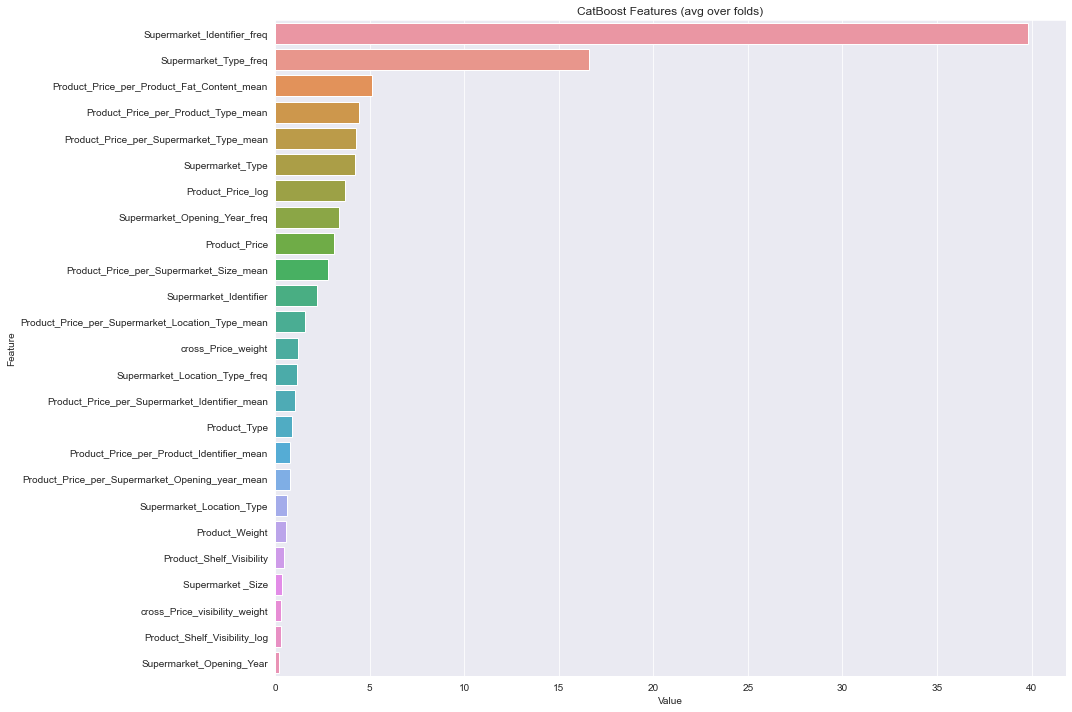

In [28]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('CatBoost Features (avg over folds)')
plt.tight_layout()
plt.show()